# Load libraries

In [ ]:
!pip install catboost
!pip install xgboost
!pip install pytorch-tabnet
!pip install scikit-multilearn
!pip install shap
!pip install forestci
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to

In [ ]:
# libreries for general scopes
import numpy as np
import pandas as pd
import math
import gc

# sklearn modules for modeling
#from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, recall_score, accuracy_score
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, make_scorer, hamming_loss, log_loss
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.preprocessing import OrdinalEncoder
from skmultilearn.model_selection import IterativeStratification
from skmultilearn.problem_transform import LabelPowerset

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.multioutput import MultiOutputClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, CatBoostRegressor

import shap

# libraries to make plots
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as shc

# apply some cool styling
plt.style.use("ggplot")
pd.set_option("display.max_columns", 100)
%matplotlib inline


# Custom functions

In [ ]:
def iterative_train_test_split(X, y, train_size, order):
    """Custom iterative train test split which
    'maintains balanced representation with respect
    to order-th label combinations.'
    """
    # Iteratively stratify a multi-label data set into folds
    # the stratifier splits the dataset into folds trying to maintain balanced representation with respect to order-th label combinations.
    # order = 1 means independence among class labels
    # order = 2 considers correlations between a pair of class labels
    # order > 2 consider correlations among all the class labels or subsets of class labels
    # http://proceedings.mlr.press/v74/szyma%C5%84ski17a/szyma%C5%84ski17a.pdf

    stratifier = IterativeStratification(
        n_splits=2, 
        order=order, 
        sample_distribution_per_fold=[1.0-train_size, train_size] # desired percentage of samples in each of the folds
      )   

    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
    return X_train, X_test, y_train, y_test

In [ ]:
def evaluate_predictions(y_preds, y_preds_labels, y_true):
  scores = dict()
  # multi-label and multi-task case
  if y_true.shape[1]>1:
    scores['roc_auc_macro'] = roc_auc_score(y_score=y_preds, y_true=y_true, average='macro')
    scores['roc_auc_micro'] = roc_auc_score(y_score=y_preds, y_true=y_true, average='micro')
    scores['roc_auc_weighted'] = roc_auc_score(y_score=y_preds, y_true=y_true, average='weighted')
    scores['recall_macro'] = recall_score(y_pred=y_preds_labels, y_true=y_true, average='macro')
    scores['recall_micro'] = recall_score(y_pred=y_preds_labels, y_true=y_true, average='micro')
    scores['recall_weighted'] = recall_score(y_pred=y_preds_labels, y_true=y_true, average='weighted')
    scores['f1_macro'] = f1_score(y_pred=y_preds_labels, y_true=y_true, average='macro')
    scores['f1_micro'] = f1_score(y_pred=y_preds_labels, y_true=y_true, average='micro')
    scores['f1_weighted'] = f1_score(y_pred=y_preds_labels, y_true=y_true, average='weighted')
    scores['accuracy'] = accuracy_score(y_eval, y_preds_labels)
  return scores

In [ ]:
def binarize(x):
  return 0 if x < 10 else 1

def grades_to_multiclass(x):
  y = 0
  if x in [18,19,20]:
    y = 5 # A
  elif x in [16,17]:
    y = 4 # B
  elif x in [14,15]:
    y = 3 # C
  elif x in [12,13]:
    y = 2 # D
  elif x in [10,11]:
    y = 1 # E
  else:
    y = 0 # FAIL
  return y

# Load data

In [ ]:
# Cloning repo to local disc
!git clone https://github.com/andreafedele/student-performance

fatal: destination path 'student-performance' already exists and is not an empty directory.


In [ ]:
df_por = pd.read_csv("student-performance/student-por.csv", sep=';')
df_mat = pd.read_csv("student-performance/student-mat.csv", sep=';')

print('Nr of Maths students:', df_mat.shape)
print('Nr of Portuguese students:', df_por.shape)

Nr of Maths students: (395, 33)
Nr of Portuguese students: (649, 33)


In [ ]:
df_feat_description = pd.read_csv("student-performance/feature-description.csv", sep=';')
df_feat_description

feature                                        description
0       school   student's school (binary: "GP" - Gabriel Pere...
1          sex   student's sex (binary: "F" - female or "M" - ...
2          age             student's age (numeric: from 15 to 22)
3      address   student's home address type (binary: "U" - ur...
4      famsize   family size (binary: "LE3" - less or equal to...
5      Pstatus   parent's cohabitation status (binary: "T" - l...
6         Medu   mother's education (numeric: 0 - none,  1 - p...
7         Fedu   father's education (numeric: 0 - none,  1 - p...
8         Mjob   mother's job (nominal: "teacher", "health" ca...
9         Fjob   father's job (nominal: "teacher", "health" ca...
10      reason   reason to choose this school (nominal: close ...
11    guardian   student's guardian (nominal: "mother", "fathe...
12  traveltime   home to school travel time (numeric: 1 - <15 ...
13   studytime   weekly study time (numeric: 1 - <2 hours, 2 -...
14    failures   number of past class failures (numeric: n if ...
15   schoolsup      extra educational support (binary: yes or no)
16      famsup     family educational support (binary: yes or no)
17        paid   extra paid classes within the course subject ...
18  activities    extra-curricular activities (binary: yes or no)
19     nursery        attended nursery school (binary: yes or no)
20      higher   wants to take higher education (binary: yes o...
21    internet        Internet access at home (binary: yes or no)
22    romantic   with a romantic relationship (binary: yes or no)
23      famrel   quality of family relationships (numeric: fro...
24    freetime   free time after school (numeric: from 1 - ver...
25       goout   going out with friends (numeric: from 1 - ver...
26        Dalc   workday alcohol consumption (numeric: from 1 ...
27        Walc   weekend alcohol consumption (numeric: from 1 ...
28      health   current health status (numeric: from 1 - very...
29    absences   number of school absences (numeric: from 0 to...
30          G1         first period grade (numeric: from 0 to 20)
31          G2        second period grade (numeric: from 0 to 20)
32          G3   final grade (numeric: from 0 to 20, output ta...

In [ ]:
df_por.G3.describe()

count    649.000000
mean      11.906009
std        3.230656
min        0.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: G3, dtype: float64

# Data Preprocessing

## Data Exploration Analysis

In [ ]:
task_type = 'multiclass' # or 'multilabel'

In [ ]:
# Grades range from 0 to 20
# if task_type == 'multilabel':
y_por = df_por[['G1','G2','G3']]
X_por = df_por.drop(columns=['G1','G2','G3'])
# else:
#   y_por = df_por[['G3']]
#   X_por = df_por.drop(columns=['G3'])

In [ ]:
X_por.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

<Axes: xlabel='G3', ylabel='Count'>

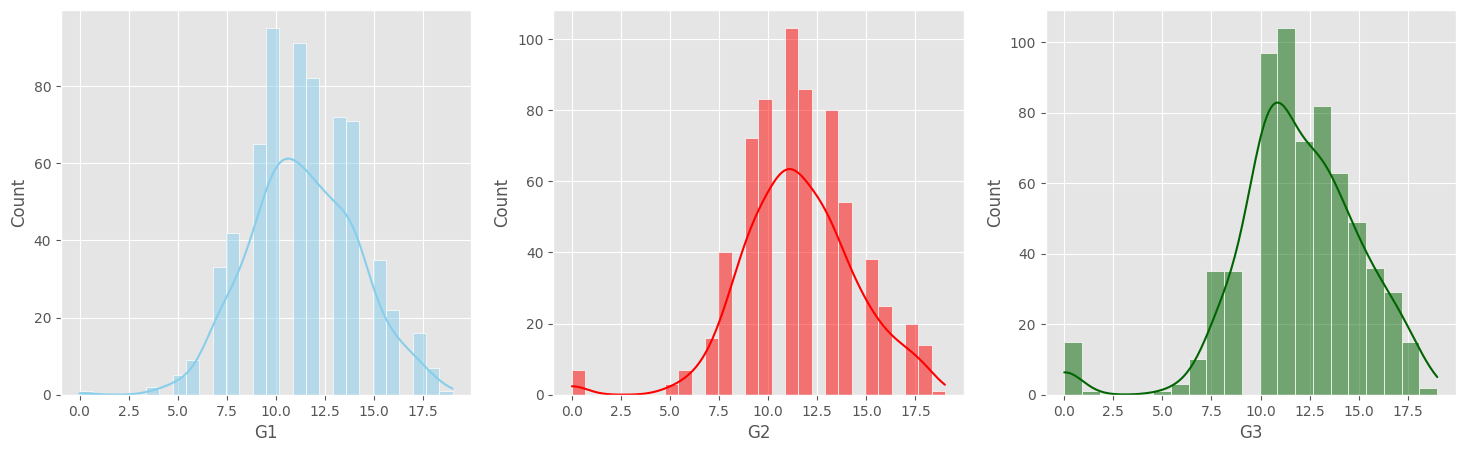

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.set_style("whitegrid")

sns.histplot(data=df_por, x="G1", color="skyblue", label="Grade 1", kde=True, ax=axs[0])
sns.histplot(data=df_por, x="G2", color="red", label="Grade 2", kde=True, ax=axs[1])
sns.histplot(data=df_por, x="G3", color="darkgreen", label="Grade 3", kde=True, ax=axs[2])

# plt.legend() 
# plt.show()

### Age and gender distribution

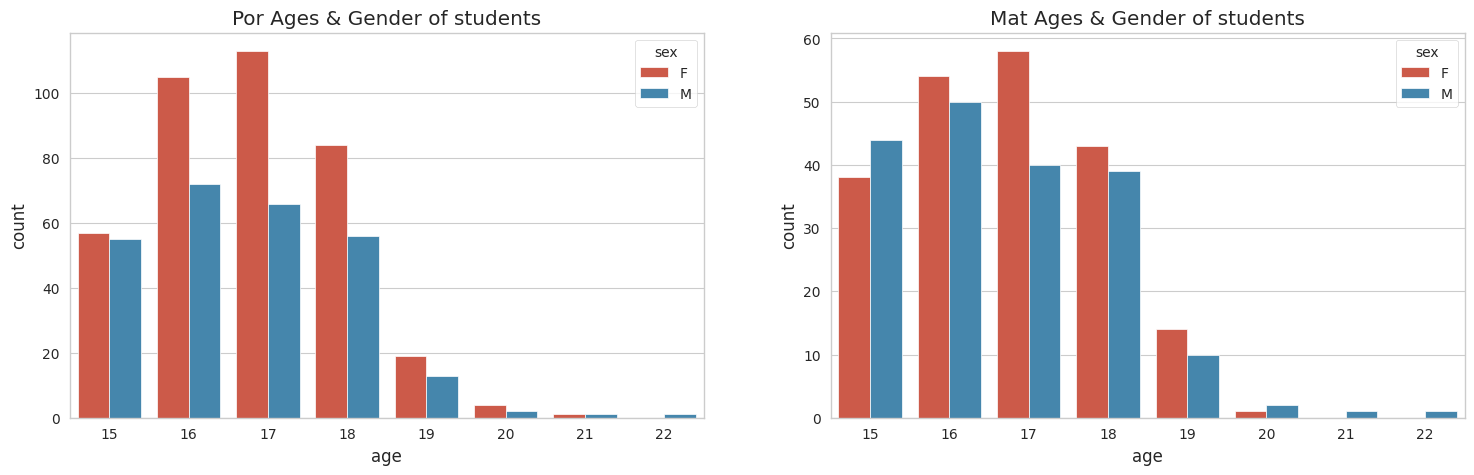

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 5))
p = sns.countplot(data = df_por, x='age', hue='sex', ax=axs[0])
m = sns.countplot(data = df_mat, x='age', hue='sex', ax=axs[1])
p.axes.set_title('Por Ages & Gender of students')
m.axes.set_title('Mat Ages & Gender of students')
plt.show()

13.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
21.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
21.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
17.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


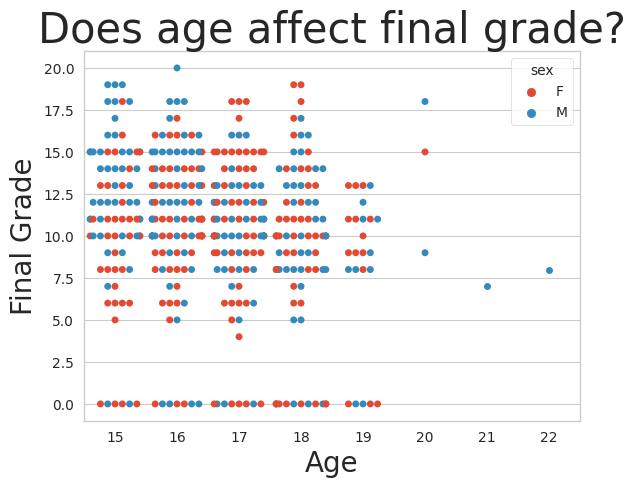

In [ ]:
b = sns.swarmplot(x='age', y='G3',hue='sex', data=df_mat)
b.axes.set_title('Does age affect final grade?', fontsize = 30)
b.set_xlabel('Age', fontsize = 20)
b.set_ylabel('Final Grade', fontsize = 20)
plt.show()

## Encoding categorical variables
CatBoost can handle categorical variables. According to the documentation it is prefereable to not use one-hot encoding during preprocessing as this affects both the training speed and the resulting quality.

In [ ]:
cat_cols = X_por.columns[X_por.dtypes == "object"].values

In [ ]:
len(cat_cols)

17

In [ ]:
numeric_cols = X_por.columns[X_por.dtypes != "object"].values
nominal_cols = [] # 4
binary_cols = [] # 13
for c in X_por.columns[X_por.dtypes == "object"].values:
  if len(X_por[c].unique()) == 2:
    binary_cols.append(c)
  else:
    nominal_cols.append(c)

In [ ]:
len(binary_cols)

13

Nominal binary variables will be converted to numerical binary variables

In [ ]:
# we keep track of the original feature values so that we can use them during the explanation part
X_por_enc = X_por.copy()

In [ ]:
enc_bin = OrdinalEncoder( dtype=int)
X_por_enc[binary_cols] = enc_bin.fit_transform(X_por_enc[binary_cols])

Nominal variables with more than 2 categories will be one-hot encoded ('Mjob', 'Fjob', 'reason', 'guardian')

In [ ]:
sh_before = X_por_enc.shape[1]
X_por_enc = pd.get_dummies(X_por_enc, 
                            columns=nominal_cols, 
                            drop_first=False)
sh_after = X_por_enc.shape[1]
print('N features before one-hot-encoding: ', sh_before)
print('N features after one-hot-encoding: ', sh_after)
print('Added columns: ', sh_after-sh_before)
X_por_enc.head()

N features before one-hot-encoding:  30
N features after one-hot-encoding:  43
Added columns:  13


school  sex  age  address  famsize  Pstatus  Medu  Fedu  traveltime  \
0       0    0   18        1        0        0     4     4           2   
1       0    0   17        1        0        1     1     1           1   
2       0    0   15        1        1        1     1     1           1   
3       0    0   15        1        0        1     4     2           1   
4       0    0   16        1        0        1     3     3           1   

   studytime  failures  schoolsup  famsup  paid  activities  nursery  higher  \
0          2         0          1       0     0           0        1       1   
1          2         0          0       1     0           0        0       1   
2          2         0          1       0     0           0        1       1   
3          3         0          0       1     0           1        1       1   
4          2         0          0       1     0           0        1       1   

   internet  romantic  famrel  freetime  goout  Dalc  Walc  health  absences  \
0         0         0       4         3      4     1     1       3         4   
1         1         0       5         3      3     1     1       3         2   
2         1         0       4         3      2     2     3       3         6   
3         1         1       3         2      2     1     1       5         0   
4         0         0       4         3      2     1     2       5         0   

   Mjob_at_home  Mjob_health  Mjob_other  Mjob_services  Mjob_teacher  \
0             1            0           0              0             0   
1             1            0           0              0             0   
2             1            0           0              0             0   
3             0            1           0              0             0   
4             0            0           1              0             0   

   Fjob_at_home  Fjob_health  Fjob_other  Fjob_services  Fjob_teacher  \
0             0            0           0              0             1   
1             0            0           1              0             0   
2             0            0           1              0             0   
3             0            0           0              1             0   
4             0            0           1              0             0   

   reason_course  reason_home  reason_other  reason_reputation  \
0              1            0             0                  0   
1              1            0             0                  0   
2              0            0             1                  0   
3              0            1             0                  0   
4              0            1             0                  0   

   guardian_father  guardian_mother  guardian_other  
0                0                1               0  
1                1                0               0  
2                0                1               0  
3                0                1               0  
4                1                0               0

In [ ]:
X_por.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

   reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0  course   mother           2          2         0       yes     no   no   
1  course   father           1          2         0        no    yes   no   
2   other   mother           1          2         0       yes     no   no   
3    home   mother           1          3         0        no    yes   no   
4    home   father           1          2         0        no    yes   no   

  activities nursery higher internet romantic  famrel  freetime  goout  Dalc  \
0         no     yes    yes       no       no       4         3      4     1   
1         no      no    yes      yes       no       5         3      3     1   
2         no     yes    yes      yes       no       4         3      2     2   
3        yes     yes    yes      yes      yes       3         2      2     1   
4         no     yes    yes       no       no       4         3      2     1   

   Walc  health  absences  
0     1       3         4  
1     1       3         2  
2     3       3         6  
3     1       5         0  
4     2       5         0

## Explore missing values

There are no missing values

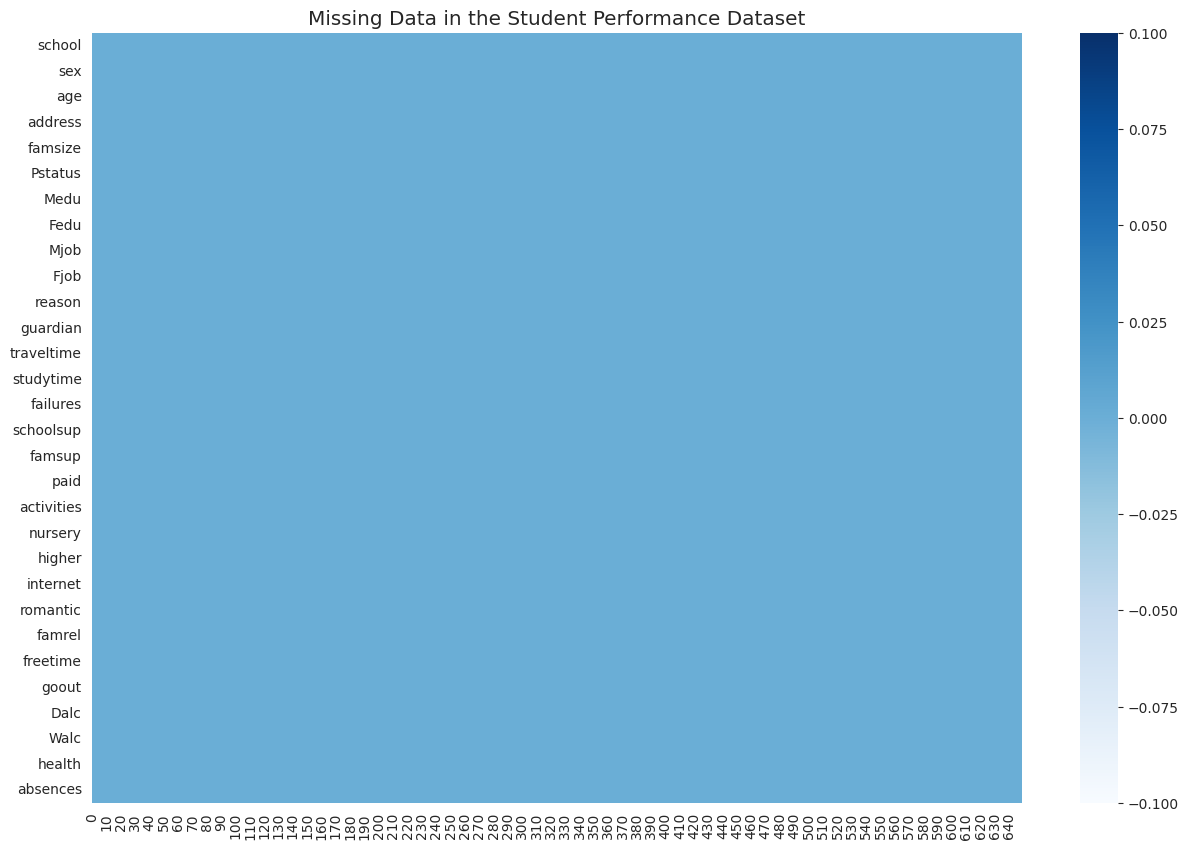

In [ ]:
plt.subplots(figsize=(15,10))  
sns.heatmap(X_por.isnull().transpose(), cmap = 'Blues')
plt.title("Missing Data in the Student Performance Dataset")
plt.show()

## Feature correlation with target

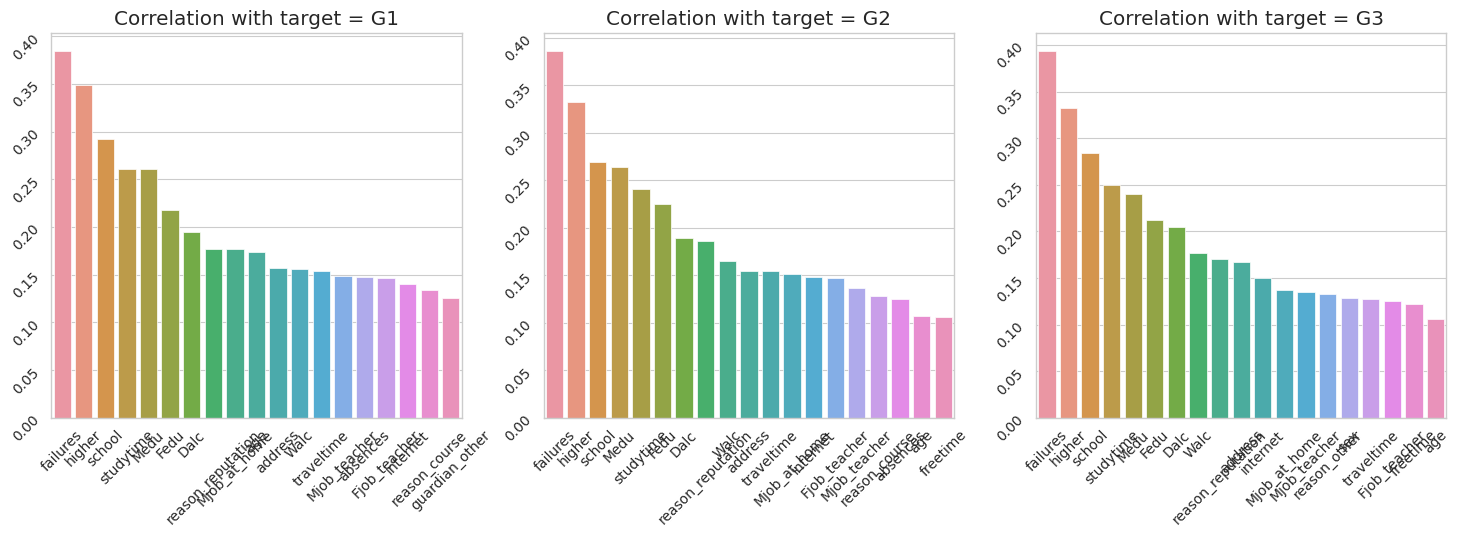

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
X_por_enc_corr = X_por_enc.copy()

# G1
X_por_enc_corr['target'] = y_por['G1']
corr_train = X_por_enc_corr.corr()['target'].abs().sort_values(ascending=False)
sns.barplot(x = corr_train[1: 20].index, y = corr_train[1: 20].values, ax=axs[0])
axs[0].set_title("Correlation with target = G1")
axs[0].tick_params(labelrotation= 45)

# G2
X_por_enc_corr['target'] = y_por['G2']
corr_train = X_por_enc_corr.corr()['target'].abs().sort_values(ascending=False)
sns.barplot(x = corr_train[1: 20].index, y = corr_train[1: 20].values, ax=axs[1])
axs[1].set_title("Correlation with target = G2")
axs[1].tick_params(labelrotation= 45)

# G3
X_por_enc_corr['target'] = y_por['G3']
corr_train = X_por_enc_corr.corr()['target'].abs().sort_values(ascending=False)
sns.barplot(x = corr_train[1: 20].index, y = corr_train[1: 20].values, ax=axs[2])
axs[2].set_title("Correlation with target = G3")
axs[2].tick_params(labelrotation= 45)

del X_por_enc_corr

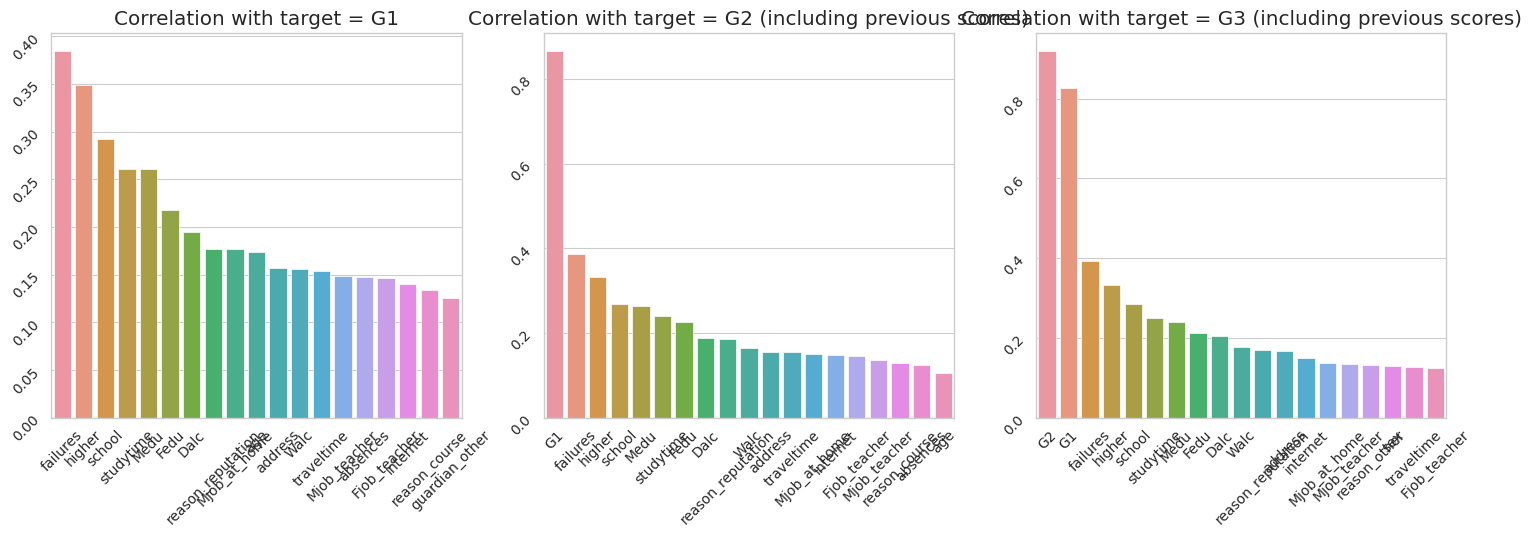

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
X_por_enc_corr = X_por_enc.copy()

# G1
X_por_enc_corr['target'] = y_por['G1']
corr_train = X_por_enc_corr.corr()['target'].abs().sort_values(ascending=False)
sns.barplot(x = corr_train[1: 20].index, y = corr_train[1: 20].values, ax=axs[0])
axs[0].set_title("Correlation with target = G1")
axs[0].tick_params(labelrotation= 45)

# G2
X_por_enc_corr['target'] = y_por['G2']
X_por_enc_corr_temp = X_por_enc_corr.merge(y_por['G1'], left_index=True, right_index=True)
corr_train = X_por_enc_corr_temp.corr()['target'].abs().sort_values(ascending=False)
sns.barplot(x = corr_train[1: 20].index, y = corr_train[1: 20].values, ax=axs[1])
axs[1].set_title("Correlation with target = G2 (including previous scores)")
axs[1].tick_params(labelrotation= 45)

# G3
X_por_enc_corr['target'] = y_por['G3']
X_por_enc_corr_temp = X_por_enc_corr.merge(y_por[['G1','G2']], left_index=True, right_index=True)
corr_train = X_por_enc_corr_temp.corr()['target'].abs().sort_values(ascending=False)
sns.barplot(x = corr_train[1: 20].index, y = corr_train[1: 20].values, ax=axs[2])
axs[2].set_title("Correlation with target = G3 (including previous scores)")
axs[2].tick_params(labelrotation= 45)

del X_por_enc_corr

# Classification

In [ ]:
def train_test_split_by_grade(X_por_enc, y_por, grade):
  # prepare features:
  if grade == 'G2':
    X_por_enc = X_por_enc.merge(y_por[['G1']], left_index=True, right_index=True)
  elif grade == 'G3':
    X_por_enc = X_por_enc.merge(y_por[['G1','G2']], left_index=True, right_index=True)

  # Oversampling
  oversample = SMOTE()
  X_por_enc_smote, y_por_smote = oversample.fit_resample(X_por_enc, y_por[grade])
  
  # Scaling
  # sc_X = StandardScaler()
  # sc_y = StandardScaler()
  # X_por_enc = pd.DataFrame(sc_X.fit_transform(X_por_enc), columns=X_por_enc.columns)
  # y_por = pd.DataFrame(sc_y.fit_transform(y_por), columns=y_por.columns)  

  # Split the training set into train + eval (0.8-0.2 proportion)
  X_por_train, X_por_eval, y_por_train, y_por_eval = train_test_split(X_por_enc_smote, y_por_smote, 
                                                                    #stratify=y_por['G1'], 
                                                                    random_state = 123,
                                                                    test_size=0.2)
  return X_por_train, X_por_eval, y_por_train, y_por_eval

In [ ]:
def get_model_predictions(X_por_train, X_por_eval, y_por_train, y_por_eval, grade, model, grid, finetune):
  """ grade (str): grade to be computed, either 'G1', 'G2' or 'G3'
      grid (dict): grid for grid search in hyperparameter tuning
      returns:
        - fitted model
        - predictions on test set
        - RMSE and R2 on train and test set
  """
  print('Predicting grade ', grade)
  
  # # prepare features:
  # if grade == 'G2':
  #   X_por_enc = X_por_enc.merge(y_por[['G1']], left_index=True, right_index=True)
  # elif grade == 'G3':
  #   X_por_enc = X_por_enc.merge(y_por[['G1','G2']], left_index=True, right_index=True)

  # # Oversampling
  # oversample = SMOTE()
  # X_por_enc_smote, y_por_smote = oversample.fit_resample(X_por_enc, y_por[grade])
  
  # # Scaling
  # # sc_X = StandardScaler()
  # # sc_y = StandardScaler()
  # # X_por_enc = pd.DataFrame(sc_X.fit_transform(X_por_enc), columns=X_por_enc.columns)
  # # y_por = pd.DataFrame(sc_y.fit_transform(y_por), columns=y_por.columns)  

  # # Split the training set into train + eval (0.8-0.2 proportion)
  # X_por_train, X_por_eval, y_por_train, y_por_eval = train_test_split(X_por_enc_smote, y_por_smote, 
  #                                                                   #stratify=y_por['G1'], 
  #                                                                   test_size=0.2)

  if finetune:
    print('Hyperparameter finetuning of method', model)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring='accuracy',error_score=0, verbose=0)
    grid_result = grid_search.fit(X_por_train, y_por_train.values.ravel())  
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    # means = grid_result.cv_results_['mean_test_score']
    # stds = grid_result.cv_results_['std_test_score']
    # params = grid_result.cv_results_['params']
    # for mean, stdev, param in zip(means, stds, params):
    #   print("%f (%f) with: %r" % (mean, stdev, param))
    model = grid_search.best_estimator_

  if y_por_train.nunique()>2:
    avg=None
  else:
    avg='binary'
  
  # Train metrics
  predictions_train = model.predict(X_por_train)
  acc_train = accuracy_score(y_por_train,predictions_train)
  precision_train = precision_score(y_por_train,predictions_train, average=avg, labels=np.unique(predictions_train), zero_division=0)
  recall_train = recall_score(y_por_train,predictions_train, average=avg, labels=np.unique(predictions_train), zero_division=0)
  f1_train = f1_score(y_por_train,predictions_train, average=avg, labels=np.unique(predictions_train), zero_division=0)
  if avg=='binary':
    y_por_proba_train = model.predict_proba(X_por_train)[:, 1]
    roc_train = roc_auc_score(y_por_train, y_por_proba_train, average='macro',labels=np.unique(predictions_train) )
  else:
    y_por_proba_train = model.predict_proba(X_por_train)
    roc_train = roc_auc_score(y_por_train, y_por_proba_train, average='macro',labels=np.unique(predictions_train) , multi_class='ovr')
  train_metrics = dict(accuracy=acc_train, precision=precision_train, recall=recall_train, f1=f1_train, roc=roc_train)
  
  # Get predictions
  print('Getting predictions for grade ', grade)
  predictions = model.predict(X_por_eval)
  
  # Test metrics
  acc_test = accuracy_score(y_por_eval,predictions)
  precision_test = precision_score(y_por_eval,predictions, average=avg, labels=np.unique(predictions), zero_division=0)
  recall_test = recall_score(y_por_eval,predictions, average=avg, labels=np.unique(predictions), zero_division=0)
  f1_test = f1_score(y_por_eval,predictions, average=avg, labels=np.unique(predictions), zero_division=0)
  if avg=='binary':
    y_por_proba = model.predict_proba(X_por_eval)[:, 1]
    roc_test = roc_auc_score(y_por_eval, y_por_proba, average='macro',labels=np.unique(predictions))
  else:
    y_por_proba = model.predict_proba(X_por_eval)
    roc_test = roc_auc_score(y_por_eval, y_por_proba, average='macro',labels=np.unique(predictions), multi_class='ovr')
  test_metrics = dict(accuracy=acc_test, precision=precision_test, recall=recall_test, f1=f1_test, labels=np.unique(predictions), roc=roc_test)

  print("Train performance")
  print("Accuracy: {:.2f}".format(acc_train))
  print("Precision: ", precision_train)
  print("Recall: ", recall_train)
  print("F1 score: ", f1_train)
  print('ROC-AUC score: ', roc_train)
  if avg==None:
    print('F1 score (macro): ', f1_score(y_por_train,predictions_train, average='macro', labels=np.unique(predictions_train), zero_division=0))
    print('F1 score (weighted): ', f1_score(y_por_train,predictions_train, average='weighted', labels=np.unique(predictions_train), zero_division=0))
    print('ROC-AUC score (weighted)', roc_auc_score(y_por_train, model.predict_proba(X_por_train), average='weighted',labels=np.unique(predictions_train), multi_class='ovr'))

  print("Test performance")
  print("Accuracy: {:.2f}".format(acc_test))
  print("Precision: {:.2f}", precision_test)
  print("Recall: ", recall_test)
  print("F1 score: ", f1_test)
  print('ROC-AUC score: ', roc_test)
  if avg==None:
    print('F1 score (macro): ', f1_score(y_por_eval,predictions, average='macro', labels=np.unique(predictions), zero_division=0))
    print('F1 score (weighted): ', f1_score(y_por_eval,predictions, average='weighted', labels=np.unique(predictions), zero_division=0))
    print('ROC-AUC score (weighted)', roc_auc_score(y_por_eval, model.predict_proba(X_por_eval), average='weighted',labels=np.unique(predictions), multi_class='ovr'))
  
  return model, predictions, train_metrics, test_metrics

In [ ]:
model_list = dict(
    logisticRegression = LogisticRegression(random_state=123), 
    knn = KNeighborsClassifier(), 
    randomForest = RandomForestClassifier(random_state=123), 
    svm = SVC(random_state=123, probability=True), 
    catb = CatBoostClassifier(random_seed=123),#(task_type="GPU"), 
    xgb = XGBClassifier(random_seed=123)#(tree_method='gpu_hist', gpu_id=0)
    )
grid_params = dict(
    logisticRegression=dict(
        solver = ['newton-cg', 'lbfgs', 'liblinear'],
        penalty = ['l2'],
        C = [100, 10, 1.0, 0.1, 0.01]),
    knn=dict(
        n_neighbors = range(1, 21, 2),
        p=[1,2,5],
        weights = ['uniform', 'distance'],
        metric = ['euclidean', 'manhattan', 'minkowski']),
    randomForest=dict(
        n_estimators = [10, 100, 500],
        min_samples_leaf=[2, 4, 6],
        min_samples_split=[2, 5, 10],
        max_features = ['sqrt', 'log2']),
    svm=dict(
        kernel = ['poly', 'rbf', 'sigmoid'],
        C = [50, 10, 1.0, 0.1, 0.01],
        gamma = ['scale']),
    catb=dict(
        iterations=[100, 150, 200],
        learning_rate=[0.03, 0.1],
        depth=[2, 4, 6, 8],
        l2_leaf_reg=[0.2, 0.5, 1, 3]),
    xgb=dict(
        max_depth=[3, 6, 10, 15],
        learning_rate=[0.01, 0.1, 0.3],
        min_child_weight=list(range(5,8)),
        n_estimators=[100, 250, 500, 750])
    )

In [ ]:
# Only the hyperparameters of the selected model have been updated here
g1_best_model_list = dict(
    logisticRegression = LogisticRegression(C=100, penalty='l2', solver='liblinear'), 
    knn = KNeighborsClassifier(metric='manhattan', n_neighbors=1, p=1, weights='uniform'), 
    randomForest = RandomForestClassifier(max_features='log2', min_samples_leaf=2, min_samples_split=5, n_estimators=500), 
    svc = SVC(C=10, gamma='scale', kernel='rbf'), 
    catb = CatBoostClassifier(depth=6, iterations=200, l2_leaf_reg=0.2, learning_rate=0.1),#(task_type="GPU"), 
    xgb = XGBClassifier(learning_rate=0.1, max_depth=3, min_child_weight=6, n_estimators=250)#tree_method='gpu_hist', gpu_id=0)
    )
g2_best_model_list = dict(
    logisticRegression = LogisticRegression(C=1, penalty='l2', solver='newton-cg'), 
    knn = KNeighborsClassifier(metric='manhattan', n_neighbors=1, p=1, weights='uniform'), 
    randomForest = RandomForestClassifier(max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=500), 
    svc = SVC(C=50, gamma='scale', kernel='rbf'), 
    catb = CatBoostClassifier(depth=6, iterations=150, l2_leaf_reg=0.2, learning_rate=0.1),#(task_type="GPU"), 
    xgb = XGBClassifier(learning_rate=0.1, max_depth=3, min_child_weight=6, n_estimators=250)#tree_method='gpu_hist', gpu_id=0)
    )
g3_best_model_list = dict(
    logisticRegression = LogisticRegression(C=1, penalty='l2', solver='lbfgs'), 
    knn = KNeighborsClassifier(metric='manhattan', n_neighbors=3, p=1, weights='uniform'), 
    randomForest = RandomForestClassifier(max_features='log2', min_samples_leaf=2, min_samples_split=2, n_estimators=100),
    svc = SVC(C=50, gamma='scale', kernel='rbf', random_state=123), 
    catb = CatBoostClassifier(depth=8, iterations=100, l2_leaf_reg=0.5, learning_rate=0.1),#(task_type="GPU"), 
    xgb = XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100)#tree_method='gpu_hist', gpu_id=0)
    )

## Binary classification
Grades are reduces to two classes:
- **0 = Fail** if grade in [0, 10)
- **1 = Pass** if grade [10, 20]

The model can be queried at three different time points:
* For the assignment of the first grade, i.e., to predict G1 given the features only (we can expect this to return very biased results with very low accuracy)
* For the assignment of the second grade, i.e., to predict G2 given the features AND G1
* For the assignment of the thirs grade, i.e., to predict G3 given the features AND G1 AND G2

Classification models tested:

In [ ]:
def binarize(x):
  return 0 if x < 10 else 1

In [ ]:
y_por_bin = y_por.applymap(binarize)

<Axes: xlabel='G3', ylabel='Count'>

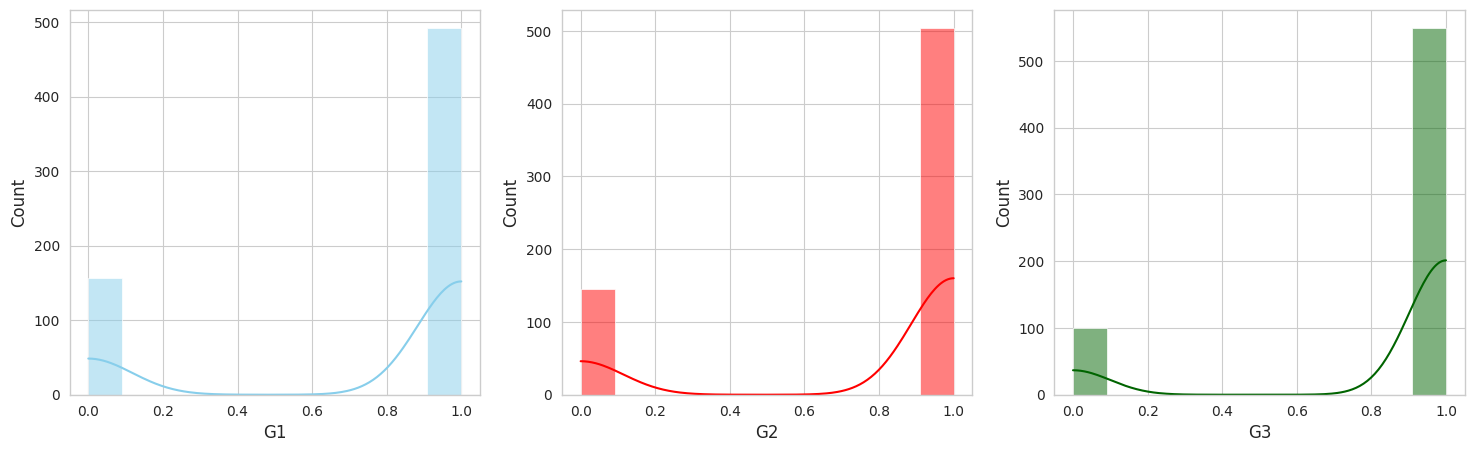

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.set_style("whitegrid")

sns.histplot(data=y_por_bin, x="G1", color="skyblue", label="Grade 1", kde=True, ax=axs[0])
sns.histplot(data=y_por_bin, x="G2", color="red", label="Grade 2", kde=True, ax=axs[1])
sns.histplot(data=y_por_bin, x="G3", color="darkgreen", label="Grade 3", kde=True, ax=axs[2])


In [ ]:
X_por_train_bin_g1, X_por_eval_bin_g1, y_por_train_bin_g1, y_por_eval_bin_g1 = train_test_split_by_grade(X_por_enc, y_por_bin, 'G1')
X_por_train_bin_g2, X_por_eval_bin_g2, y_por_train_bin_g2, y_por_eval_bin_g2 = train_test_split_by_grade(X_por_enc, y_por_bin, 'G2')
X_por_train_bin_g3, X_por_eval_bin_g3, y_por_train_bin_g3, y_por_eval_bin_g3 = train_test_split_by_grade(X_por_enc, y_por_bin, 'G3')

NameError: ignored

#### Logistic regression

In [ ]:
lr_g1, lr_predictions_g1, lr_train_metrics_g1, lr_test_metrics_g1 = get_model_predictions(X_por_train_bin_g1, X_por_eval_bin_g1, y_por_train_bin_g1, y_por_eval_bin_g1, 'G1', model_list['logisticRegression'], grid_params['logisticRegression'], True)

Predicting grade  G1
Hyperparameter finetuning of method LogisticRegression(random_state=123)
Best: 0.861550 using {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Getting predictions for grade  G1
Train performance
Accuracy: 0.88
Precision:  0.8653366583541147
Recall:  0.9036458333333334
F1 score:  0.8840764331210192
ROC-AUC score:  0.9551669768403641
Test performance
Accuracy: 0.88
Precision: {:.2f} 0.875
Recall:  0.9074074074074074
F1 score:  0.8909090909090909
ROC-AUC score:  0.9314398668331253


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
lr_g2, lr_predictions_g2, lr_train_metrics_g2, lr_test_metrics_g2 = get_model_predictions(X_por_train_bin_g2, X_por_eval_bin_g2, y_por_train_bin_g2, y_por_eval_bin_g2, 'G2', model_list['logisticRegression'], grid_params['logisticRegression'], True)

Predicting grade  G2
Hyperparameter finetuning of method LogisticRegression(random_state=123)
Best: 0.903213 using {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Getting predictions for grade  G2
Train performance
Accuracy: 0.91
Precision:  0.9211195928753181
Recall:  0.905
F1 score:  0.9129886506935688
ROC-AUC score:  0.9676847290640395
Test performance
Accuracy: 0.93
Precision: {:.2f} 0.9320388349514563
Recall:  0.9230769230769231
F1 score:  0.927536231884058
ROC-AUC score:  0.9609497645211932


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
lr_g3, lr_predictions_g3, lr_train_metrics_g3, lr_test_metrics_g3 = get_model_predictions(X_por_train_bin_g3, X_por_eval_bin_g3, y_por_train_bin_g3, y_por_eval_bin_g3, 'G3', model_list['logisticRegression'], grid_params['logisticRegression'], True)

Predicting grade  G3
Hyperparameter finetuning of method LogisticRegression(random_state=123)
Best: 0.949864 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Getting predictions for grade  G3
Train performance
Accuracy: 0.96
Precision:  0.963718820861678
Recall:  0.9615384615384616
F1 score:  0.9626274065685164
ROC-AUC score:  0.9942037859603969
Test performance
Accuracy: 0.94
Precision: {:.2f} 0.9514563106796117
Recall:  0.9158878504672897
F1 score:  0.9333333333333335
ROC-AUC score:  0.9818046480853527


#### Random forest

In [ ]:
rf_g1, rf_predictions_g1, rf_train_metrics_g1, rf_test_metrics_g1  = get_model_predictions(X_por_train_bin_g1, X_por_eval_bin_g1, y_por_train_bin_g1, y_por_eval_bin_g1, 'G1', model_list['randomForest'], grid_params['randomForest'], True)

Predicting grade  G1
Hyperparameter finetuning of method RandomForestClassifier(random_state=123)
Best: 0.867903 using {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
Getting predictions for grade  G1
Train performance
Accuracy: 0.98
Precision:  0.9768041237113402
Recall:  0.9869791666666666
F1 score:  0.9818652849740932
ROC-AUC score:  0.999088864764268
Test performance
Accuracy: 0.88
Precision: {:.2f} 0.92
Recall:  0.8518518518518519
F1 score:  0.8846153846153846
ROC-AUC score:  0.9616104868913857


In [ ]:
rf_g2, rf_predictions_g2, rf_train_metrics_g2, rf_test_metrics_g2  = get_model_predictions(X_por_train_bin_g2, X_por_eval_bin_g2, y_por_train_bin_g2, y_por_eval_bin_g2, 'G2', model_list['randomForest'], grid_params['randomForest'], True)

Predicting grade  G2
Hyperparameter finetuning of method RandomForestClassifier(random_state=123)
Best: 0.901971 using {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Getting predictions for grade  G2
Train performance
Accuracy: 0.97
Precision:  0.9702233250620348
Recall:  0.9775
F1 score:  0.9738480697384807
ROC-AUC score:  0.9982697044334976
Test performance
Accuracy: 0.91
Precision: {:.2f} 0.897196261682243
Recall:  0.9230769230769231
F1 score:  0.9099526066350712
ROC-AUC score:  0.9732142857142857


In [ ]:
rf_g3, rf_predictions_g3, rf_train_metrics_g3, rf_test_metrics_g3  = get_model_predictions(X_por_train_bin_g3, X_por_eval_bin_g3, y_por_train_bin_g3,y_por_eval_bin_g3, 'G3', model_list['randomForest'], grid_params['randomForest'], True)

Predicting grade  G3
Hyperparameter finetuning of method RandomForestClassifier(random_state=123)
Best: 0.963519 using {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Getting predictions for grade  G3
Train performance
Accuracy: 0.99
Precision:  0.9886104783599089
Recall:  0.9819004524886877
F1 score:  0.985244040862656
ROC-AUC score:  0.99949146913529
Test performance
Accuracy: 0.95
Precision: {:.2f} 0.9611650485436893
Recall:  0.9252336448598131
F1 score:  0.9428571428571428
ROC-AUC score:  0.9912331486229427


#### KNN 

In [ ]:
knn_g1, knn_predictions_g1, knn_train_metrics_g1, knn_test_metrics_g1 = get_model_predictions(X_por_train_bin_g1, X_por_eval_bin_g1, y_por_train_bin_g1, y_por_eval_bin_g1, 'G1', model_list['knn'], grid_params['knn'], True)

Predicting grade  G1
Hyperparameter finetuning of method KNeighborsClassifier()
Best: 0.867863 using {'metric': 'euclidean', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Getting predictions for grade  G1
Train performance
Accuracy: 1.00
Precision:  1.0
Recall:  1.0
F1 score:  1.0
ROC-AUC score:  1.0
Test performance
Accuracy: 0.83
Precision: {:.2f} 0.9743589743589743
Recall:  0.7037037037037037
F1 score:  0.8172043010752689
ROC-AUC score:  0.8406158967956721


In [ ]:
knn_g2, knn_predictions_g2, knn_train_metrics_g2, knn_test_metrics_g2 = get_model_predictions(X_por_train_bin_g2, X_por_eval_bin_g2, y_por_train_bin_g2,y_por_eval_bin_g2, 'G2', model_list['knn'], grid_params['knn'], True)

Predicting grade  G2
Hyperparameter finetuning of method KNeighborsClassifier()
Best: 0.864765 using {'metric': 'manhattan', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Getting predictions for grade  G2
Train performance
Accuracy: 1.00
Precision:  1.0
Recall:  1.0
F1 score:  1.0
ROC-AUC score:  1.0
Test performance
Accuracy: 0.87
Precision: {:.2f} 0.9875
Recall:  0.7596153846153846
F1 score:  0.8586956521739131
ROC-AUC score:  0.8747056514913658


In [ ]:
knn_g3, knn_predictions_g3, knn_train_metrics_3, knn_test_metrics_g3 = get_model_predictions(X_por_train_bin_g3, X_por_eval_bin_g3, y_por_train_bin_g3,y_por_eval_bin_g3, 'G3', model_list['knn'], grid_params['knn'], True)

Predicting grade  G3
Hyperparameter finetuning of method KNeighborsClassifier()
Best: 0.937331 using {'metric': 'manhattan', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Getting predictions for grade  G3
Train performance
Accuracy: 1.00
Precision:  1.0
Recall:  1.0
F1 score:  1.0
ROC-AUC score:  1.0
Test performance
Accuracy: 0.93
Precision: {:.2f} 1.0
Recall:  0.8504672897196262
F1 score:  0.9191919191919192
ROC-AUC score:  0.9252336448598131


#### SVM

In [ ]:
svm_g1, svm_predictions_g1, svm_train_metrics_g1, svm_test_metrics_g1 = get_model_predictions(X_por_train_bin_g1, X_por_eval_bin_g1, y_por_train_bin_g1, y_por_eval_bin_g1,'G1', model_list['svm'], grid_params['svm'], True)

Predicting grade  G1
Hyperparameter finetuning of method SVC(probability=True, random_state=123)
Best: 0.858953 using {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
Getting predictions for grade  G1
Train performance
Accuracy: 0.92
Precision:  0.8970588235294118
Recall:  0.953125
F1 score:  0.9242424242424244
ROC-AUC score:  0.9761489350703061
Test performance
Accuracy: 0.87
Precision: {:.2f} 0.9191919191919192
Recall:  0.8425925925925926
F1 score:  0.8792270531400966
ROC-AUC score:  0.9538077403245944


In [ ]:
svm_g2, svm_predictions_g2, svm_train_metrics_g2, svm_test_metrics_g2 = get_model_predictions(X_por_train_bin_g2, X_por_eval_bin_g2, y_por_train_bin_g2,y_por_eval_bin_g2, 'G2', model_list['svm'], grid_params['svm'], True)

Predicting grade  G2
Hyperparameter finetuning of method SVC(probability=True, random_state=123)
Best: 0.904448 using {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
Getting predictions for grade  G2
Train performance
Accuracy: 0.93
Precision:  0.9348370927318296
Recall:  0.9325
F1 score:  0.9336670838548186
ROC-AUC score:  0.9773522167487685
Test performance
Accuracy: 0.92
Precision: {:.2f} 0.9065420560747663
Recall:  0.9326923076923077
F1 score:  0.919431279620853
ROC-AUC score:  0.9619309262166406


In [ ]:
svm_g1, svm_predictions_g3, svm_train_metrics_g3, svm_test_metrics_g3 = get_model_predictions(X_por_train_bin_g3, X_por_eval_bin_g3, y_por_train_bin_g3,y_por_eval_bin_g3, 'G3', model_list['svm'], grid_params['svm'], True)

Predicting grade  G3
Hyperparameter finetuning of method SVC(probability=True, random_state=123)
Best: 0.953286 using {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
Getting predictions for grade  G3
Train performance
Accuracy: 0.98
Precision:  0.9796380090497737
Recall:  0.9796380090497737
F1 score:  0.9796380090497737
ROC-AUC score:  0.9964558512183984
Test performance
Accuracy: 0.95
Precision: {:.2f} 0.9897959183673469
Recall:  0.9065420560747663
F1 score:  0.9463414634146342
ROC-AUC score:  0.9861880737738814


####CatBoost

In [ ]:
cb_g1, cb_predictions_g1, cb_train_metrics_g1, cb_test_metrics_g1 = get_model_predictions(X_por_train_bin_g1, X_por_eval_bin_g1, y_por_train_bin_g1, y_por_eval_bin_g1, 'G1', model_list['catb'], grid_params['catb'], True)

Predicting grade  G1
Hyperparameter finetuning of method <catboost.core.CatBoostClassifier object at 0x7f7defe81ff0>
0:	learn: 0.6703959	total: 50.7ms	remaining: 10.1s
1:	learn: 0.6436974	total: 56.5ms	remaining: 5.59s
2:	learn: 0.6183735	total: 60.9ms	remaining: 4s
3:	learn: 0.5960796	total: 67.5ms	remaining: 3.31s
4:	learn: 0.5699808	total: 71.9ms	remaining: 2.81s
5:	learn: 0.5473235	total: 76.4ms	remaining: 2.47s
6:	learn: 0.5297053	total: 84.5ms	remaining: 2.33s
7:	learn: 0.5114155	total: 91.1ms	remaining: 2.19s
8:	learn: 0.4920696	total: 102ms	remaining: 2.16s
9:	learn: 0.4786215	total: 107ms	remaining: 2.03s
10:	learn: 0.4623631	total: 112ms	remaining: 1.92s
11:	learn: 0.4502369	total: 116ms	remaining: 1.82s
12:	learn: 0.4363960	total: 121ms	remaining: 1.74s
13:	learn: 0.4252191	total: 126ms	remaining: 1.67s
14:	learn: 0.4098837	total: 131ms	remaining: 1.61s
15:	learn: 0.3980429	total: 135ms	remaining: 1.56s
16:	learn: 0.3829479	total: 140ms	remaining: 1.51s
17:	learn: 0.3750425	

In [ ]:
cb_g2, cb_predictions_g2, cb_train_metrics_g2, cb_test_metrics_g2 = get_model_predictions(X_por_train_bin_g2, X_por_eval_bin_g2, y_por_train_bin_g2,y_por_eval_bin_g2, 'G2', model_list['catb'], grid_params['catb'], True)

Predicting grade  G2
Hyperparameter finetuning of method <catboost.core.CatBoostClassifier object at 0x7f7defe81ff0>
0:	learn: 0.5970754	total: 1.98ms	remaining: 295ms
1:	learn: 0.5303330	total: 4.02ms	remaining: 298ms
2:	learn: 0.4787325	total: 5.77ms	remaining: 283ms
3:	learn: 0.4364408	total: 7.46ms	remaining: 272ms
4:	learn: 0.3966501	total: 9.16ms	remaining: 266ms
5:	learn: 0.3587914	total: 11.2ms	remaining: 270ms
6:	learn: 0.3384518	total: 13ms	remaining: 266ms
7:	learn: 0.3186774	total: 14.9ms	remaining: 265ms
8:	learn: 0.3039479	total: 16.6ms	remaining: 261ms
9:	learn: 0.2944578	total: 20.2ms	remaining: 283ms
10:	learn: 0.2836351	total: 23.6ms	remaining: 298ms
11:	learn: 0.2760296	total: 26.8ms	remaining: 308ms
12:	learn: 0.2692228	total: 30ms	remaining: 316ms
13:	learn: 0.2613029	total: 33.3ms	remaining: 324ms
14:	learn: 0.2500969	total: 36.5ms	remaining: 328ms
15:	learn: 0.2382091	total: 38.8ms	remaining: 325ms
16:	learn: 0.2248111	total: 40.7ms	remaining: 318ms
17:	learn: 0.

In [ ]:
cb_g3, cb_predictions_g3, cb_train_metrics_g3, cb_test_metrics_g3 = get_model_predictions(X_por_train_bin_g3, X_por_eval_bin_g3, y_por_train_bin_g3,y_por_eval_bin_g3, 'G3', model_list['catb'], grid_params['catb'], True)

Predicting grade  G3
Hyperparameter finetuning of method <catboost.core.CatBoostClassifier object at 0x7f7defe81ff0>
0:	learn: 0.5511692	total: 4.54ms	remaining: 676ms
1:	learn: 0.3877513	total: 7.02ms	remaining: 519ms
2:	learn: 0.2972964	total: 12ms	remaining: 590ms
3:	learn: 0.2337919	total: 15.5ms	remaining: 565ms
4:	learn: 0.2080629	total: 20.5ms	remaining: 594ms
5:	learn: 0.1695637	total: 25.3ms	remaining: 607ms
6:	learn: 0.1600080	total: 28.9ms	remaining: 590ms
7:	learn: 0.1432606	total: 32ms	remaining: 569ms
8:	learn: 0.1285050	total: 36.9ms	remaining: 579ms
9:	learn: 0.1170020	total: 41.7ms	remaining: 584ms
10:	learn: 0.1094287	total: 46.4ms	remaining: 587ms
11:	learn: 0.1003160	total: 51ms	remaining: 587ms
12:	learn: 0.0923973	total: 55.7ms	remaining: 587ms
13:	learn: 0.0839507	total: 60.4ms	remaining: 587ms
14:	learn: 0.0805735	total: 66.8ms	remaining: 601ms
15:	learn: 0.0769534	total: 69.8ms	remaining: 585ms
16:	learn: 0.0725901	total: 75.2ms	remaining: 588ms
17:	learn: 0.06

#### XGBoost

In [ ]:
xgb_g1, svm_predictions_g1, xgb_train_metrics_g1, xgb_test_metrics_g1 = get_model_predictions(X_por_train_bin_g1, X_por_eval_bin_g1, y_por_train_bin_g1, y_por_eval_bin_g1, 'G1', model_list['xgb'], grid_params['xgb'], True)

Predicting grade  G1
Hyperparameter finetuning of method XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=123, ...)
[19:36:24] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

Best: 0.875482 using {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100}


In [ ]:
xgb_g2, svm_predictions_g2, xgb_train_metrics_g2, xgb_test_metrics_g2 = get_model_predictions(X_por_train_bin_g2, X_por_eval_bin_g2, y_por_train_bin_g2,y_por_eval_bin_g2,'G2', model_list['xgb'], grid_params['xgb'], True)

Predicting grade  G2
Hyperparameter finetuning of method XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=123, ...)
[19:42:50] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

Best: 0.903221 using {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 750}

In [ ]:
xgb_g3, svm_predictions_g3, xgb_train_metrics_g3, xgb_test_metrics_g3 = get_model_predictions(X_por_train_bin_g3, X_por_eval_bin_g3, y_por_train_bin_g3,y_por_eval_bin_g3, 'G3', model_list['xgb'], grid_params['xgb'], True)

Predicting grade  G3
Hyperparameter finetuning of method XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=123, ...)
[19:48:30] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

Best: 0.958968 using {'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 750}

#### Methods comparison 

In [ ]:
lr_dict = pd.DataFrame.from_dict(dict(G1=lr_test_metrics_g1,G2=lr_test_metrics_g2,G3=lr_test_metrics_g3),
                       orient='index')
cb_dict = pd.DataFrame.from_dict(dict(G1=cb_test_metrics_g1,G2=cb_test_metrics_g2,G3=cb_test_metrics_g3),
                       orient='index')
rf_dict = pd.DataFrame.from_dict(dict(G1=rf_test_metrics_g1,G2=rf_test_metrics_g2,G3=rf_test_metrics_g3), 
                       orient='index')
svm_dict = pd.DataFrame.from_dict(dict(G1=svm_test_metrics_g1,G2=svm_test_metrics_g2,G3=svm_test_metrics_g3),
                       orient='index')
knn_dict = pd.DataFrame.from_dict(dict(G1=knn_test_metrics_g1,G2=knn_test_metrics_g2,G3=knn_test_metrics_g3),
                       orient='index')
xgb_dict = pd.DataFrame.from_dict(dict(G1=xgb_test_metrics_g1,G2=xgb_test_metrics_g2,G3=xgb_test_metrics_g3),
                       orient='index')

In [ ]:
pd.concat([lr_dict, cb_dict, rf_dict, svm_dict, knn_dict, xgb_dict],
          keys=['Logistic Regression', 'CatBoost', 'Random Forest', 'SVM', 'KNN Classifier', 'XGBoost'], 
          axis=1).round(3)

Logistic Regression                                        CatBoost  \
              accuracy precision recall     f1  labels    roc accuracy   
G1               0.878     0.875  0.907  0.891  [0, 1]  0.955    0.904   
G2               0.926     0.932  0.923  0.928  [0, 1]  0.968    0.926   
G3               0.936     0.951  0.916  0.933  [0, 1]  0.994    0.941   

                                        Random Forest                          \
   precision recall     f1  labels  roc      accuracy precision recall     f1   
G1     0.941  0.880  0.909  [0, 1]  1.0         0.878     0.920  0.852  0.885   
G2     0.924  0.933  0.928  [0, 1]  1.0         0.906     0.897  0.923  0.910   
G3     0.961  0.916  0.938  [0, 1]  1.0         0.945     0.961  0.925  0.943   

                       SVM                                         \
    labels    roc accuracy precision recall     f1  labels    roc   
G1  [0, 1]  0.999    0.873     0.919  0.843  0.879  [0, 1]  0.976   
G2  [0, 1]  0.998    0.916     0.907  0.933  0.919  [0, 1]  0.977   
G3  [0, 1]  0.999    0.950     0.990  0.907  0.946  [0, 1]  0.996   

   KNN Classifier                                       XGBoost            \
         accuracy precision recall     f1  labels  roc accuracy precision   
G1          0.827     0.974  0.704  0.817  [0, 1]  1.0    0.873     0.928   
G2          0.871     0.988  0.760  0.859  [0, 1]  1.0    0.906     0.897   
G3          0.927     1.000  0.850  0.919  [0, 1]  1.0    0.941     0.952   

                                 
   recall     f1  labels    roc  
G1  0.833  0.878  [0, 1]  0.996  
G2  0.923  0.910  [0, 1]  0.981  
G3  0.925  0.938  [0, 1]  0.996

Observations (compare again G1 and G2):
- G1: **SVM** has highest scores for all metrics.
- G2: **RF** has highest accuracy and F1 score, SVM highest precision (RF is close), KNN highest recall (RF is close).
- G3: **XGBoost** has highest accuracy anf F1 score, KNN has highest precision, LR has highest recall.

## Multiclass classification
Grades are classified in the following 6 classes according to the Portuguese grading system:
* 20-18: A (excellent) --> 5
* 17-16: B (very good) --> 4
* 15-14: C (good) --> 3
* 13-12: D (satisfactory) --> 2
* 11-10: E (sufficient) --> 1
* 9-0: fail --> 0

The model can be queried at three different time points:
* For the assignment of the first grade, i.e., to predict G1 given the features only (we can expect this to return very biased results with very low accuracy)
* For the assignment of the second grade, i.e., to predict G2 given the features AND G1
* For the assignment of the thirs grade, i.e., to predict G3 given the features AND G1 AND G2

Classification models tested:

In [ ]:
def grades_to_multiclass(x):
  y = 0
  if x in [18,19,20]:
    y = 5 # A
  elif x in [16,17]:
    y = 4 # B
  elif x in [14,15]:
    y = 3 # C
  elif x in [12,13]:
    y = 2 # D
  elif x in [10,11]:
    y = 1 # E
  else:
    y = 0 # FAIL
  return y

In [ ]:
y_por_multiclass = y_por.applymap(grades_to_multiclass)

<Axes: xlabel='G3', ylabel='Count'>

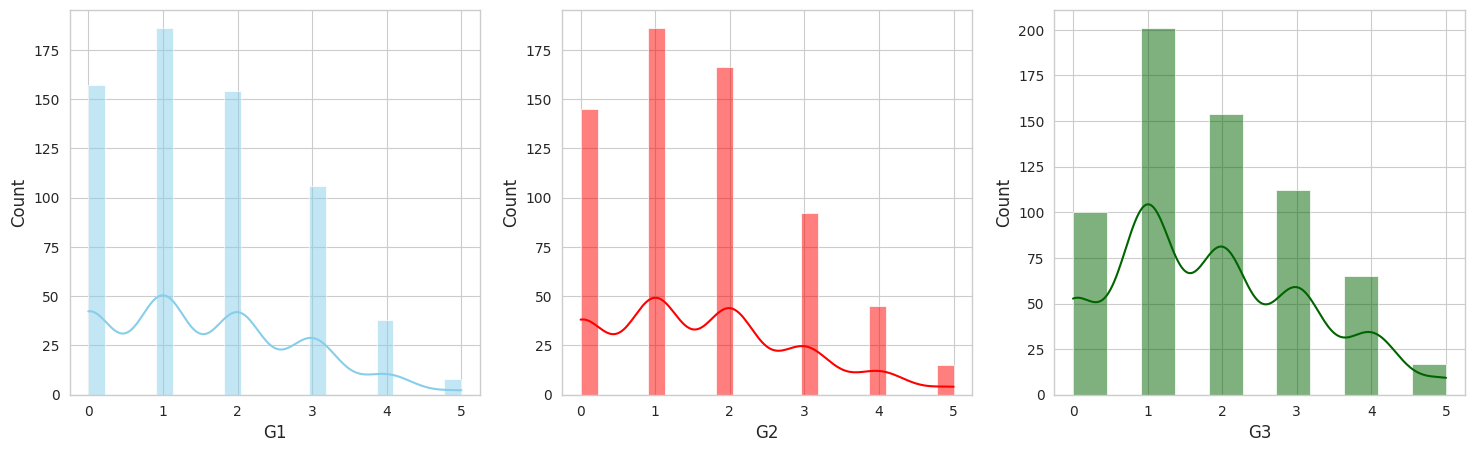

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.set_style("whitegrid")

sns.histplot(data=y_por_multiclass, x="G1", color="skyblue", label="Grade 1", kde=True, ax=axs[0])
sns.histplot(data=y_por_multiclass, x="G2", color="red", label="Grade 2", kde=True, ax=axs[1])
sns.histplot(data=y_por_multiclass, x="G3", color="darkgreen", label="Grade 3", kde=True, ax=axs[2])


In [ ]:
X_por_train_mc_g1, X_por_eval_mc_g1, y_por_train_mc_g1, y_por_eval_mc_g1 = train_test_split_by_grade(X_por_enc, y_por_multiclass, 'G1')
X_por_train_mc_g2, X_por_eval_mc_g2, y_por_train_mc_g2, y_por_eval_mc_g2 = train_test_split_by_grade(X_por_enc, y_por_multiclass, 'G2')
X_por_train_mc_g3, X_por_eval_mc_g3, y_por_train_mc_g3, y_por_eval_mc_g3 = train_test_split_by_grade(X_por_enc, y_por_multiclass, 'G3')

In [ ]:
# Only the hyperparameters of the selected model have been updated here
g1_best_model_list_multi = dict(
    logisticRegression = LogisticRegression(C=1, penalty='l2', solver='newton-cg'), 
    knn = KNeighborsClassifier(metric='minkowski', n_neighbors=1, p=5, weights='uniform'), 
    randomForest = RandomForestClassifier(max_features='log2', min_samples_leaf=2, min_samples_split=2, n_estimators=500), 
    svc = SVC(C=50, gamma='scale', kernel='poly'), 
    catb = CatBoostClassifier(depth=8, iterations=200, l2_leaf_reg=0.2, learning_rate=0.03, random_seed=123),#(task_type="GPU"), 
    xgb = XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=6, n_estimators=250)#tree_method='gpu_hist', gpu_id=0)
    )
g2_best_model_list_multi = dict(
    logisticRegression = LogisticRegression(C=100, penalty='l2', solver='newton-cg'), 
    knn = KNeighborsClassifier(metric='euclidean', n_neighbors=1, p=1, weights='uniform'), 
    randomForest = RandomForestClassifier(max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=123), 
    svc = SVC(C=10, gamma='scale', kernel='rbf'), 
    catb = CatBoostClassifier(depth=8, iterations=200, l2_leaf_reg=0.5, learning_rate=0.03),#(task_type="GPU"), 
    xgb = XGBClassifier(learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=250)#tree_method='gpu_hist', gpu_id=0)
    )
g3_best_model_list_multi = dict(
    logisticRegression = LogisticRegression(C=10, penalty='l2', solver='newton-cg'), 
    knn = KNeighborsClassifier(metric='manhattan', n_neighbors=1, p=1, weights='uniform'), 
    randomForest = RandomForestClassifier(max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=123), 
    svc = SVC(C=10, gamma='scale', kernel='rbf'), 
    catb = CatBoostClassifier(depth=8, iterations=200, l2_leaf_reg=0.5, learning_rate=0.1),#(task_type="GPU"), 
    xgb = XGBClassifier(learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=100)#tree_method='gpu_hist', gpu_id=0)
    )

#### Logistic regression

In [ ]:
lr_g1_multi, lr_predictions_g1_multi, lr_train_metrics_g1_multi, lr_test_metrics_g1_multi = get_model_predictions(X_por_train_mc_g1, X_por_eval_mc_g1, y_por_train_mc_g1, y_por_eval_mc_g1, 'G1', model_list['logisticRegression'], grid_params['logisticRegression'], True)

Predicting grade  G1
Hyperparameter finetuning of method LogisticRegression(random_state=123)
Best: 0.535892 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Getting predictions for grade  G1
Train performance
Accuracy: 0.65
Precision:  [0.70860927 0.47826087 0.54545455 0.46774194 0.68965517 0.96644295]
Recall:  [0.69480519 0.55345912 0.44117647 0.4084507  0.76433121 1.        ]
F1 score:  [0.70163934 0.51311953 0.48780488 0.43609023 0.72507553 0.98293515]
ROC-AUC score:  0.9065812171949096
F1 score (macro):  0.6411107772812011
F1 score (weighted):  0.642695359208621
ROC-AUC score (weighted) 0.9072162510664085
Test performance
Accuracy: 0.52
Precision: {:.2f} [0.5        0.15625    0.42105263 0.45454545 0.63636364 0.84782609]
Recall:  [0.65625    0.18518519 0.32       0.34090909 0.72413793 0.92857143]
F1 score:  [0.56756757 0.16949153 0.36363636 0.38961039 0.67741935 0.88636364]
ROC-AUC score:  0.8359932091848462
F1 score (macro):  0.5090148062400659
F1 score (weighted):  0.513

In [ ]:
lr_g2_multi, lr_predictions_g2_multi, lr_train_metrics_g2_multi, lr_test_metrics_g2_multi = get_model_predictions(X_por_train_mc_g2, X_por_eval_mc_g2, y_por_train_mc_g2, y_por_eval_mc_g2, 'G2', model_list['logisticRegression'], grid_params['logisticRegression'], True)

Predicting grade  G2
Hyperparameter finetuning of method LogisticRegression(random_state=123)
Best: 0.686008 using {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Getting predictions for grade  G2
Train performance
Accuracy: 0.80
Precision:  [0.77018634 0.67586207 0.70212766 0.75172414 0.87820513 1.        ]
Recall:  [0.82119205 0.64052288 0.68275862 0.76760563 0.87261146 1.        ]
F1 score:  [0.79487179 0.65771812 0.69230769 0.75958188 0.87539936 1.        ]
ROC-AUC score:  0.9655179490821116
F1 score (macro):  0.7966464750900536
F1 score (weighted):  0.7963446813359747
ROC-AUC score (weighted) 0.9655170025719697
Test performance
Accuracy: 0.72
Precision: {:.2f} [0.79310345 0.48648649 0.59090909 0.73170732 0.71875    1.        ]
Recall:  [0.65714286 0.54545455 0.63414634 0.68181818 0.79310345 0.97619048]
F1 score:  [0.71875    0.51428571 0.61176471 0.70588235 0.75409836 0.98795181]
ROC-AUC score:  0.9325621857536474
F1 score (macro):  0.7154554901656495
F1 score (weighted):  0.721

In [ ]:
lr_g3_multi, lr_predictions_g3_multi, lr_train_metrics_g3_multi, lr_test_metrics_g3_multi = get_model_predictions(X_por_train_mc_g3, X_por_eval_mc_g3, y_por_train_mc_g3, y_por_eval_mc_g3,'G3', model_list['logisticRegression'], grid_params['logisticRegression'], True)

Predicting grade  G3
Hyperparameter finetuning of method LogisticRegression(random_state=123)
Best: 0.758252 using {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Getting predictions for grade  G3
Train performance
Accuracy: 0.83
Precision:  [0.88888889 0.80246914 0.71794872 0.72327044 0.8427673  0.98192771]
Recall:  [0.88888889 0.80246914 0.70886076 0.68452381 0.88741722 1.        ]
F1 score:  [0.88888889 0.80246914 0.7133758  0.70336391 0.86451613 0.99088146]
ROC-AUC score:  0.9774829286374844
F1 score (macro):  0.8272492205402692
F1 score (weighted):  0.826695152184936
ROC-AUC score (weighted) 0.9773496580546615
Test performance
Accuracy: 0.78
Precision: {:.2f} [0.85       0.69047619 0.65714286 0.56097561 0.91304348 0.97368421]
Recall:  [0.87179487 0.74358974 0.53488372 0.6969697  0.84       0.97368421]
F1 score:  [0.86075949 0.71604938 0.58974359 0.62162162 0.875      0.97368421]
ROC-AUC score:  0.9514658891939339
F1 score (macro):  0.7728097163797439
F1 score (weighted):  0.77734724

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


#### Random forest

In [ ]:
rf_g1_multi, rf_predictions_g1_multi, rf_train_metrics_g1_multi, rf_test_metrics_g1_multi = get_model_predictions(X_por_train_mc_g1, X_por_eval_mc_g1, y_por_train_mc_g1, y_por_eval_mc_g1, 'G1', model_list['randomForest'], grid_params['randomForest'], True)

Predicting grade  G1
Hyperparameter finetuning of method RandomForestClassifier(random_state=123)
Best: 0.663612 using {'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Getting predictions for grade  G1
Train performance
Accuracy: 1.00
Precision:  [0.98717949 1.         1.         1.         0.98742138 1.        ]
Recall:  [1.         0.99371069 0.98529412 0.99295775 1.         1.        ]
F1 score:  [0.99354839 0.99684543 0.99259259 0.99646643 0.99367089 1.        ]
ROC-AUC score:  0.9998930588158045
F1 score (macro):  0.995520620454705
F1 score (weighted):  0.995517970008858
ROC-AUC score (weighted) 0.9998890766339713
Test performance
Accuracy: 0.62
Precision: {:.2f} [0.5106383  0.20689655 0.57692308 0.61904762 0.71428571 0.93333333]
Recall:  [0.75       0.22222222 0.3        0.59090909 0.86206897 1.        ]
F1 score:  [0.60759494 0.21428571 0.39473684 0.60465116 0.78125    0.96551724]
ROC-AUC score:  0.8884636826678314
F1 score (macro):  0

In [ ]:
rf_g2_multi, rf_predictions_g2_multi, rf_train_metrics_g2_multi, rf_test_metrics_g2_multi = get_model_predictions(X_por_train_mc_g2, X_por_eval_mc_g2, y_por_train_mc_g2, y_por_eval_mc_g2, 'G2', model_list['randomForest'], grid_params['randomForest'], True)

Predicting grade  G2
Hyperparameter finetuning of method RandomForestClassifier(random_state=123)
Best: 0.736526 using {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Getting predictions for grade  G2
Train performance
Accuracy: 0.99
Precision:  [0.9869281  1.         0.97959184 1.         1.         1.        ]
Recall:  [1.         0.98039216 0.99310345 0.99295775 1.         1.        ]
F1 score:  [0.99342105 0.99009901 0.98630137 0.99646643 1.         1.        ]
ROC-AUC score:  0.9998300721687764
F1 score (macro):  0.9943813105818314
F1 score (weighted):  0.9943987211972025
ROC-AUC score (weighted) 0.9998294292309323
Test performance
Accuracy: 0.75
Precision: {:.2f} [0.76923077 0.52       0.63414634 0.7173913  0.86206897 0.95454545]
Recall:  [0.85714286 0.39393939 0.63414634 0.75       0.86206897 1.        ]
F1 score:  [0.81081081 0.44827586 0.63414634 0.73333333 0.86206897 0.97674419]
ROC-AUC score:  0.946802440160211
F1 score (macro):  

In [ ]:
rf_g3_multi, rf_predictions_g3_multi, rf_train_metrics_g3_multi, rf_test_metrics_g3_multi = get_model_predictions(X_por_train_mc_g3, X_por_eval_mc_g3, y_por_train_mc_g3, y_por_eval_mc_g3, 'G3', model_list['randomForest'], grid_params['randomForest'], True)

Predicting grade  G3
Hyperparameter finetuning of method RandomForestClassifier(random_state=123)
Best: 0.845418 using {'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Getting predictions for grade  G3
Train performance
Accuracy: 1.00
Precision:  [1.         0.98170732 0.99367089 1.         1.         1.        ]
Recall:  [0.99382716 0.99382716 0.99367089 1.         0.99337748 1.        ]
F1 score:  [0.99690402 0.98773006 0.99367089 1.         0.99667774 1.        ]
ROC-AUC score:  0.9999766102649353
F1 score (macro):  0.9958304521762052
F1 score (weighted):  0.9958600215990312
ROC-AUC score (weighted) 0.9999767879581921
Test performance
Accuracy: 0.83
Precision: {:.2f} [0.7826087  0.71052632 0.84375    0.75       0.95918367 0.92682927]
Recall:  [0.92307692 0.69230769 0.62790698 0.81818182 0.94       1.        ]
F1 score:  [0.84705882 0.7012987  0.72       0.7826087  0.94949495 0.96202532]
ROC-AUC score:  0.9769708910572749
F1 score (macro): 

#### KNN

In [ ]:
knn_g1_multi, knn_predictions_g1_multi, knn_train_metrics_g1_multi, knn_test_metrics_g1_multi = get_model_predictions(X_por_train_mc_g1, X_por_eval_mc_g1, y_por_train_mc_g1, y_por_eval_mc_g1, 'G1', model_list['knn'], grid_params['knn'], True)

Predicting grade  G1
Hyperparameter finetuning of method KNeighborsClassifier()
Best: 0.645703 using {'metric': 'euclidean', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Getting predictions for grade  G1
Train performance
Accuracy: 1.00
Precision:  [1. 1. 1. 1. 1. 1.]
Recall:  [1. 1. 1. 1. 1. 1.]
F1 score:  [1. 1. 1. 1. 1. 1.]
ROC-AUC score:  1.0
F1 score (macro):  1.0
F1 score (weighted):  1.0
ROC-AUC score (weighted) 1.0
Test performance
Accuracy: 0.63
Precision: {:.2f} [0.54545455 0.1875     0.66666667 0.66       0.55769231 0.90697674]
Recall:  [0.5625     0.11111111 0.4        0.75       1.         0.92857143]
F1 score:  [0.55384615 0.13953488 0.5        0.70212766 0.71604938 0.91764706]
ROC-AUC score:  0.776352103602317
F1 score (macro):  0.5882008564468552
F1 score (weighted):  0.6102265373846977
ROC-AUC score (weighted) 0.7820213517726317


In [ ]:
(0.50704225 +0.34920635 +0.55696203+ 0.55263158+ 0.78723404 +0.92307692)/6

0.612692195

In [ ]:
knn_g2_multi, knn_predictions_g2_multi, knn_train_metrics_g2_multi, knn_test_metrics_g2_multi = get_model_predictions(X_por_train_mc_g2, X_por_eval_mc_g2, y_por_train_mc_g2, y_por_eval_mc_g2, 'G2', model_list['knn'], grid_params['knn'], True)

Predicting grade  G2
Hyperparameter finetuning of method KNeighborsClassifier()
Best: 0.700621 using {'metric': 'minkowski', 'n_neighbors': 1, 'p': 5, 'weights': 'uniform'}
Getting predictions for grade  G2
Train performance
Accuracy: 1.00
Precision:  [1. 1. 1. 1. 1. 1.]
Recall:  [1. 1. 1. 1. 1. 1.]
F1 score:  [1. 1. 1. 1. 1. 1.]
ROC-AUC score:  1.0
F1 score (macro):  1.0
F1 score (weighted):  1.0
ROC-AUC score (weighted) 1.0
Test performance
Accuracy: 0.73
Precision: {:.2f} [0.75       0.52       0.57142857 0.74468085 0.6744186  1.        ]
Recall:  [0.68571429 0.39393939 0.48780488 0.79545455 1.         1.        ]
F1 score:  [0.71641791 0.44827586 0.52631579 0.76923077 0.80555556 1.        ]
ROC-AUC score:  0.8364440903434818
F1 score (macro):  0.7109659811294559
F1 score (weighted):  0.7172051010697924
ROC-AUC score (weighted) 0.8372079904823876


In [ ]:
knn_g3_multi, knn_predictions_g3_multi, knn_train_metrics_g3_multi, knn_test_metrics_g3_multi = get_model_predictions(X_por_train_mc_g3, X_por_eval_mc_g3, y_por_train_mc_g3, y_por_eval_mc_g3,'G3', model_list['knn'], grid_params['knn'], True)

Predicting grade  G3
Hyperparameter finetuning of method KNeighborsClassifier()
Best: 0.812241 using {'metric': 'manhattan', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Getting predictions for grade  G3
Train performance
Accuracy: 1.00
Precision:  [1. 1. 1. 1. 1. 1.]
Recall:  [1. 1. 1. 1. 1. 1.]
F1 score:  [1. 1. 1. 1. 1. 1.]
ROC-AUC score:  1.0
F1 score (macro):  1.0
F1 score (weighted):  1.0
ROC-AUC score (weighted) 1.0
Test performance
Accuracy: 0.81
Precision: {:.2f} [0.82222222 0.67857143 0.675      0.725      0.95918367 0.95      ]
Recall:  [0.94871795 0.48717949 0.62790698 0.87878788 0.94       1.        ]
F1 score:  [0.88095238 0.56716418 0.65060241 0.79452055 0.94949495 0.97435897]
ROC-AUC score:  0.8883891373930398
F1 score (macro):  0.802848906915757
F1 score (weighted):  0.8064959340465107
ROC-AUC score (weighted) 0.8890386786434882


#### SVM

In [ ]:
svm_g1_multi, svm_predictions_g1_multi, svm_train_metrics_g1_multi, svm_test_metrics_g1_multi = get_model_predictions(X_por_train_mc_g1, X_por_eval_mc_g1, y_por_train_mc_g1, y_por_eval_mc_g1, 'G1', model_list['svm'], grid_params['svm'], True)

Predicting grade  G1
Hyperparameter finetuning of method SVC(probability=True, random_state=123)
Best: 0.566141 using {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
Getting predictions for grade  G1
Train performance
Accuracy: 0.83
Precision:  [0.82822086 0.74691358 0.73571429 0.75757576 0.88666667 0.99310345]
Recall:  [0.87662338 0.76100629 0.75735294 0.70422535 0.84713376 1.        ]
F1 score:  [0.85173502 0.75389408 0.74637681 0.72992701 0.86644951 0.99653979]
ROC-AUC score:  0.9605890609880327
F1 score (macro):  0.8241537032419038
F1 score (weighted):  0.8248066548369318
ROC-AUC score (weighted) 0.9609057620854378
Test performance
Accuracy: 0.55
Precision: {:.2f} [0.48888889 0.14285714 0.43243243 0.54054054 0.7        0.975     ]
Recall:  [0.6875     0.18518519 0.32       0.45454545 0.72413793 0.92857143]
F1 score:  [0.57142857 0.16129032 0.36781609 0.49382716 0.71186441 0.95121951]
ROC-AUC score:  0.8455217895126032
F1 score (macro):  0.5429076775719749
F1 score (weighted):  0.5506

In [ ]:
svm_g2_multi, svm_predictions_g2_multi, svm_train_metrics_g2_multi, svm_test_metrics_g2_multi = get_model_predictions(X_por_train_mc_g2, X_por_eval_mc_g2, y_por_train_mc_g2, y_por_eval_mc_g2, 'G2', model_list['svm'], grid_params['svm'], True)

Predicting grade  G2
Hyperparameter finetuning of method SVC(probability=True, random_state=123)
Best: 0.706252 using {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
Getting predictions for grade  G2
Train performance
Accuracy: 0.89
Precision:  [0.85625    0.82758621 0.83333333 0.90441176 0.94267516 1.        ]
Recall:  [0.90728477 0.78431373 0.86206897 0.86619718 0.94267516 1.        ]
F1 score:  [0.88102894 0.80536913 0.84745763 0.88489209 0.94267516 1.        ]
ROC-AUC score:  0.9870186996091412
F1 score (macro):  0.893570489851463
F1 score (weighted):  0.8932655588298015
ROC-AUC score (weighted) 0.9869860509238457
Test performance
Accuracy: 0.70
Precision: {:.2f} [0.70588235 0.46666667 0.52173913 0.69767442 0.76666667 1.        ]
Recall:  [0.68571429 0.42424242 0.58536585 0.68181818 0.79310345 0.97619048]
F1 score:  [0.69565217 0.44444444 0.55172414 0.68965517 0.77966102 0.98795181]
ROC-AUC score:  0.9252357602366738
F1 score (macro):  0.6915147921467307
F1 score (weighted):  0.69680

In [ ]:
svm_g3_multi, svm_predictions_g3_multi, svm_train_metrics_g3_multi, svm_test_metrics_g3_multi = get_model_predictions(X_por_train_mc_g3, X_por_eval_mc_g3, y_por_train_mc_g3, y_por_eval_mc_g3, 'G3', model_list['svm'], grid_params['svm'], True)

Predicting grade  G3
Hyperparameter finetuning of method SVC(probability=True, random_state=123)
Best: 0.781077 using {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
Getting predictions for grade  G3
Train performance
Accuracy: 0.93
Precision:  [0.95757576 0.91515152 0.86227545 0.93918919 0.92857143 0.98787879]
Recall:  [0.97530864 0.93209877 0.91139241 0.82738095 0.94701987 1.        ]
F1 score:  [0.96636086 0.9235474  0.88615385 0.87974684 0.93770492 0.99390244]
ROC-AUC score:  0.9953997160250881
F1 score (macro):  0.9312360492557992
F1 score (weighted):  0.9310938317897753
ROC-AUC score (weighted) 0.9953720939586191
Test performance
Accuracy: 0.81
Precision: {:.2f} [0.87179487 0.73809524 0.725      0.66666667 0.89583333 0.925     ]
Recall:  [0.87179487 0.79487179 0.6744186  0.66666667 0.86       0.97368421]
F1 score:  [0.87179487 0.7654321  0.69879518 0.66666667 0.87755102 0.94871795]
ROC-AUC score:  0.9697904001871706
F1 score (macro):  0.8048262978459957
F1 score (weighted):  0.80921

####CatBoost

In [ ]:
cb_g1_multi, cb_predictions_g1_multi, cb_train_metrics_g1_multi, cb_test_metrics_g1_multi = get_model_predictions(X_por_train_mc_g1, X_por_eval_mc_g1, y_por_train_mc_g1, y_por_eval_mc_g1, 'G1', model_list['catb'], grid_params['catb'], True)

Predicting grade  G1
Hyperparameter finetuning of method <catboost.core.CatBoostClassifier object at 0x7f7defe81ff0>
0:	learn: 1.7433776	total: 50.1ms	remaining: 9.96s
1:	learn: 1.7158567	total: 86.3ms	remaining: 8.54s
2:	learn: 1.6831958	total: 124ms	remaining: 8.12s
3:	learn: 1.6410143	total: 164ms	remaining: 8.02s
4:	learn: 1.6083398	total: 203ms	remaining: 7.92s
5:	learn: 1.5753136	total: 239ms	remaining: 7.74s
6:	learn: 1.5516838	total: 286ms	remaining: 7.88s
7:	learn: 1.5213274	total: 324ms	remaining: 7.78s
8:	learn: 1.4903479	total: 361ms	remaining: 7.66s
9:	learn: 1.4660778	total: 400ms	remaining: 7.6s
10:	learn: 1.4418818	total: 438ms	remaining: 7.52s
11:	learn: 1.4128709	total: 476ms	remaining: 7.46s
12:	learn: 1.3930467	total: 520ms	remaining: 7.48s
13:	learn: 1.3722262	total: 558ms	remaining: 7.42s
14:	learn: 1.3484979	total: 601ms	remaining: 7.42s
15:	learn: 1.3336432	total: 643ms	remaining: 7.39s
16:	learn: 1.3147146	total: 681ms	remaining: 7.33s
17:	learn: 1.2958405	tota

In [ ]:
cb_g2_multi, cb_predictions_g2_multi, cb_train_metrics_g2_multi, cb_test_metrics_g2_multi = get_model_predictions(X_por_train_mc_g2, X_por_eval_mc_g2, y_por_train_mc_g2, y_por_eval_mc_g2, 'G2', model_list['catb'], grid_params['catb'], True)

Predicting grade  G2
Hyperparameter finetuning of method <catboost.core.CatBoostClassifier object at 0x7f7defe81ff0>
0:	learn: 1.6247221	total: 25.5ms	remaining: 5.08s
1:	learn: 1.4888470	total: 58.9ms	remaining: 5.83s
2:	learn: 1.3667361	total: 82.5ms	remaining: 5.42s
3:	learn: 1.2789860	total: 106ms	remaining: 5.18s
4:	learn: 1.1945729	total: 132ms	remaining: 5.14s
5:	learn: 1.1318478	total: 157ms	remaining: 5.08s
6:	learn: 1.0703262	total: 181ms	remaining: 4.99s
7:	learn: 1.0195478	total: 205ms	remaining: 4.91s
8:	learn: 0.9700644	total: 231ms	remaining: 4.9s
9:	learn: 0.9288640	total: 255ms	remaining: 4.84s
10:	learn: 0.9011181	total: 278ms	remaining: 4.78s
11:	learn: 0.8642935	total: 302ms	remaining: 4.73s
12:	learn: 0.8290074	total: 325ms	remaining: 4.67s
13:	learn: 0.7982503	total: 350ms	remaining: 4.64s
14:	learn: 0.7644972	total: 383ms	remaining: 4.73s
15:	learn: 0.7368153	total: 407ms	remaining: 4.68s
16:	learn: 0.7099963	total: 430ms	remaining: 4.62s
17:	learn: 0.6827578	tot

In [ ]:
cb_g3_multi, cb_predictions_g3_multi, cb_train_metrics_g3_multi, cb_test_metrics_g3_multi = get_model_predictions(X_por_train_mc_g3, X_por_eval_mc_g3, y_por_train_mc_g3, y_por_eval_mc_g3, 'G3', model_list['catb'], grid_params['catb'], True)

Predicting grade  G3
Hyperparameter finetuning of method <catboost.core.CatBoostClassifier object at 0x7f7defe81ff0>
0:	learn: 1.5543295	total: 23.5ms	remaining: 4.68s
1:	learn: 1.4015112	total: 46.6ms	remaining: 4.61s
2:	learn: 1.2739807	total: 77.4ms	remaining: 5.08s
3:	learn: 1.1658882	total: 103ms	remaining: 5.05s
4:	learn: 1.0755240	total: 126ms	remaining: 4.91s
5:	learn: 1.0127574	total: 133ms	remaining: 4.3s
6:	learn: 0.9503831	total: 156ms	remaining: 4.31s
7:	learn: 0.9004116	total: 180ms	remaining: 4.31s
8:	learn: 0.8522977	total: 203ms	remaining: 4.3s
9:	learn: 0.8044806	total: 231ms	remaining: 4.39s
10:	learn: 0.7643956	total: 255ms	remaining: 4.39s
11:	learn: 0.7277320	total: 279ms	remaining: 4.37s
12:	learn: 0.6972479	total: 311ms	remaining: 4.47s
13:	learn: 0.6700753	total: 334ms	remaining: 4.44s
14:	learn: 0.6416275	total: 358ms	remaining: 4.41s
15:	learn: 0.6192435	total: 381ms	remaining: 4.38s
16:	learn: 0.5969915	total: 404ms	remaining: 4.34s
17:	learn: 0.5754869	tota

#### XGBoost

In [ ]:
xgb_g1_multi, xgb_predictions_g1_multi, xgb_train_metrics_g1_multi, xgb_test_metrics_g1_multi = get_model_predictions(X_por_train_mc_g1, X_por_eval_mc_g1, y_por_train_mc_g1, y_por_eval_mc_g1, 'G1', model_list['xgb'], grid_params['xgb'], True)

Predicting grade  G1
Hyperparameter finetuning of method XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=123, ...)
[21:41:52] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

Best: 0.637844 using {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500}


In [ ]:
xgb_g2_multi, xgb_predictions_g2_multi, xgb_train_metrics_g2_multi, xgb_test_metrics_g2_multi = get_model_predictions(X_por_train_mc_g2, X_por_eval_mc_g2, y_por_train_mc_g2, y_por_eval_mc_g2, 'G2', model_list['xgb'], grid_params['xgb'], True)

Predicting grade  G2
Hyperparameter finetuning of method XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=123, ...)
[22:17:35] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

Best: 0.728711 using {'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'n_estimators': 250}

In [ ]:
xgb_g3_multi, xgb_predictions_g3_multi, xgb_train_metrics_g3_multi, xgb_test_metrics_g3_multi = get_model_predictions(X_por_train_mc_g3, X_por_eval_mc_g3, y_por_train_mc_g3, y_por_eval_mc_g3, 'G3', model_list['xgb'], grid_params['xgb'], True)

Predicting grade  G3
Hyperparameter finetuning of method XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=123, ...)
[22:53:29] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

Best: 0.827769 using {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100}


#### Methods comparison

In [ ]:
lr_dict_multi = pd.DataFrame.from_dict(dict(G1=lr_test_metrics_g1_multi,G2=lr_test_metrics_g2_multi,G3=lr_test_metrics_g3_multi),
                       orient='index')
cb_dict_multi = pd.DataFrame.from_dict(dict(G1=cb_test_metrics_g1_multi,G2=cb_test_metrics_g2_multi,G3=cb_test_metrics_g3_multi),
                       orient='index')
rf_dict_multi = pd.DataFrame.from_dict(dict(G1=rf_test_metrics_g1_multi,G2=rf_test_metrics_g2_multi,G3=rf_test_metrics_g3_multi), 
                       orient='index')
svm_dict_multi = pd.DataFrame.from_dict(dict(G1=svm_test_metrics_g1_multi,G2=svm_test_metrics_g2_multi,G3=svm_test_metrics_g3_multi),
                       orient='index')
knn_dict_multi = pd.DataFrame.from_dict(dict(G1=knn_test_metrics_g1_multi,G2=knn_test_metrics_g2_multi,G3=knn_test_metrics_g3_multi),
                       orient='index')
xgb_dict_multi = pd.DataFrame.from_dict(dict(G1=xgb_test_metrics_g1_multi,G2=xgb_test_metrics_g2_multi,G3=xgb_test_metrics_g3_multi),
                       orient='index')

In [ ]:
pd.concat([lr_dict_multi, cb_dict_multi, rf_dict_multi, svm_dict_multi, knn_dict_multi, xgb_dict_multi],
          keys=['Logistic Regression', 'CatBoost', 'Random Forest', 'SVM', 'KNN Classifier', 'XGBoost'], 
          axis=1).round(3)

Logistic Regression                                                     \
              accuracy                                          precision   
G1               0.522  [0.5, 0.15625, 0.42105263157894735, 0.45454545...   
G2               0.719  [0.7931034482758621, 0.4864864864864865, 0.590...   
G3               0.777  [0.85, 0.6904761904761905, 0.6571428571428571,...   

                                                       \
                                               recall   
G1  [0.65625, 0.18518518518518517, 0.32, 0.3409090...   
G2  [0.6571428571428571, 0.5454545454545454, 0.634...   
G3  [0.8717948717948718, 0.7435897435897436, 0.534...   

                                                                           \
                                                   f1              labels   
G1  [0.5675675675675675, 0.1694915254237288, 0.363...  [0, 1, 2, 3, 4, 5]   
G2  [0.71875, 0.5142857142857143, 0.61176470588235...  [0, 1, 2, 3, 4, 5]   
G3  [0.8607594936708861, 0.7160493827160495, 0.589...  [0, 1, 2, 3, 4, 5]   

          CatBoost                                                     \
      roc accuracy                                          precision   
G1  0.836    0.629  [0.5348837209302325, 0.16666666666666666, 0.57...   
G2  0.933    0.746  [0.7272727272727273, 0.48148148148148145, 0.61...   
G3  0.951    0.810  [0.7777777777777778, 0.6923076923076923, 0.818...   

                                                       \
                                               recall   
G1  [0.71875, 0.18518518518518517, 0.46, 0.5227272...   
G2  [0.6857142857142857, 0.3939393939393939, 0.658...   
G3  [0.8974358974358975, 0.6923076923076923, 0.627...   

                                                                           \
                                                   f1              labels   
G1  [0.6133333333333333, 0.17543859649122806, 0.51...  [0, 1, 2, 3, 4, 5]   
G2  [0.7058823529411764, 0.43333333333333324, 0.63...  [0, 1, 2, 3, 4, 5]   
G3  [0.8333333333333333, 0.6923076923076923, 0.710...  [0, 1, 2, 3, 4, 5]   

          Random Forest                                                     \
      roc      accuracy                                          precision   
G1  0.883         0.616  [0.5106382978723404, 0.20689655172413793, 0.57...   
G2  0.948         0.754  [0.7692307692307693, 0.52, 0.6341463414634146,...   
G3  0.975         0.835  [0.782608695652174, 0.7105263157894737, 0.8437...   

                                                       \
                                               recall   
G1  [0.75, 0.2222222222222222, 0.3, 0.590909090909...   
G2  [0.8571428571428571, 0.3939393939393939, 0.634...   
G3  [0.9230769230769231, 0.6923076923076923, 0.627...   

                                                                           \
                                                   f1              labels   
G1  [0.6075949367088608, 0.2142857142857143, 0.394...  [0, 1, 2, 3, 4, 5]   
G2  [0.8108108108108107, 0.44827586206896547, 0.63...  [0, 1, 2, 3, 4, 5]   
G3  [0.8470588235294118, 0.7012987012987013, 0.72,...  [0, 1, 2, 3, 4, 5]   

               SVM                                                     \
      roc accuracy                                          precision   
G1  0.888    0.549  [0.4888888888888889, 0.14285714285714285, 0.43...   
G2  0.947    0.696  [0.7058823529411765, 0.4666666666666667, 0.521...   
G3  0.977    0.810  [0.8717948717948718, 0.7380952380952381, 0.725...   

                                                       \
                                               recall   
G1  [0.6875, 0.18518518518518517, 0.32, 0.45454545...   
G2  [0.6857142857142857, 0.42424242424242425, 0.58...   
G3  [0.8717948717948718, 0.7948717948717948, 0.674...   

                                                                           \
                                                   f1              labels   
G1  [0.5714285714285714, 0.16129032258

Observations (accuracy & F1):
- G1: **CatBoost**
- G2: **RandomForest**
- G3: **XGBoost**

# Confidence

* Prediction probabilities
* Jackknife resampling technique (CI) -> https://jmlr.org/papers/volume15/wager14a/wager14a.pdf
* U-statistics (CI) -> https://www.jmlr.org/papers/volume17/14-168/14-168.pdf
* Quintile Random Forest (prediction intervals) -> https://jmlr.org/papers/volume7/meinshausen06a/meinshausen06a.pdf

In [ ]:
from forestci import random_forest_error

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [ ]:
# Calculate the variance
m = g3_best_model_list_multi['randomForest']
X_train, y_train, X_test, y_test = prepare_datasets( X_enc_por, y_por, X_enc_mat, y_mat,'multiclass', 'G3')
m.fit(X_train, y_train)
binary_V_IJ = random_forest_error(m, X_train,X_test.values.ravel())

# Explainability

## Prepare math dataset

In [ ]:
# binary models
# Only the hyperparameters of the selected model for G3 have been updated here
g1_best_model_list = dict(
    logisticRegression = LogisticRegression(C=100, penalty='l2', solver='liblinear'), 
    knn = KNeighborsClassifier(metric='manhattan', n_neighbors=1, p=1, weights='uniform'), 
    randomForest = RandomForestClassifier(max_features='log2', min_samples_leaf=2, min_samples_split=5, n_estimators=500), 
    svc = SVC(C=10, gamma='scale', kernel='rbf'), 
    catb = CatBoostClassifier(depth=6, iterations=200, l2_leaf_reg=0.2, learning_rate=0.1),#(task_type="GPU"), 
    xgb = XGBClassifier(learning_rate=0.1, max_depth=3, min_child_weight=6, n_estimators=250)#tree_method='gpu_hist', gpu_id=0)
    )
g2_best_model_list = dict(
    logisticRegression = LogisticRegression(C=1, penalty='l2', solver='newton-cg'), 
    knn = KNeighborsClassifier(metric='manhattan', n_neighbors=1, p=1, weights='uniform'), 
    randomForest = RandomForestClassifier(max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=500), 
    svc = SVC(C=50, gamma='scale', kernel='rbf'), 
    catb = CatBoostClassifier(depth=6, iterations=150, l2_leaf_reg=0.2, learning_rate=0.1),#(task_type="GPU"), 
    xgb = XGBClassifier(learning_rate=0.1, max_depth=3, min_child_weight=6, n_estimators=250)#tree_method='gpu_hist', gpu_id=0)
    )
g3_best_model_list = dict(
    logisticRegression = LogisticRegression(C=1, penalty='l2', solver='lbfgs'), 
    knn = KNeighborsClassifier(metric='manhattan', n_neighbors=3, p=1, weights='uniform'), 
    randomForest = RandomForestClassifier(max_features='log2', min_samples_leaf=2, min_samples_split=2, n_estimators=100),
    svc = SVC(C=50, gamma='scale', kernel='rbf', random_state=123, probability=True), 
    catb = CatBoostClassifier(depth=8, iterations=100, l2_leaf_reg=0.5, learning_rate=0.1),#(task_type="GPU"), 
    xgb = XGBClassifier(learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=100)#tree_method='gpu_hist', gpu_id=0)
    )

# multiclass models
# Only the hyperparameters of the selected model have been updated here
g1_best_model_list_multi = dict(
    logisticRegression = LogisticRegression(C=1, penalty='l2', solver='newton-cg'), 
    knn = KNeighborsClassifier(metric='minkowski', n_neighbors=1, p=5, weights='uniform'), 
    randomForest = RandomForestClassifier(max_features='log2', min_samples_leaf=2, min_samples_split=2, n_estimators=500), 
    svc = SVC(C=50, gamma='scale', kernel='poly'), 
    catb = CatBoostClassifier(depth=8, iterations=200, l2_leaf_reg=0.2, learning_rate=0.03, random_seed=123),#(task_type="GPU"), 
    xgb = XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=6, n_estimators=250)#tree_method='gpu_hist', gpu_id=0)
    )
g2_best_model_list_multi = dict(
    logisticRegression = LogisticRegression(C=100, penalty='l2', solver='newton-cg'), 
    knn = KNeighborsClassifier(metric='euclidean', n_neighbors=1, p=1, weights='uniform'), 
    randomForest = RandomForestClassifier(max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=100, random_state=123), 
    svc = SVC(C=10, gamma='scale', kernel='rbf'), 
    catb = CatBoostClassifier(depth=8, iterations=200, l2_leaf_reg=0.5, learning_rate=0.03),#(task_type="GPU"), 
    xgb = XGBClassifier(learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=250)#tree_method='gpu_hist', gpu_id=0)
    )
g3_best_model_list_multi = dict(
    logisticRegression = LogisticRegression(C=10, penalty='l2', solver='newton-cg'), 
    knn = KNeighborsClassifier(metric='manhattan', n_neighbors=1, p=1, weights='uniform'), 
    randomForest = RandomForestClassifier(max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=123), 
    svc = SVC(C=10, gamma='scale', kernel='rbf'), 
    catb = CatBoostClassifier(depth=8, iterations=200, l2_leaf_reg=0.5, learning_rate=0.1),#(task_type="GPU"), 
    xgb = XGBClassifier(learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=100)#tree_method='gpu_hist', gpu_id=0)
    )

In [ ]:
def preprocess_df(df):
  y = df[['G1','G2','G3']]
  X = df.drop(columns=['G1','G2','G3'])

  cat_cols = X.columns[X.dtypes == "object"].values

  numeric_cols = X.columns[X.dtypes != "object"].values
  nominal_cols = [] # 4
  binary_cols = [] # 14
  for c in X.columns[X.dtypes == "object"].values:
    if len(X[c].unique()) == 2:
      binary_cols.append(c)
    else:
      nominal_cols.append(c)

  # we keep track of the original feature values so that we can use them during the explanation part
  X_enc = X.copy()
  enc_bin = OrdinalEncoder( dtype=int)
  X_enc[binary_cols] = enc_bin.fit_transform(X_enc[binary_cols])

  X_enc = pd.get_dummies(X_enc, 
                            columns=nominal_cols, 
                            drop_first=False)
  return X, y, X_enc

In [ ]:
def prepare_datasets(X_train, y_train, X_test, y_test, classificationType, grade):
  # adjust target classes
  if classificationType == 'binary':
    y_train = y_train.applymap(binarize)
    y_test = y_test.applymap(binarize)
  else:
    y_train = y_train.applymap(grades_to_multiclass)
    y_test = y_test.applymap(grades_to_multiclass)
  
  # adjust datasets
  if grade == 'G1':
    y_train = y_train[['G1']]
    y_test = y_test[['G1']]
  elif grade == 'G2':
    X_train = X_train.merge(y_train[['G1']], left_index=True, right_index=True)
    X_test = X_test.merge(y_test[['G1']], left_index=True, right_index=True)
    y_train = y_train[['G2']]
    y_test = y_test[['G2']]
  elif grade == 'G3':
    X_train = X_train.merge(y_train[['G1','G2']], left_index=True, right_index=True)
    X_test = X_test.merge(y_test[['G1','G2']], left_index=True, right_index=True)
    y_train = y_train[['G3']]
    y_test = y_test[['G3']]
  
  return X_train, y_train, X_test, y_test

In [ ]:
def get_classification_predictions(classificationType, X_train, y_train, X_test, y_test, print_train_scores):
    
  # initialize best model with best parameters
  if classificationType=='binary':
    # only predict G3 since it makes sense only there
    models = [g3_best_model_list['svc']]
    grades = ['G3']
    targets = ['Fail','Pass']
    datasets_list = []
    for g in grades:
      datasets_list.append(prepare_datasets(X_train, y_train, X_test, y_test, classificationType, g))
  else:
    models = [g1_best_model_list_multi['catb'], g2_best_model_list_multi['randomForest'], g3_best_model_list_multi['randomForest']]
    grades = ['G1', 'G2','G3']
    targets = ['Fail','E', 'D', 'C', 'B', 'A']
    datasets_list = []
    for g in grades:
      datasets_list.append(prepare_datasets(X_train, y_train, X_test, y_test, classificationType, g))
  
  # fit the models on the training dataset (portuguese)
  for i in range(len(models)):
    m = models[i]
    print('Performing ', classificationType, ' classification for grade ', i, ' through model ', m)
    X, y = datasets_list[i][0],  datasets_list[i][1]
    m.fit(X, y.values.ravel())
    if print_train_scores:
      y_pred = m.predict(X)
      y_probs = m.predict_proba(X)
      print('Accuracy score: ', accuracy_score(y, y_pred))
      if classificationType=='binary':
        print('ROC-AUC score: ', roc_auc_score(y, y_probs[:, 1]))
      else:
        print('ROC-AUC score (macro): ', roc_auc_score(y, y_probs, multi_class='ovr'))
        print('ROC-AUC score (micro): ', roc_auc_score(y, y_probs, multi_class='ovr', average='micro'))
      print('Classification report for grade ', grades[i], ' (TRAIN):')
      print(classification_report(y, y_pred, target_names=targets))
  

  # get predictions for the test set (mathematics)
  grade_predictions = []
  grade_probs = []
  for i in range(len(models)):
    print('\nPredictions for grade ', grades[i])
    m = models[i]
    X_test, y_test = datasets_list[i][2],  datasets_list[i][3]
    # class predictions
    y_pred = m.predict(X_test)
    grade_predictions.append(y_pred)
    # class probabilities
    y_probs = m.predict_proba(X_test)
    grade_probs.append(y_probs)
    # print metrics
    print('Accuracy score: ', accuracy_score(y_test, y_pred))
    if classificationType=='binary':
      print('ROC-AUC score: ', roc_auc_score(y_test, y_probs[:, 1]))
    else:
      print('ROC-AUC score (macro): ', roc_auc_score(y_test, y_probs, multi_class='ovr'))
      print('ROC-AUC score (micro): ', roc_auc_score(y_test, y_probs, multi_class='ovr', average='micro'))
    print('Classification report (TEST):')
    print(classification_report(y_test, y_pred, target_names=targets))
    # print('Confusion matrix:')
    # print(confusion_matrix(y_test, y_pred, labels=targets))

  return models, datasets_list, grade_predictions, grade_probs

In [ ]:
X_mat, y_mat, X_enc_mat  = preprocess_df(df_mat)
X_por, y_por, X_enc_por  = preprocess_df(df_por)

In [ ]:
binary_models, binary_datasets, binary_preds, binary_probs = get_classification_predictions('binary', X_enc_por, y_por, X_enc_mat, y_mat, True)

Performing  binary  classification for grade  0  through model  SVC(C=50, probability=True, random_state=123)
Accuracy score:  0.9645608628659477
ROC-AUC score:  0.9871948998178506
Classification report for grade  G3  (TRAIN):
              precision    recall  f1-score   support

        Fail       0.91      0.86      0.88       100
        Pass       0.97      0.98      0.98       549

    accuracy                           0.96       649
   macro avg       0.94      0.92      0.93       649
weighted avg       0.96      0.96      0.96       649


Predictions for grade  G3
Accuracy score:  0.8177215189873418
ROC-AUC score:  0.9016255442670538
Classification report (TEST):
              precision    recall  f1-score   support

        Fail       0.80      0.59      0.68       130
        Pass       0.82      0.93      0.87       265

    accuracy                           0.82       395
   macro avg       0.81      0.76      0.78       395
weighted avg       0.82      0.82      0.81   

In [ ]:
mc_models, mc_datasets, mc_preds, mc_probs = get_classification_predictions('multiclass', X_enc_por, y_por, X_enc_mat, y_mat, True)

Performing  multiclass  classification for grade  0  through model  <catboost.core.CatBoostClassifier object at 0x7f7b338a8a30>
0:	learn: 1.7602208	total: 20.9ms	remaining: 4.15s
1:	learn: 1.7378172	total: 35.8ms	remaining: 3.54s
2:	learn: 1.7088971	total: 50.6ms	remaining: 3.32s
3:	learn: 1.6805797	total: 69.4ms	remaining: 3.4s
4:	learn: 1.6545053	total: 84.7ms	remaining: 3.3s
5:	learn: 1.6349199	total: 105ms	remaining: 3.4s
6:	learn: 1.6114201	total: 120ms	remaining: 3.31s
7:	learn: 1.5891763	total: 146ms	remaining: 3.5s
8:	learn: 1.5648399	total: 163ms	remaining: 3.46s
9:	learn: 1.5399209	total: 183ms	remaining: 3.48s
10:	learn: 1.5223659	total: 204ms	remaining: 3.51s
11:	learn: 1.5039544	total: 219ms	remaining: 3.43s
12:	learn: 1.4885434	total: 234ms	remaining: 3.37s
13:	learn: 1.4781015	total: 236ms	remaining: 3.13s
14:	learn: 1.4604298	total: 250ms	remaining: 3.09s
15:	learn: 1.4422635	total: 268ms	remaining: 3.08s
16:	learn: 1.4214907	total: 284ms	remaining: 3.06s
17:	learn: 1.4

### ROC-AUC

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
def get_micro_macro_roc(y_test, probs, n_classes):
  # MICRO-AVERAGE
  # store the fpr, tpr, and roc_auc for all averaging strategies
  fpr, tpr, roc_auc = dict(), dict(), dict()
  # Compute micro-average ROC curve and ROC area
  #fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), mc_probs[0].ravel())
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # MACRO-AVERAGE
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  fpr_grid = np.linspace(0.0, 1.0, 1000)

  # Interpolate all ROC curves at these points
  mean_tpr = np.zeros_like(fpr_grid)

  for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

  # Average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = fpr_grid
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  return fpr, tpr, roc_auc

In [ ]:
def get_roc_auc_by_grade(classificationType, g, y_probs, datasets):
  # datasets[grades][X_train, y_train, X_test, y_test]
  # y_probs[grades]

  if (classificationType == 'multiclass') and (g == 'G2'):
    probs = y_probs[1]
    label_binarizer = LabelBinarizer().fit(datasets[1][1])
    y_onehot_test = label_binarizer.transform(datasets[1][3])
    n_classes = len(np.unique(datasets[1][3]))
  elif (classificationType == 'multiclass') and (g == 'G3'):
    probs = y_probs[2]
    label_binarizer = LabelBinarizer().fit(datasets[2][1])
    y_onehot_test = label_binarizer.transform(datasets[2][3])
    n_classes = len(np.unique(datasets[2][3]))
  elif (classificationType == 'multiclass') and (g == 'G1'):
    probs = y_probs[0]
    label_binarizer = LabelBinarizer().fit(datasets[0][1])
    y_onehot_test = label_binarizer.transform(datasets[0][3])
    n_classes = len(np.unique(datasets[0][3])) 
  else:
    # binary case --> DOES NOT WORK
    probs = y_probs[0][:,0]
    print(probs.size)
    label_binarizer = LabelBinarizer().fit(datasets[0][1])
    y_onehot_test = label_binarizer.transform(datasets[0][3])
    n_classes = len(np.unique(datasets[0][3]))

  fpr, tpr, roc_auc = get_micro_macro_roc(y_onehot_test, probs, n_classes)

  fig, ax = plt.subplots(figsize=(6, 6))

  plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
  )

  plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
  )

  if classificationType == 'binary':
    colors = ['darkorange','deepskyblue']
    target_names = ['Fail', 'Pass']
  else:
    colors = ["red", "darkorange", "gold", 'greenyellow', 'deepskyblue', 'mediumslateblue']
    target_names = ['Fail','E', 'D', 'C', 'B', 'A']
  for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        probs[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

  plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
  plt.axis("square")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  title = "Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass (Grade " + g + ")"
  plt.title(title)
  plt.legend()
  plt.show()
  return


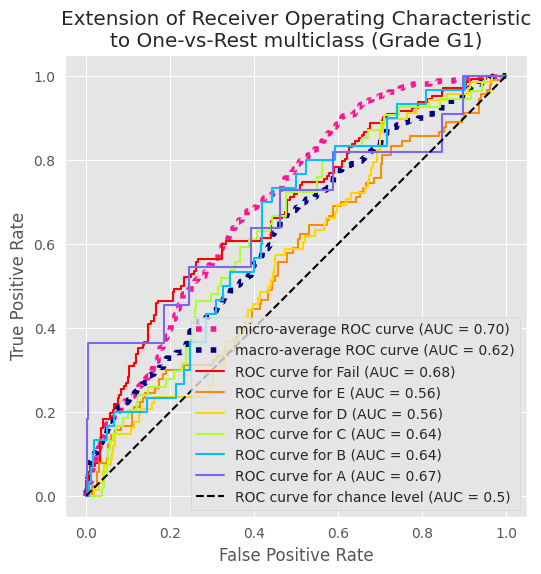

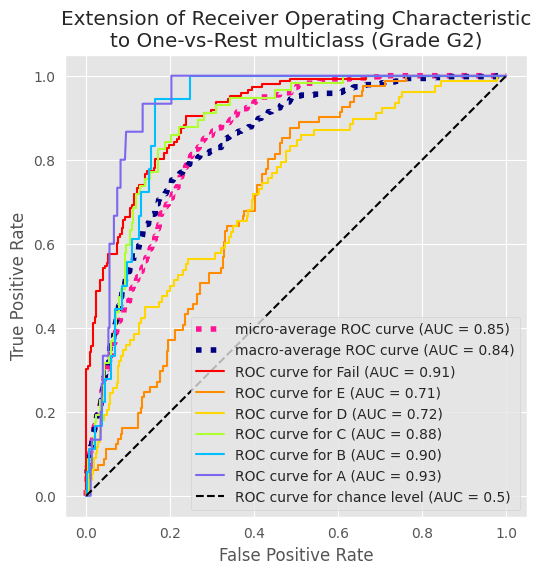

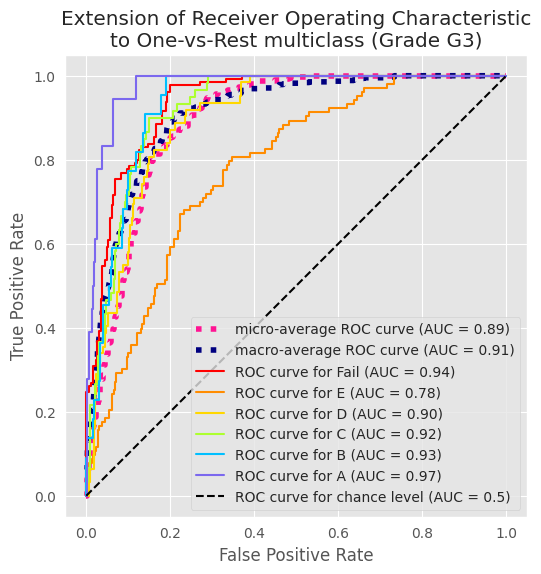

In [ ]:
#plt.subplot(1, 3, 1)
get_roc_auc_by_grade('multiclass', 'G1', mc_probs, mc_datasets)
#plt.subplot(1, 3, 2)
get_roc_auc_by_grade('multiclass', 'G2', mc_probs, mc_datasets)
#plt.subplot(1, 3, 3)
get_roc_auc_by_grade('multiclass', 'G3', mc_probs, mc_datasets)

## RF feature importance

### Binary

**Feature importance based on mean decrease in impurity.**

Feature importances are provided by the fitted attribute *feature_importances_* and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

Impurity-based feature importances can be misleading for high cardinality features (many unique values). See Permutation feature importance as an alternative below.

In [ ]:
importances = binary_models[0].feature_importances_
std = np.std([tree.feature_importances_ for tree in binary_models[0].estimators_], axis=0)
#f_names = list(X_enc_mat.columns)+['G1','G2']
forest_importances = pd.Series(importances, index=binary_datasets[0][0].columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Feature importance based on feature permutation.**

Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

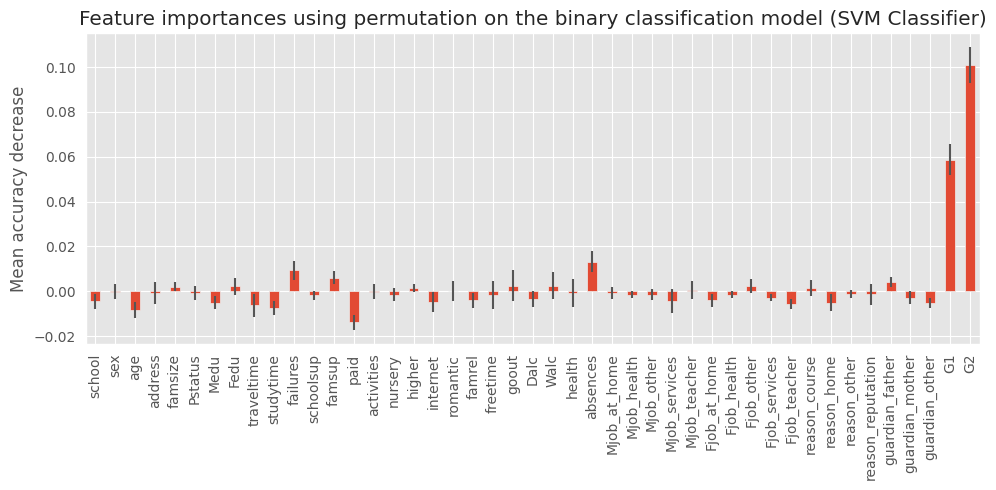

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    #mc_models[0], mc_datasets[0][2], mc_datasets[0][3], n_repeats=10, random_state=42, n_jobs=2
    binary_models[0], binary_datasets[0][2], binary_datasets[0][3], n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=binary_datasets[0][0].columns)
fig, ax = plt.subplots(figsize=(10,5))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on the binary classification model (SVM Classifier)")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Multiclass

## Built-in feature importance (impurity-based)
In **gradient boosting algorithms** (e.g., XGBoost, CatBoost), importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for. The performance measure may be the purity (Gini index) used to select the split points or another more specific error function.
The feature importances are then averaged across all of the the decision trees within the model.
- XGBoost computes the *gain* importance metric, i.e., the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model. Specifically, gain is the improvement in accuracy brought by a feature to the branches it is on.
- CatBoost computes the *PredictionValuesChange*, wich shows how much on average the prediction changes if the feature value changes. The bigger the value of the importance the bigger on average is the change to the prediction value, if this feature is changed.
- Random Forest computes the feature importance as the mean and standard deviation of accumulation of the impurity decrease within each tree.

**Impurity-based feature importances can be misleading for high cardinality features (many unique values). See Permutation feature importance as an alternative.**

### Binary

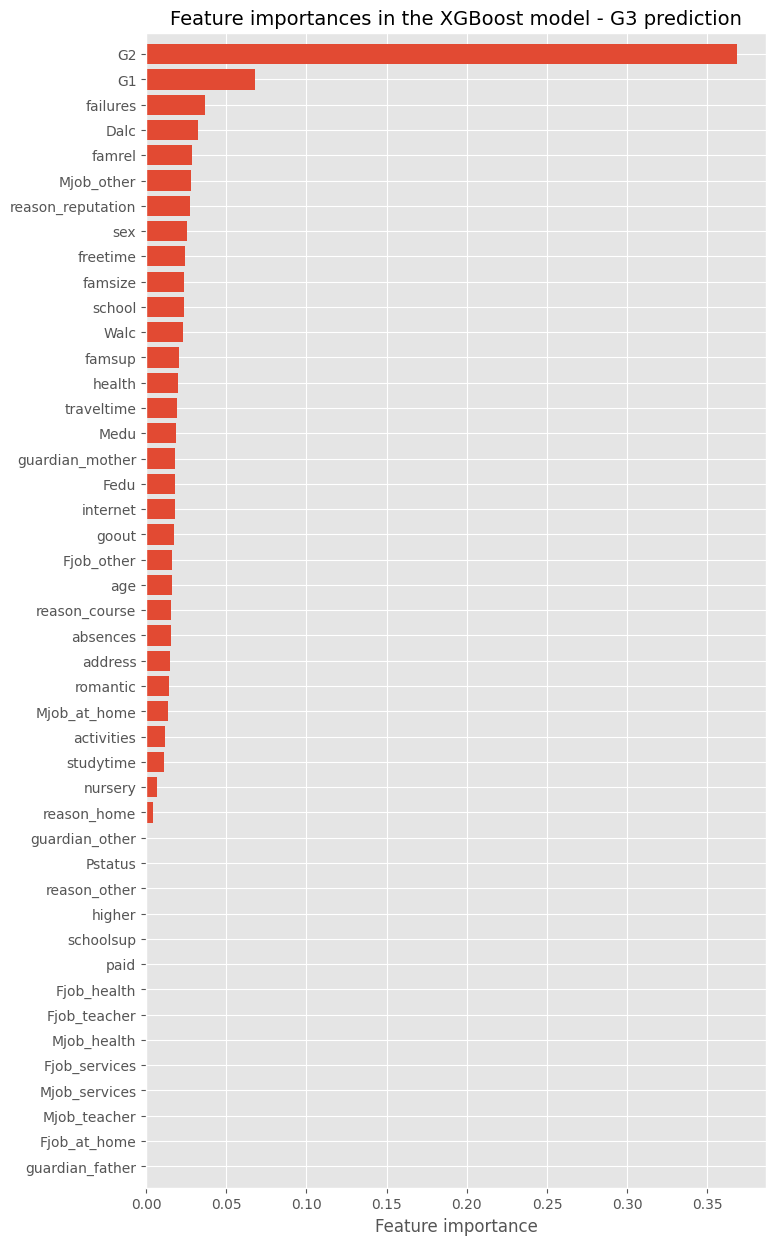

In [ ]:
# Producing a dataframe of feature importances
col_names = list(X_enc_mat.columns) + ['G1','G2']
ft_weights_xgb_reg = pd.DataFrame(binary_models[0].feature_importances_, columns=['weight'], index=col_names)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,15))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model - G3 prediction", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [ ]:
not_important_features_binary_g3 = list(ft_weights_xgb_reg[ft_weights_xgb_reg['weight'] == 0].index)
not_important_features_binary_g3

['guardian_father',
 'Fjob_at_home',
 'Mjob_teacher',
 'Mjob_services',
 'Fjob_services',
 'Mjob_health',
 'Fjob_teacher',
 'Fjob_health',
 'paid',
 'schoolsup',
 'higher',
 'reason_other',
 'Pstatus',
 'guardian_other']

### Multiclass

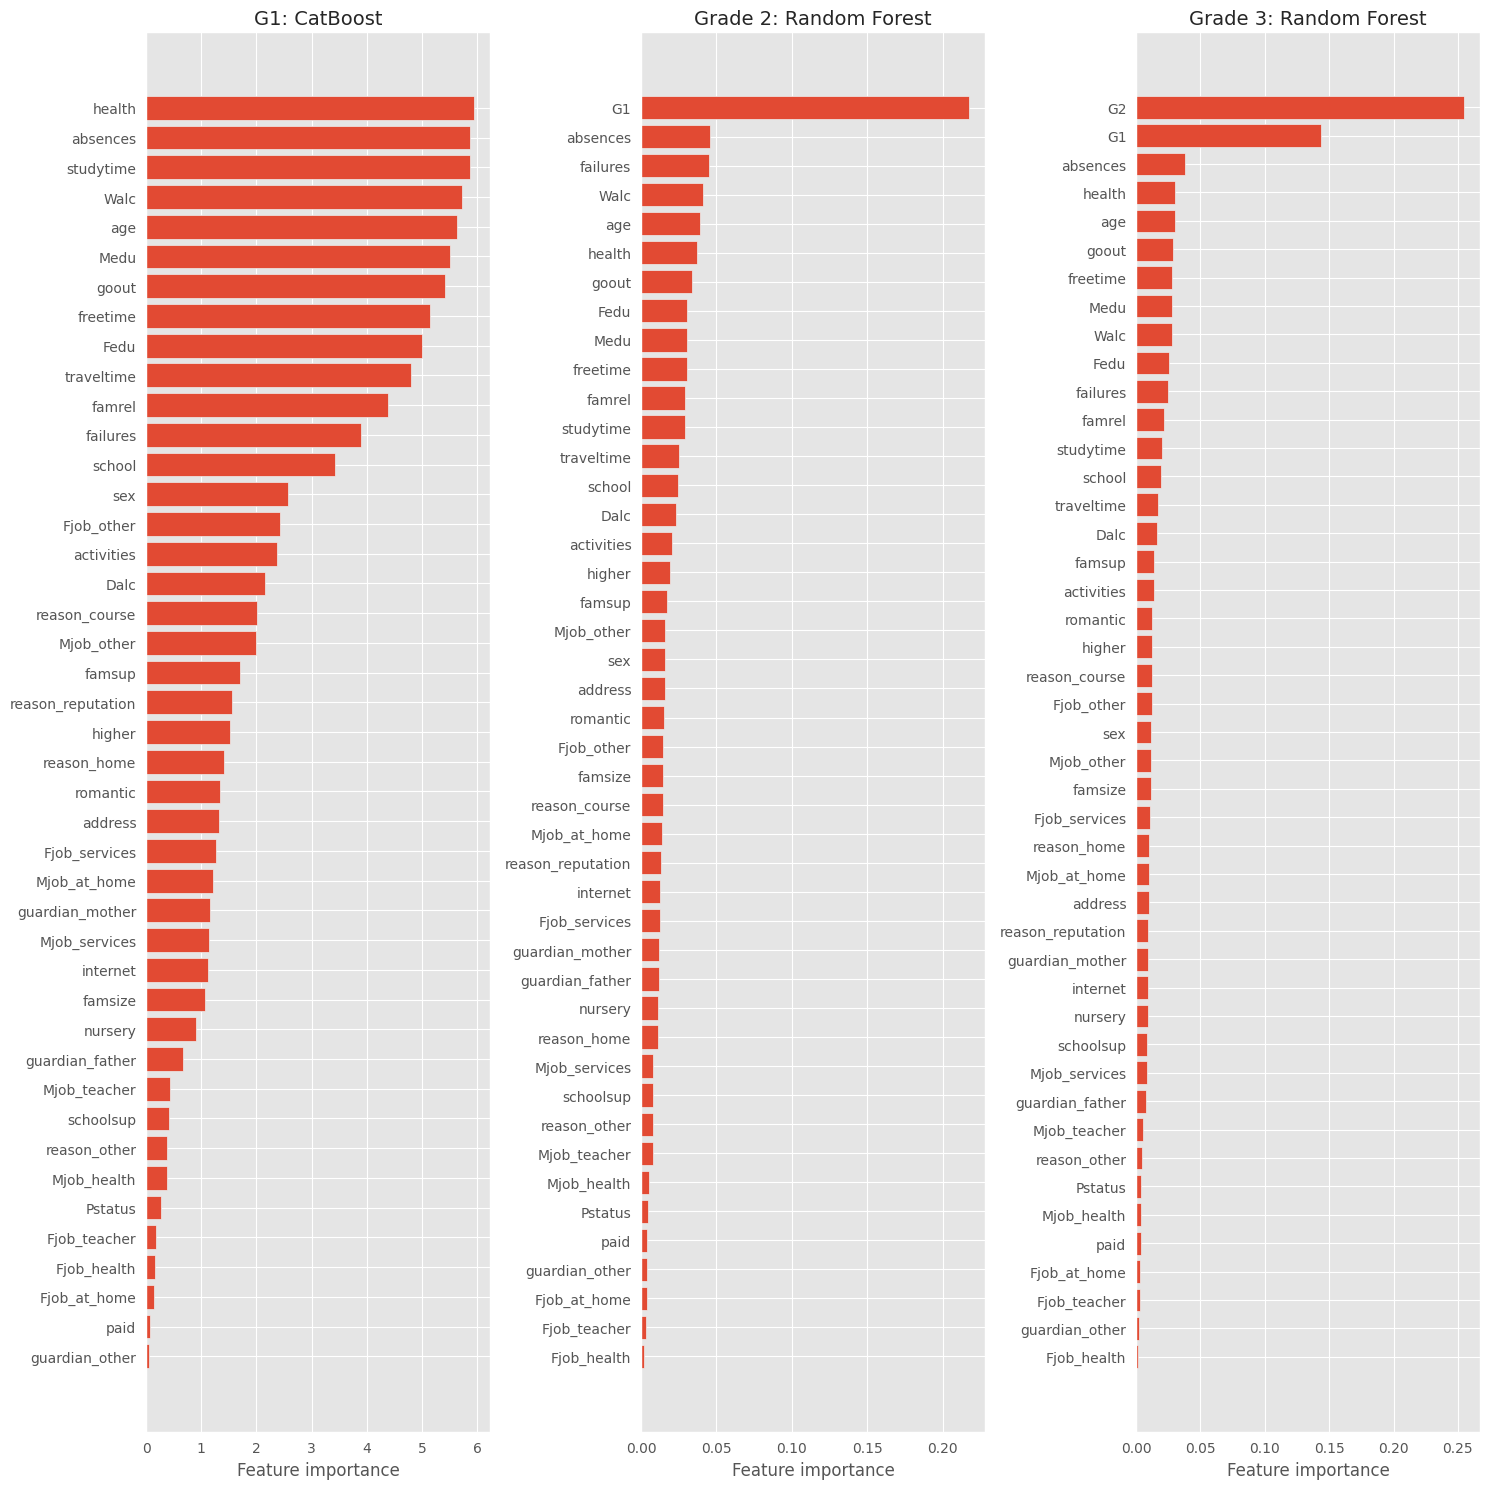

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
#fig.suptitle('Feature importance for multiclass prediction (built-in methods)')
# Producing a dataframe of feature importances
col_names = list(X_enc_mat.columns) 
ft_weights_g1 = pd.DataFrame(mc_models[0].feature_importances_, columns=['weight'], index=col_names)
ft_weights_g1.sort_values('weight', inplace=True)

# Plotting feature importances
#plt.figure(figsize=(8,15))
ax1.barh(ft_weights_g1.index, ft_weights_g1.weight, align='center') 
ax1.set_title("G1: CatBoost", fontsize=14)
ax1.set_xlabel("Feature importance")

# Producing a dataframe of feature importances
col_names = list(X_enc_mat.columns) + ['G1']
ft_weights_g2 = pd.DataFrame(mc_models[1].feature_importances_, columns=['weight'], index=col_names)
ft_weights_g2.sort_values('weight', inplace=True)

# Plotting feature importances
#plt.figure(figsize=(8,15))
ax2.barh(ft_weights_g2.index, ft_weights_g2.weight, align='center') 
ax2.set_title("Grade 2: Random Forest", fontsize=14)
ax2.set_xlabel("Feature importance")

# Producing a dataframe of feature importances
col_names = list(X_enc_mat.columns) + ['G1','G2']
ft_weights_g3 = pd.DataFrame(mc_models[2].feature_importances_, columns=['weight'], index=col_names)
ft_weights_g3.sort_values('weight', inplace=True)

# Plotting feature importances
#plt.figure(figsize=(8,15))
ax3.barh(ft_weights_g3.index, ft_weights_g3.weight, align='center') 
ax3.set_title("Grade 3: Random Forest", fontsize=14)
ax3.set_xlabel("Feature importance")

fig.tight_layout()
plt.show()

In [ ]:
# All weights are different from 0!!
not_important_features_mc_g1 = list(ft_weights_g1[ft_weights_g1['weight'] == 0].index)
not_important_features_mc_g2 = list(ft_weights_g2[ft_weights_g2['weight'] == 0].index)
not_important_features_mc_g3 = list(ft_weights_g3[ft_weights_g3['weight'] == 0].index)

## SHAP Global

In [ ]:
X_enc_mat_g2 = X_enc_mat.merge(y_mat[['G1']], left_index=True, right_index=True)
X_enc_mat_g3 = X_enc_mat.merge(y_mat[['G1','G2']], left_index=True, right_index=True)

### Binary
- G1 and G2 have the highest impact independently on their value.
- The school where the students are enrolled has high impact and there's also a clear separation of values: students enrolled in school 0 are predicted to have more probability of passing, while the contrary happens for those in school 1.
- Students that do go out with friends either very much or not at all are less likely to fail.
- 

In [ ]:
m = binary_models[0]

In [ ]:
# Create object that can calculate shap values
#expl_binary_g3 = shap.TreeExplainer(binary_models[0])
expl_binary_g3 = shap.KernelExplainer(binary_models[0].predict_proba, shap.sample(binary_datasets[0][0], 100))
# Calculate Shap values
shap_values_binary = expl_binary_g3.shap_values(X_enc_mat_g3)

  0%|          | 0/395 [00:00<?, ?it/s]

In [ ]:
shap_binary_interaction_values = expl_binary_g3.shap_interaction_values(X_enc_mat_g3)

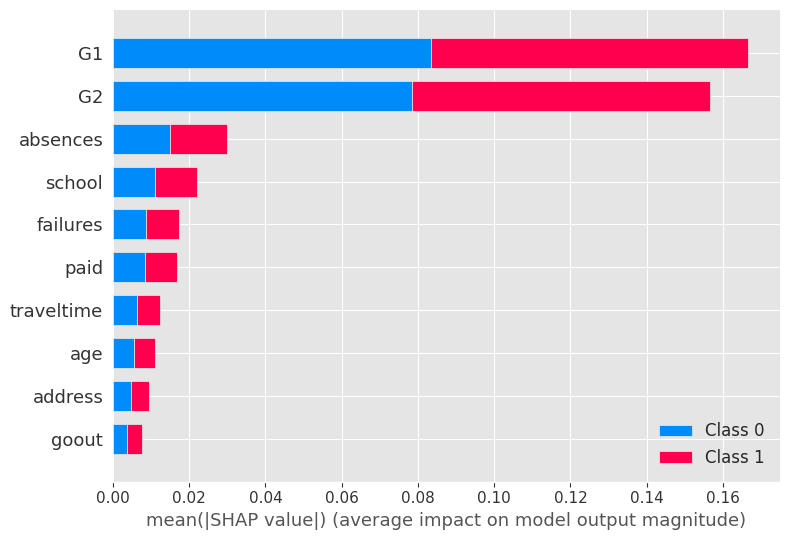

In [ ]:
shap.summary_plot(shap_values_binary, X_enc_mat_g3, feature_names=X_enc_mat_g3.columns, max_display=10)#, plot_size=None, show=False)

In [ ]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(expl_binary_g3.expected_value, shap_values_binary, X_enc_mat_g3)

**Partial dependence.**
The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features have on the predicted outcome of a machine learning model.Note that the PDP assumes that the first feature is not correlated with the second feature. If this assumption is violated, the averages calculated for the partial dependence plot will include data points that are very unlikely or even impossible.

Text(0.5, 1.0, "Effect of 'weekend alchool consumption' on the prediction of G3")

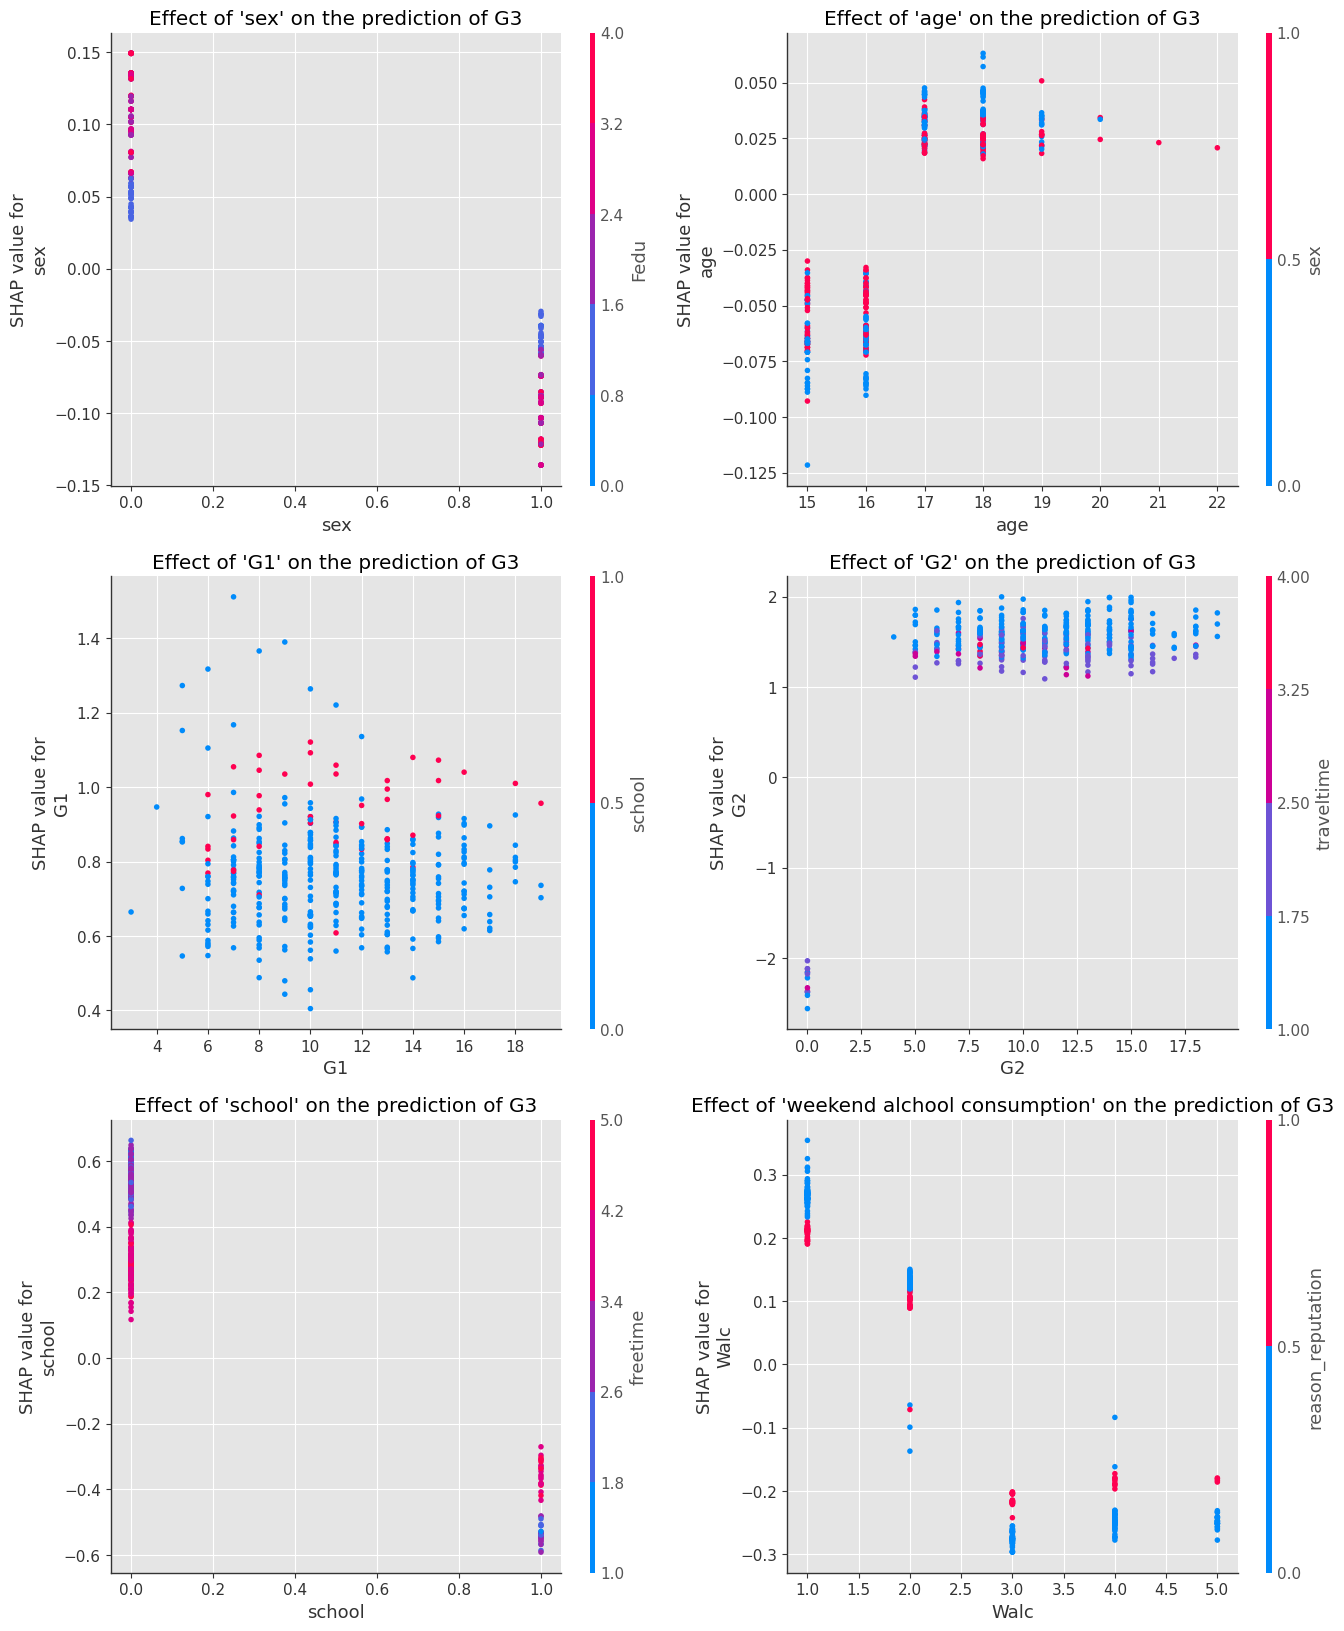

In [ ]:
# make plots colored by each of the top three possible interacting features (might differ for the seasonal and h1n1)
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(16,20))

shap.dependence_plot('sex', shap_values_binary, X_enc_mat_g3, 
                     #interaction_index='sex', 
                     ax=ax[0][0], show=False)
ax[0][0].set_title("Effect of 'sex' on the prediction of G3")
  
shap.dependence_plot('age', shap_values_binary, X_enc_mat_g3, 
                     #interaction_index='sex', 
                     ax=ax[0][1], show=False)
ax[0][1].set_title("Effect of 'age' on the prediction of G3")

shap.dependence_plot('G1', shap_values_binary, X_enc_mat_g3,
                     #interaction_index='Dalc', 
                     ax=ax[1][0], show=False)
ax[1][0].set_title("Effect of 'G1' on the prediction of G3")
  
shap.dependence_plot('G2', shap_values_binary, X_enc_mat_g3, 
                     #interaction_index='Dalc', 
                     ax=ax[1][1], show=False)
ax[1][1].set_title("Effect of 'G2' on the prediction of G3")

shap.dependence_plot('school', shap_values_binary, X_enc_mat_g3, 
                     #interaction_index='age', 
                     ax=ax[2][0], show=False)
ax[2][0].set_title("Effect of 'school' on the prediction of G3")
  
shap.dependence_plot('Walc', shap_values_binary, X_enc_mat_g3, 
                     #interaction_index='age',
                     ax=ax[2][1], show=False)
ax[2][1].set_title("Effect of 'weekend alchool consumption' on the prediction of G3")

### Multiclass

In [ ]:
class_names=['Fail','E','D','C','B','A']

In [ ]:
# Create object that can calculate shap values
expl_mc_g1 = shap.TreeExplainer(mc_models[0])
expl_mc_g2 = shap.TreeExplainer(mc_models[1])
expl_mc_g3 = shap.TreeExplainer(mc_models[2])
# Calculate Shap values
shap_values_mc_g1 = expl_mc_g1.shap_values(X_enc_mat)
shap_values_mc_g2 = expl_mc_g2.shap_values(X_enc_mat_g2)
shap_values_mc_g3 = expl_mc_g3.shap_values(X_enc_mat_g3)

In the summary plot for multiclass classification the impact of a feature on the classes is stacked to create the feature importance plot. Thus, it helps visualize the different impact of features to each class.

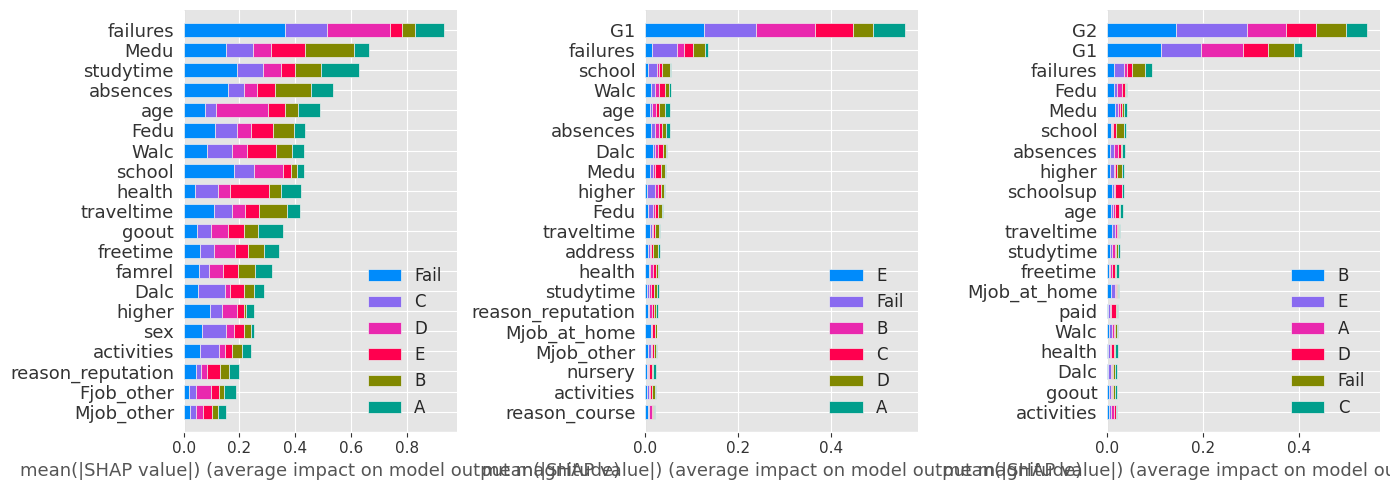

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
shap.summary_plot(shap_values_mc_g1, X_enc_mat, feature_names=X_enc_mat.columns, show=False, plot_size=None, class_names=class_names)
plt.subplot(1,3,2)
shap.summary_plot(shap_values_mc_g2, X_enc_mat_g2, feature_names=X_enc_mat_g2.columns, show=False, plot_size=None, class_names=class_names)
plt.subplot(1,3,3)
shap.summary_plot(shap_values_mc_g3, X_enc_mat_g3, feature_names=X_enc_mat_g3.columns, show=False, plot_size=None, class_names=class_names)
plt.tight_layout()
plt.show()
# on the x axis there is |mean(shap value)|, i.e., average impact on model output magnitude 

**Partial dependence plot**

In [ ]:
def plot_scatter_mc_by_feature(feature, grade, shap_values, data):
  fig, ax = plt.subplots(nrows=1, ncols=6,figsize=(26,4))
  title = "Effect of "+ feature.upper() + " on the prediction of " + grade + ", divided by grade"
  fig.suptitle(title, fontsize=16)

  shap.dependence_plot(feature, shap_values[0], data, ax=ax[0], show=False)
  ax[0].set_title("FAIL")

  shap.dependence_plot(feature, shap_values[1], data, ax=ax[1], show=False)
  ax[1].set_title("Grade E")
  ax[1].set_ylabel('')

  shap.dependence_plot(feature, shap_values[2], data, ax=ax[2], show=False)
  ax[2].set_title("Grade D")
  ax[2].set_ylabel('')

  shap.dependence_plot(feature, shap_values[3], data, ax=ax[3], show=False)
  ax[3].set_title("Grade C")
  ax[3].set_ylabel('')

  shap.dependence_plot(feature, shap_values[4], data, ax=ax[4], show=False)
  ax[4].set_title("Grade B")
  ax[4].set_ylabel('')

  shap.dependence_plot(feature, shap_values[5], data, ax=ax[5], show=False)
  ax[5].set_title("Grade A")
  ax[5].set_ylabel('')

  fig.tight_layout()

**SEX**

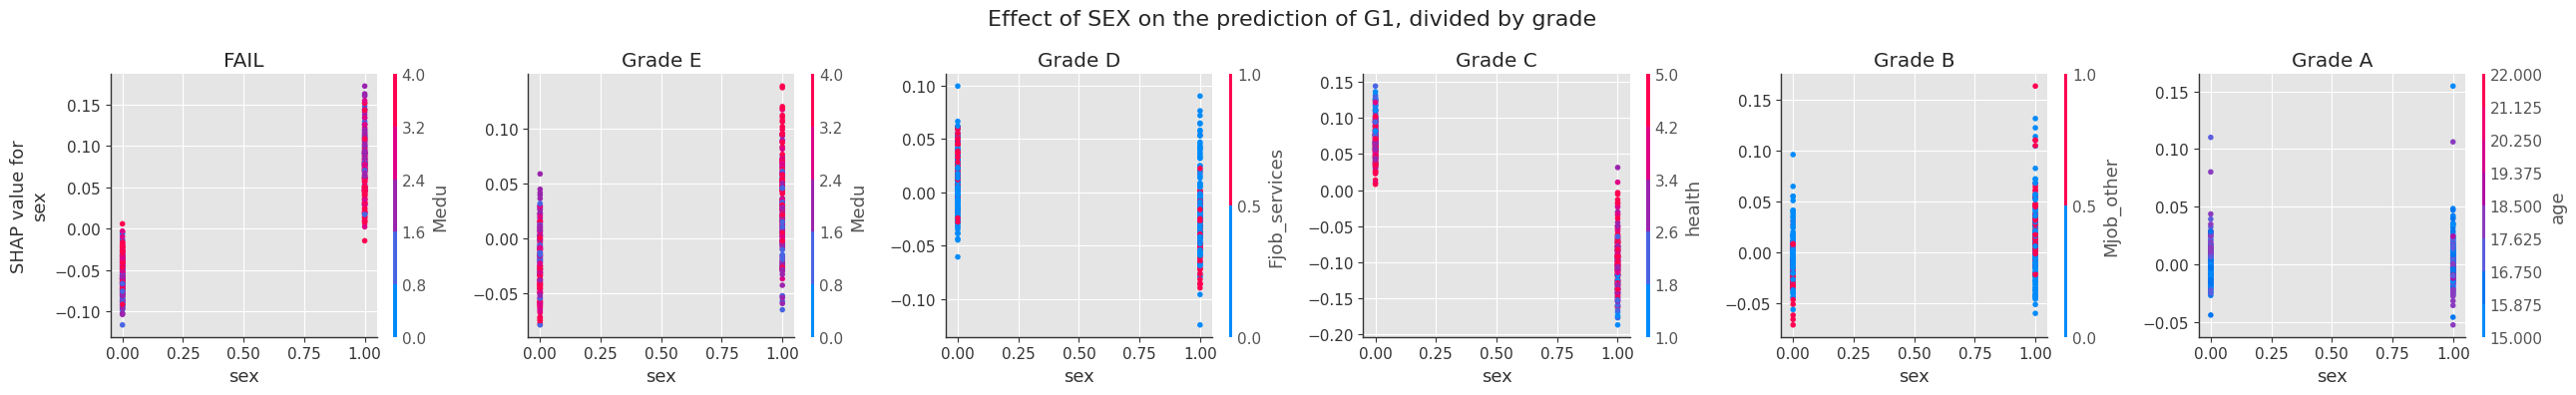

In [ ]:
plot_scatter_mc_by_feature('sex', 'G1', shap_values_mc_g1, X_enc_mat)

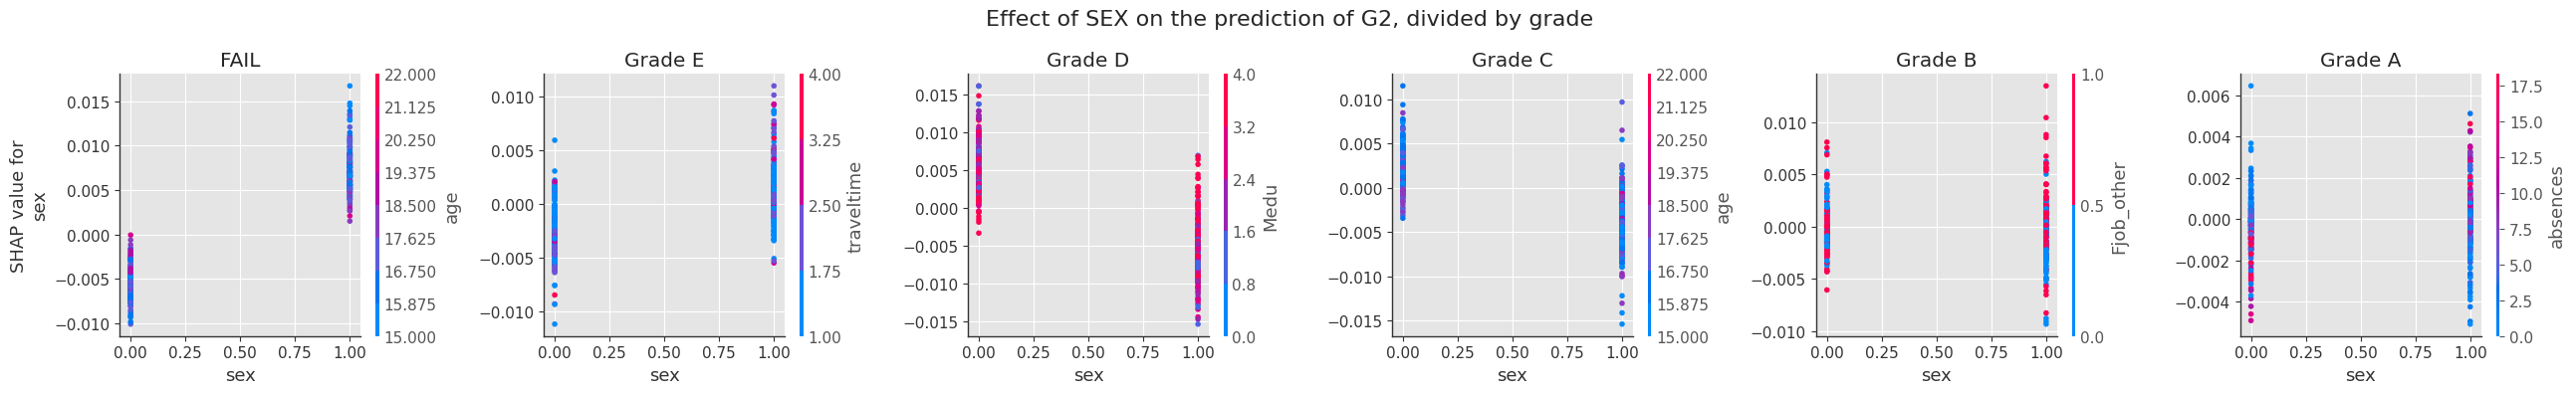

In [ ]:
plot_scatter_mc_by_feature('sex', 'G2', shap_values_mc_g2, X_enc_mat_g2)

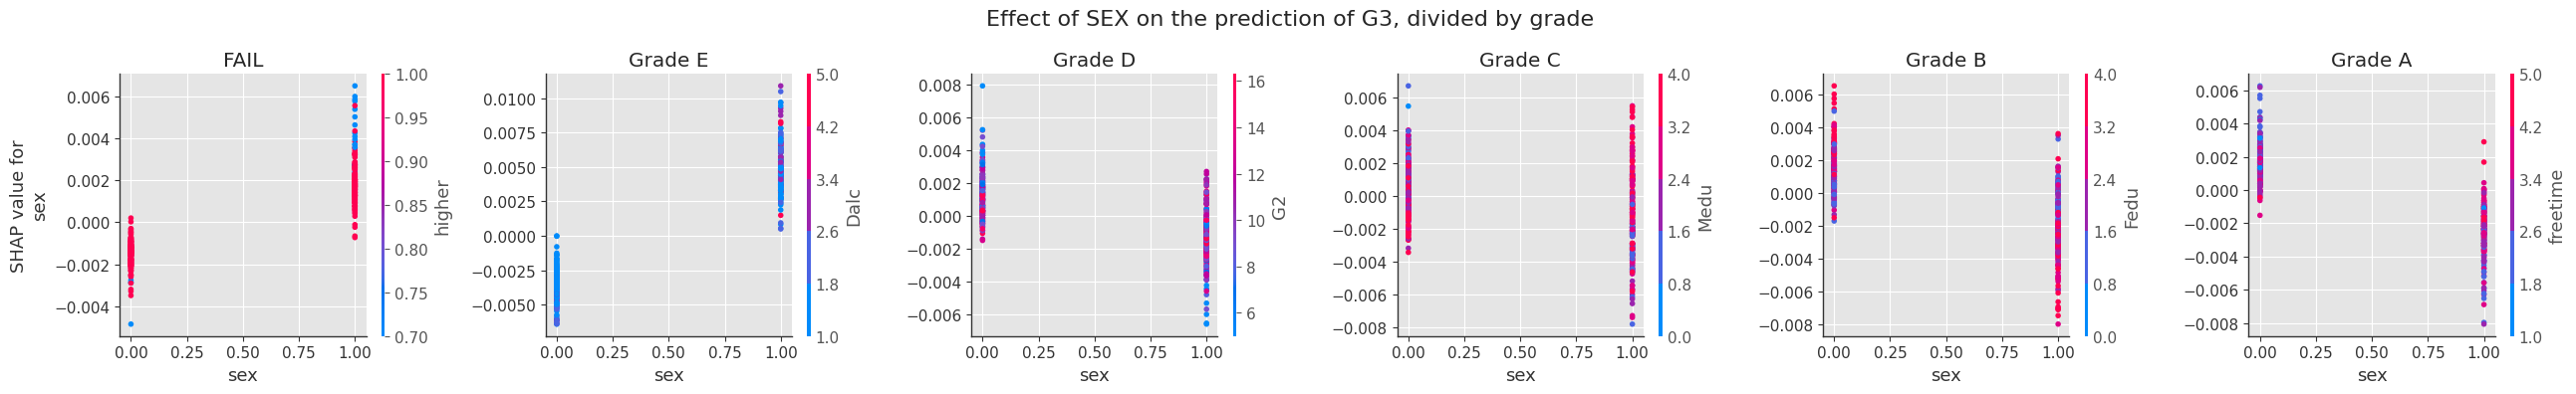

In [ ]:
plot_scatter_mc_by_feature('sex', 'G3', shap_values_mc_g3, X_enc_mat_g3)

**AGE**

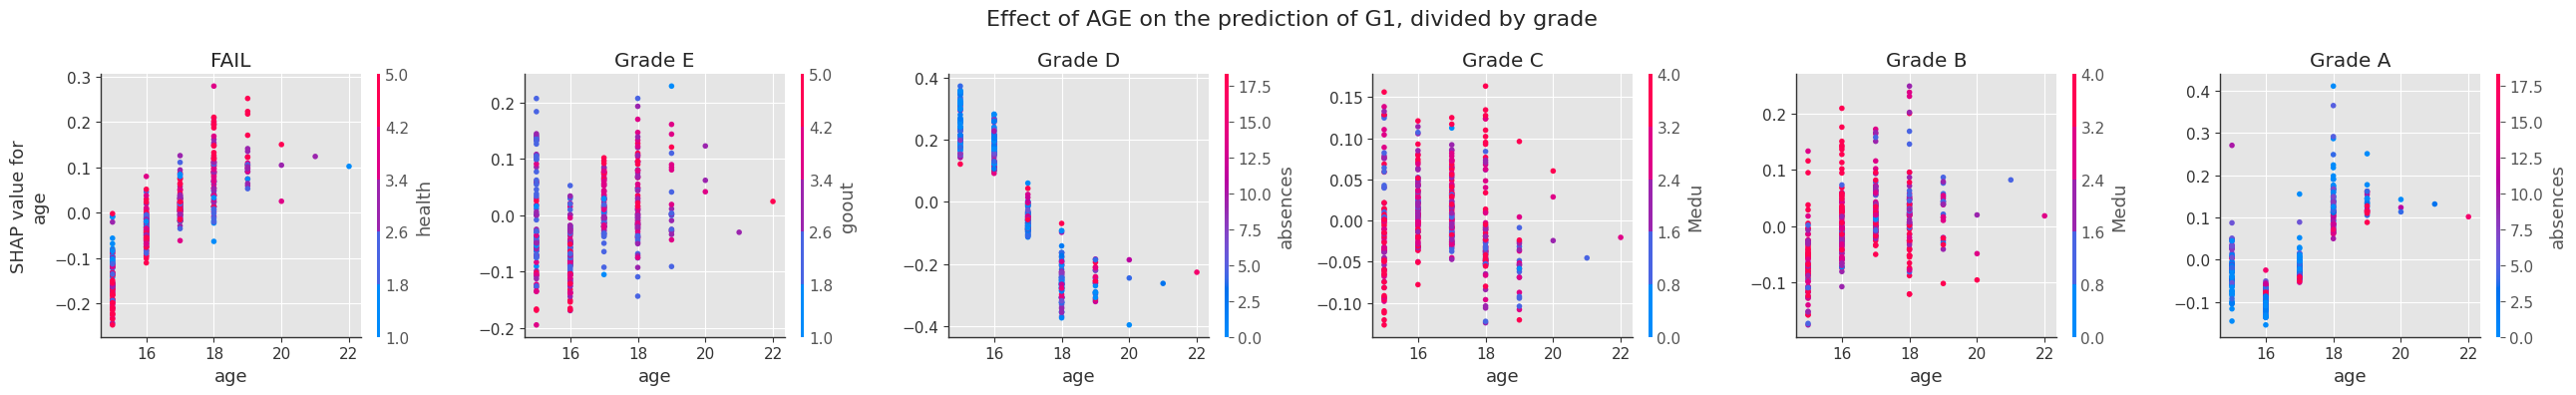

In [ ]:
plot_scatter_mc_by_feature('age', 'G1', shap_values_mc_g1, X_enc_mat)

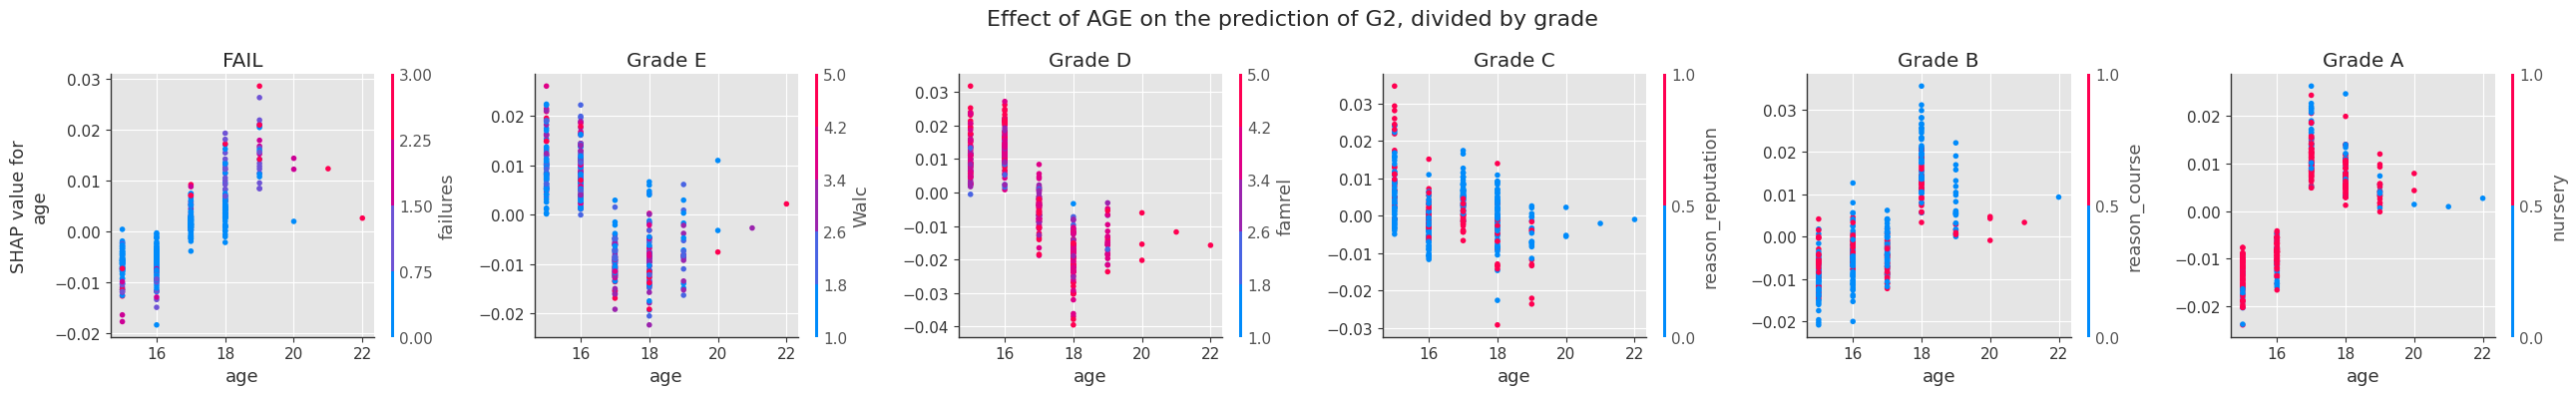

In [ ]:
plot_scatter_mc_by_feature('age', 'G2', shap_values_mc_g2, X_enc_mat_g2)

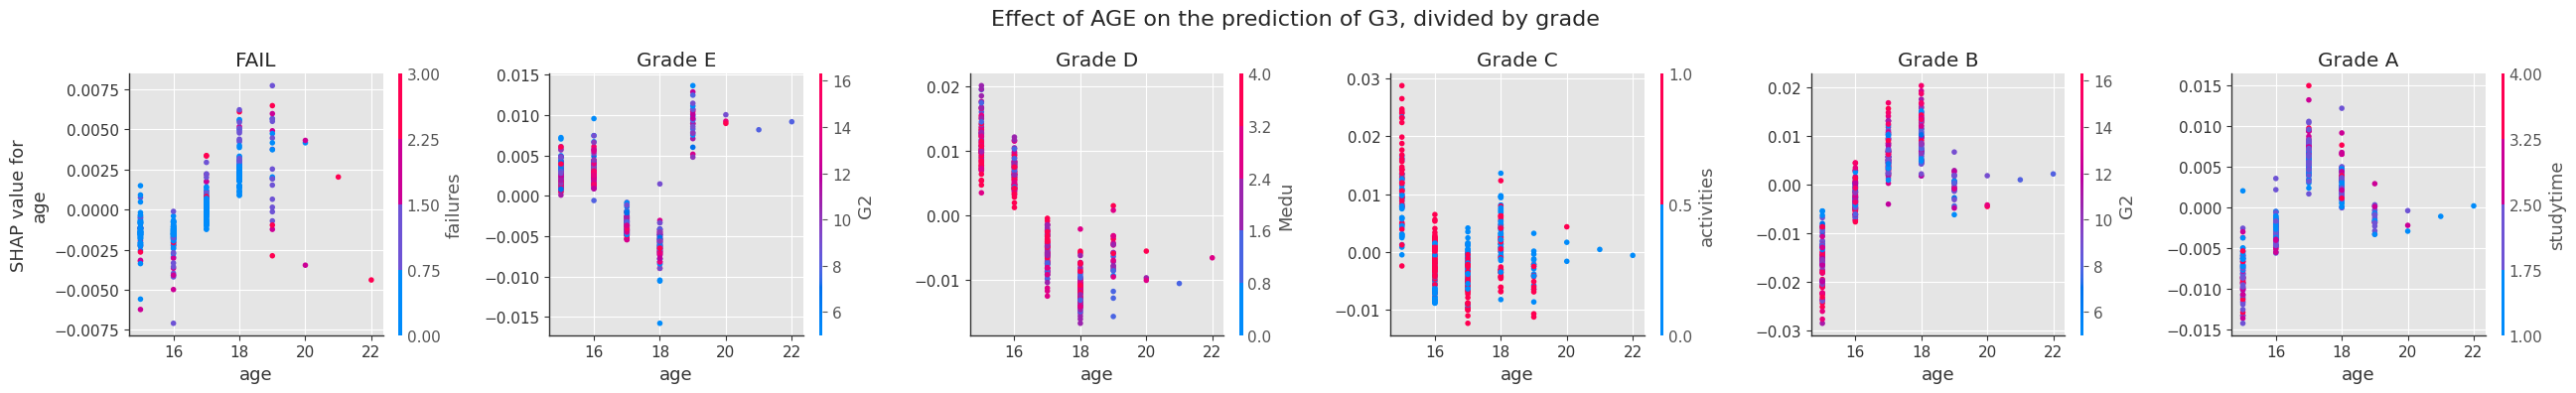

In [ ]:
plot_scatter_mc_by_feature('age', 'G3', shap_values_mc_g3, X_enc_mat_g3)

In [ ]:
# make plots colored by each of the top three possible interacting features 
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(16,20))

shap.dependence_plot('sex', shap_values_binary, X_enc_mat_g3, 
                     #interaction_index='sex', 
                     ax=ax[0][0], show=False)
ax[0][0].set_title("Effect of 'sex' on the prediction of G3")
  
shap.dependence_plot('age', shap_values_binary, X_enc_mat_g3, 
                     #interaction_index='sex', 
                     ax=ax[0][1], show=False)
ax[0][1].set_title("Effect of 'age' on the prediction of G3")

shap.dependence_plot('G1', shap_values_binary, X_enc_mat_g3,
                     #interaction_index='Dalc', 
                     ax=ax[1][0], show=False)
ax[1][0].set_title("Effect of 'G1' on the prediction of G3")
  
shap.dependence_plot('G2', shap_values_binary, X_enc_mat_g3, 
                     #interaction_index='Dalc', 
                     ax=ax[1][1], show=False)
ax[1][1].set_title("Effect of 'G2' on the prediction of G3")

shap.dependence_plot('school', shap_values_binary, X_enc_mat_g3, 
                     #interaction_index='age', 
                     ax=ax[2][0], show=False)
ax[2][0].set_title("Effect of 'school' on the prediction of G3")
  
shap.dependence_plot('Walc', shap_values_binary, X_enc_mat_g3, 
                     #interaction_index='age',
                     ax=ax[2][1], show=False)
ax[2][1].set_title("Effect of 'weekend alchool consumption' on the prediction of G3")

## Local explanations

In [ ]:
correct_failures_preds_all = [18, 100, 128, 144, 148, 160, 161, 164, 213, 225, 234, 239, 247, 250, 252, 352, 367, 370, 373, 381, 383, 384, 389, 390]
df_failures = X_mat.iloc[correct_failures_preds_all]

In [ ]:
df_failures[df_failures.sex=='F']

school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
225     GP   F   18       R     GT3       T     3     1     other     other   
367     MS   F   17       R     GT3       T     1     1     other  services   
370     MS   F   19       U     LE3       T     3     2  services  services   
373     MS   F   17       R     GT3       T     1     2     other     other   
389     MS   F   18       U     GT3       T     1     1     other     other   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
225  reputation   mother           1          2         1        no     no   
367  reputation   mother           3          1         1        no    yes   
370        home    other           2          2         2        no     no   
373      course   mother           1          1         0        no     no   
389      course   mother           2          2         1        no     no   

    paid activities nursery higher internet romantic  famrel  freetime  goout  \
225   no        yes     yes    yes      yes      yes       5         3      3   
367  yes         no     yes    yes      yes      yes       5         2      1   
370   no        yes     yes    yes       no      yes       3         2      2   
373   no        yes     yes    yes      yes       no       3         5      5   
389   no        yes     yes    yes       no       no       1         1      1   

     Dalc  Walc  health  absences  
225     1     1       4        16  
367     1     2       1         0  
370     1     1       3         4  
373     1     3       1        14  
389     1     1       5         0

### LORE

In [ ]:
!pip install bitarray
!git clone https://github.com/francescanaretto/XAI-course_2021

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.7/273.7 kB 7.1 MB/s eta 0:00:00
Cloning into 'XAI-course_2021'...
remote: Enumerating objects: 3894, done.
remote: Counting objects: 100% (1341/1341), done.
remote: Compressing objects: 100% (1325/1325), done.
remote: Total 3894 (delta 22), reused 1330 (delta 16), pack-reused 2553
Receiving objects: 100% (3894/3894), 1005.73 MiB | 35.75 MiB/s, done.
Resolving deltas: 100% (312/312), done.
Updating files: 100% (3178/3178), done.


In [ ]:
cd XAI-course_2021/Tabular

/content/XAI-course_2021/Tabular


In [ ]:
!pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.4 MB/s eta 0:00:00


In [ ]:
from xailib.explainers.lore_explainer import LoreTabularExplainer
from xailib.data_loaders.dataframe_loader import prepare_dataframe
from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

In [ ]:
df_bin_lore = pd.merge(X_enc_mat, y_mat, left_index=True, right_index=True)
expl_bin = LoreTabularExplainer(sklearn_classifier_wrapper(binary_models[0]))
config = {'neigh_type':'geneticp', 'size':1000, 'ocr':0.1, 'ngen':10}
expl_bin.fit(df_bin_lore, 'G3', config)

In [ ]:
i = 367
exp = expl_bin.explain(X_enc_mat_g3.iloc[0].values)

In [ ]:
exp.plotRules()

In [ ]:
exp.plotCounterfactualRules()

In [ ]:
df_mc_g1_lore = pd.merge(X_enc_mat, y_mat['G1'], left_index=True, right_index=True)
expl_mc_g1 = LoreTabularExplainer(sklearn_classifier_wrapper(mc_models[0]))
config = {'neigh_type':'geneticp', 'size':1000, 'ocr':0.1, 'ngen':10}
expl_mc_g1.fit(df_mc_g1_lore, 'G1', config)

In [ ]:
exp = expl_mc_g1.explain(X_enc_mat.iloc[10].values)

### Binary SHAP

In [ ]:
idx_exp = 367#370
shap_values_binary = expl_binary_g3.shap_values(X_enc_mat_g3.iloc[idx_exp])
# shap.summary_plot(shap_values_binary, X_enc_mat_g3, feature_names=X_enc_mat_g3.columns, max_display=28)#, plot_size=None, show=False)
# binary_models, binary_datasets, binary_preds, binary_probs = get_classification_predictions('binary', X_enc_por, y_por, X_enc_mat, y_mat, True)
print('Binary classification - id ', idx_exp)
print('Y real value: ', y_mat['G3'].iloc[idx_exp], 'i.e., binary class: ', binarize(y_mat['G3'].iloc[idx_exp]))
print('Predicted grade:', binary_preds[0][idx_exp])
print('Predicted probability values:', binary_probs[0][idx_exp])
shap.initjs()
shap.force_plot(expl_binary_g3.expected_value[0], shap_values_binary[0], X_enc_mat_g3.iloc[idx_exp], feature_names=X_enc_mat_g3.columns)

Binary classification - id  367
Y real value:  0 i.e., binary class:  0
Predicted grade: 0
Predicted probability values: [0.89042679 0.10957321]


Binary classification - id  367


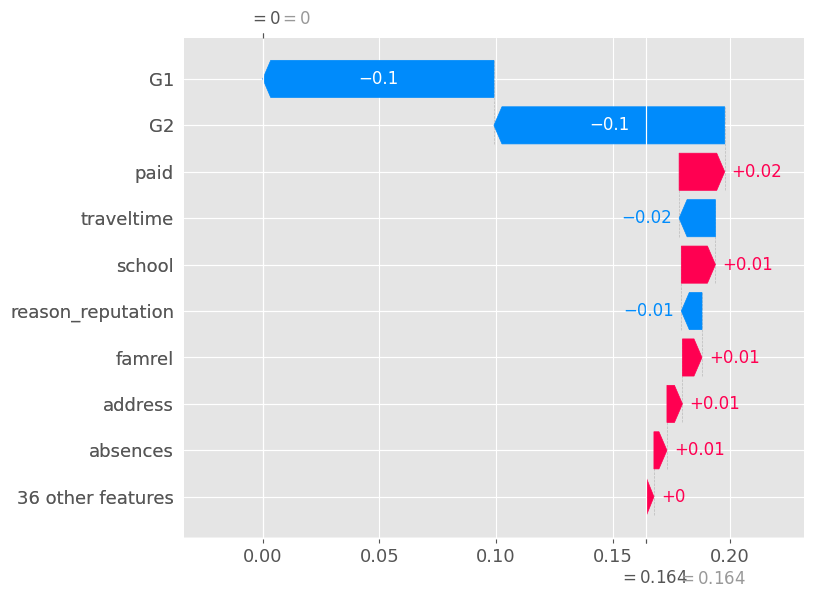

In [ ]:
print('Binary classification - id ', idx_exp)
shap.plots._waterfall.waterfall_legacy(expl_binary_g3.expected_value[0], shap_values_binary[0],
                                      feature_names=X_enc_mat_g3.columns.tolist())

### Multiclass SHAP

In [ ]:
idx_exp = 367 #370
grade = 'G1'
print('Multiclass classification - id ', idx_exp)
print('Grade ', grade)
print('Y real value: ', y_mat[grade].iloc[idx_exp], 'i.e., qualitative grade class: ', grades_to_multiclass(y_mat['G3'].iloc[idx_exp]))
class_idx_exp_predicted = mc_preds[0][idx_exp][0]
print('Predicted grade:', class_idx_exp_predicted)
print('Predicted probability values:', mc_probs[0][idx_exp])
shap.initjs()
shap.force_plot(expl_mc_g1.expected_value[class_idx_exp_predicted], 
                shap_values_mc_g1[class_idx_exp_predicted][idx_exp], 
                X_enc_mat.iloc[idx_exp], feature_names=X_enc_mat.columns)

Multiclass classification - id  367
Grade  G1
Y real value:  7 i.e., qualitative grade class:  0
Predicted grade: 0
Predicted probability values: [0.8878058  0.03797548 0.03275522 0.02377692 0.00953162 0.00815495]


In [ ]:
grade = 'G2'
print('Multiclass classification - id ', idx_exp)
print('Grade ', grade)
print('Y real value: ', y_mat[grade].iloc[idx_exp], 'i.e., qualitative grade class: ', grades_to_multiclass(y_mat['G3'].iloc[idx_exp]))
class_idx_exp_predicted_g2 = mc_preds[1][idx_exp]
print('Predicted grade:', class_idx_exp_predicted_g2)
print('Predicted probability values:', mc_probs[1][idx_exp])
shap.initjs()
shap.force_plot(expl_mc_g2.expected_value[class_idx_exp_predicted_g2], 
                shap_values_mc_g2[class_idx_exp_predicted_g2][idx_exp], 
                X_enc_mat_g2.iloc[idx_exp], feature_names=X_enc_mat_g2.columns)

Multiclass classification - id  367
Grade  G2
Y real value:  6 i.e., qualitative grade class:  0
Predicted grade: 0
Predicted probability values: [0.70957143 0.17147619 0.09111905 0.0245     0.00333333 0.        ]


In [ ]:
grade = 'G3'
print('Multiclass classification - id ', idx_exp)
print('Grade ', grade)
print('Y real value: ', y_mat[grade].iloc[idx_exp], grades_to_multiclass(y_mat['G3'].iloc[idx_exp]))
class_idx_exp_predicted_g3 = mc_preds[2][idx_exp]
print('Predicted grade:', class_idx_exp_predicted_g3)
print('Predicted probability values:', mc_probs[2][idx_exp])
shap.initjs()
shap.force_plot(expl_mc_g3.expected_value[class_idx_exp_predicted_g3], 
                shap_values_mc_g3[class_idx_exp_predicted_g3][idx_exp], 
                X_enc_mat_g3.iloc[idx_exp], feature_names=X_enc_mat_g3.columns)

Multiclass classification - id  367
Grade  G3
Y real value:  0 0
Predicted grade: 0
Predicted probability values: [0.74996414 0.18585253 0.0421381  0.01666667 0.00437857 0.001     ]


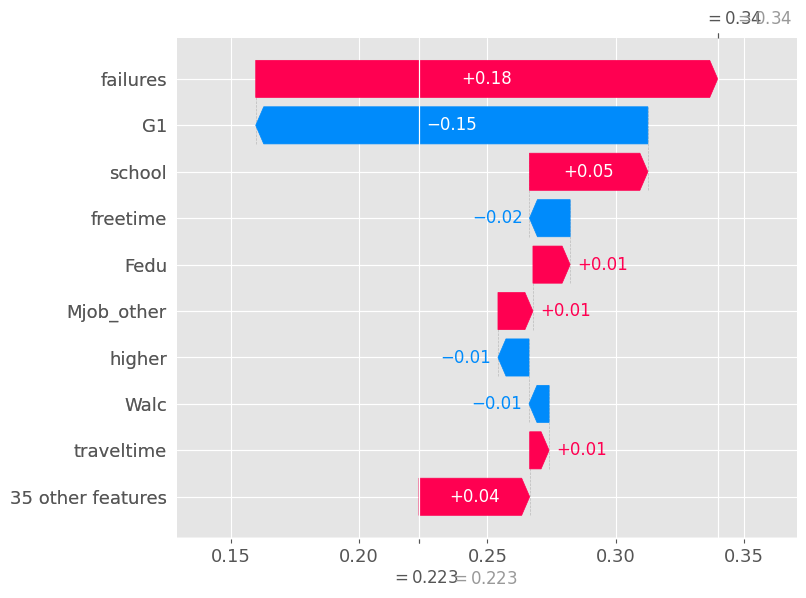

In [ ]:
shap.plots._waterfall.waterfall_legacy(expl_mc_g2.expected_value[class_idx_exp_predicted_g2], shap_values_mc_g2[class_idx_exp_predicted_g2][idx_exp],
                                      feature_names=X_enc_mat_g2.columns.tolist())

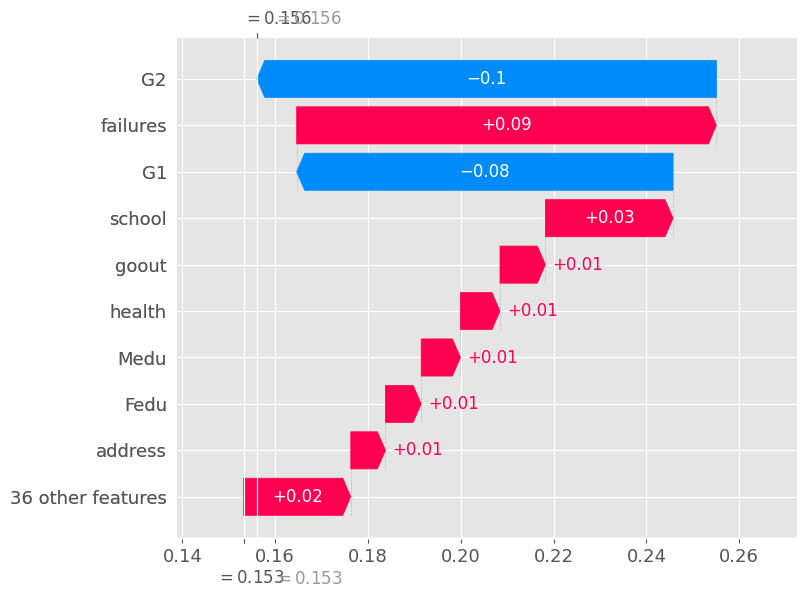

In [ ]:
shap.plots._waterfall.waterfall_legacy(expl_mc_g3.expected_value[class_idx_exp_predicted_g3], shap_values_mc_g3[class_idx_exp_predicted_g3][idx_exp],
                                      feature_names=X_enc_mat_g3.columns.tolist())

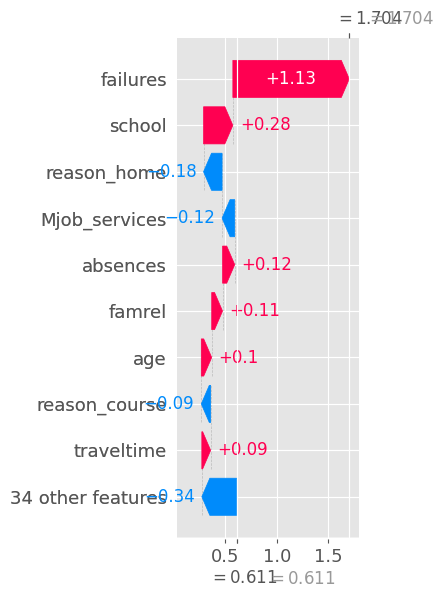

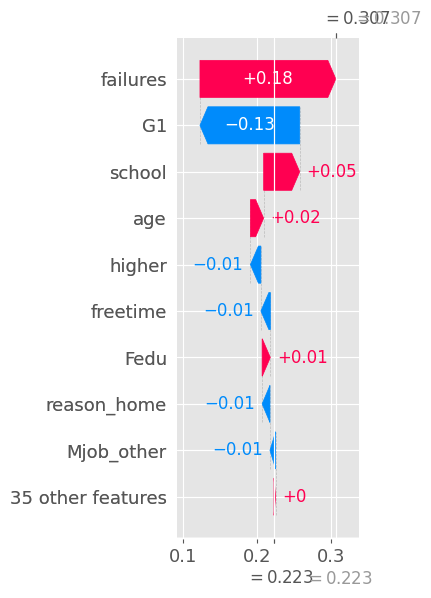

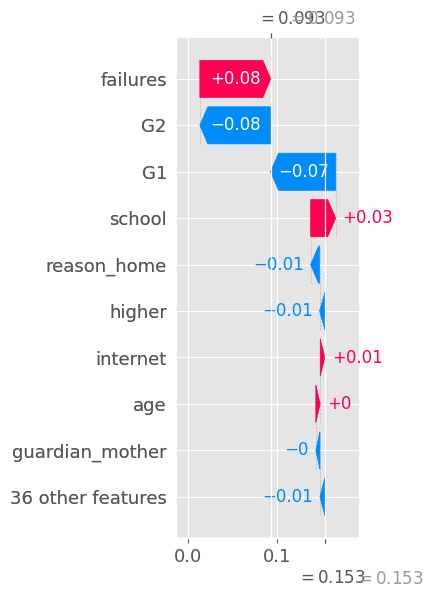

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure()
plt.subplot(1,3,1)
shap.plots._waterfall.waterfall_legacy(expl_mc_g1.expected_value[class_idx_exp_predicted], shap_values_mc_g1[class_idx_exp_predicted][idx_exp],
                                      feature_names=X_enc_mat.columns.tolist())
plt.subplot(1,3,2)
shap.plots._waterfall.waterfall_legacy(expl_mc_g2.expected_value[class_idx_exp_predicted_g2], shap_values_mc_g2[class_idx_exp_predicted_g2][idx_exp],
                                      feature_names=X_enc_mat_g2.columns.tolist())

plt.subplot(1,3,3)
shap.plots._waterfall.waterfall_legacy(expl_mc_g3.expected_value[class_idx_exp_predicted], shap_values_mc_g3[class_idx_exp_predicted][idx_exp],
                                      feature_names=X_enc_mat_g3.columns.tolist())
plt.tight_layout()
plt.show()


## DiCE

In [ ]:
!pip install dice-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.1 MB/s eta 0:00:00


In [ ]:
import dice_ml

### Binary

In [ ]:
true_g3_binary = [binarize(x) for x in y_mat.G3]
correct_failures_classifications = []
for i in range(len(true_g3_binary)):
  y = true_g3_binary[i]
  if (y==0) and (binary_preds[0][i] == y):
    correct_failures_classifications.append(i)

In [ ]:
correct_failures_classifications[:10]

[1, 18, 24, 25, 45, 49, 67, 68, 72, 79]

In [ ]:
# Step 1: dice_ml.Data
df_bin_dice_train = pd.merge(X_enc_por, y_por, left_index=True, right_index=True)
df_bin_dice_test = pd.merge(X_enc_mat, y_mat, left_index=True, right_index=True)
cols = list(X_enc_mat.columns) + ['G1','G2']
d_dice_binary = dice_ml.Data(dataframe=df_bin_dice_train.astype('int32'), continuous_features=cols, outcome_name='G3')
# Using sklearn backend
m_dice_binary = dice_ml.Model(model=binary_models[0], backend="sklearn")
# Using method=random for generating CFs
# 3 methods are allowd: random sampling, genetic algorithm search, and kd-tree based generation
exp_binary = dice_ml.Dice(d_dice_binary, m_dice_binary, method="genetic")

In [ ]:
i = 367
print('True G3: ', df_bin_dice_test['G3'][i], ', i.e., Class ', binarize(df_bin_dice_test['G3'][i]))
print('Model prediction: ', binary_preds[0][i])
# Generate counterfactual examples
query_instance = df_bin_dice_test.drop(columns="G3")[i:i+1].astype('int')
dice_exp_bin = exp_binary.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp_bin.visualize_as_dataframe()

True G3:  0 , i.e., Class  0
Model prediction:  0


100%|██████████| 1/1 [00:10<00:00, 10.25s/it]

Query instance (original outcome : 1)


school  sex  age  address  famsize  Pstatus  Medu  Fedu  traveltime  \
0       1    0   17        0        0        1     1     1           3   

   studytime  failures  schoolsup  famsup  paid  activities  nursery  higher  \
0          1         1          0       1     1           0        1       1   

   internet  romantic  famrel  freetime  goout  Dalc  Walc  health  absences  \
0         1         1       5         2      1     1     2       1         0   

   Mjob_at_home  Mjob_health  Mjob_other  Mjob_services  Mjob_teacher  \
0             0            0           1              0             0   

   Fjob_at_home  Fjob_health  Fjob_other  Fjob_services  Fjob_teacher  \
0             0            0           0              1             0   

   reason_course  reason_home  reason_other  reason_reputation  \
0              0            0             0                  1   

   guardian_father  guardian_mother  guardian_other  G1  G2  G3  
0                0                1               0   7   6   1


Diverse Counterfactual set (new outcome: 0)


school  sex   age  address  famsize  Pstatus  Medu  Fedu  traveltime  \
0     0.0  0.0  15.0      0.0      0.0      0.0   0.0   0.0         1.0   
0     0.0  0.0  15.0      0.0      0.0      0.0   0.0   0.0         1.0   
0     0.0  0.0  15.0      0.0      0.0      0.0   0.0   0.0         1.0   
0     0.0  0.0  15.0      0.0      0.0      0.0   0.0   0.0         1.0   

   studytime  failures  schoolsup  famsup  paid  activities  nursery  higher  \
0        1.0       0.0        0.0     0.0   1.0         0.0      0.0     0.0   
0        1.0       0.0        0.0     0.0   0.0         0.0      0.0     0.0   
0        1.0       0.0        0.0     0.0   1.0         0.0      0.0     0.0   
0        1.0       0.0        0.0     1.0   1.0         0.0      0.0     0.0   

   internet  romantic  famrel  freetime  goout  Dalc  Walc  health  absences  \
0       0.0       0.0     1.0       1.0    1.0   1.0   3.0     1.0       0.0   
0       0.0       0.0     1.0       1.0    1.0   1.0   1.0     1.0       0.0   
0       0.0       1.0     1.0       4.0    1.0   1.0   5.0     1.0      30.0   
0       0.0       0.0     1.0       1.0    1.0   3.0   3.0     1.0      30.0   

   Mjob_at_home  Mjob_health  Mjob_other  Mjob_services  Mjob_teacher  \
0           0.0          0.0         1.0            0.0           0.0   
0           0.0          0.0         1.0            0.0           0.0   
0           0.0          0.0         1.0            0.0           0.0   
0           0.0          1.0         1.0            0.0           0.0   

   Fjob_at_home  Fjob_health  Fjob_other  Fjob_services  Fjob_teacher  \
0           0.0          0.0         0.0            0.0           0.0   
0           0.0          0.0         0.0            1.0           0.0   
0           0.0          0.0         0.0            1.0           0.0   
0           0.0          0.0         0.0            1.0           0.0   

   reason_course  reason_home  reason_other  reason_reputation  \
0            0.0          0.0           0.0                1.0   
0            0.0          0.0           0.0                1.0   
0            0.0          0.0           0.0                0.0   
0            0.0          0.0           0.0                1.0   

   guardian_father  guardian_mother  guardian_other   G1   G2  G3  
0              0.0              0.0             0.0  0.0  0.0   0  
0              0.0              0.0             0.0  0.0  0.0   0  
0              0.0              0.0             0.0  0.0  0.0   0  
0              0.0              0.0             0.0  0.0  0.0   0

### Multiclass

In [ ]:
true_mc_g1 = [grades_to_multiclass(x) for x in y_mat.G1]
true_mc_g2 = [grades_to_multiclass(x) for x in y_mat.G2]
true_mc_g3 = [grades_to_multiclass(x) for x in y_mat.G3]
correct_failures_classifications_mc_g1 = []
correct_failures_classifications_mc_g2 = []
correct_failures_classifications_mc_g3 = []
for i in range(len(true_mc_g3)):
  g1, g2, g3 = true_mc_g1[i], true_mc_g2[i], true_mc_g3[i]
  if (g1==0) and (mc_preds[0][i] == y):
    correct_failures_classifications_mc_g1.append(i)
  if (g2==0) and (mc_preds[1][i] == y):
    correct_failures_classifications_mc_g2.append(i)
  if (g3==0) and (mc_preds[2][i] == y):
    correct_failures_classifications_mc_g3.append(i)

In [ ]:
correct_failures_preds_all = []
for i in correct_failures_classifications:
  if i in correct_failures_classifications_mc_g1:
    if i in correct_failures_classifications_mc_g2:
      if i in correct_failures_classifications_mc_g3:
        correct_failures_preds_all.append(i)

In [ ]:
print(correct_failures_preds_all)

[18, 100, 128, 144, 148, 160, 161, 164, 213, 225, 234, 239, 247, 250, 252, 352, 367, 370, 373, 381, 383, 384, 389, 390]


In [ ]:
X_mat.iloc[correct_failures_preds_all]

school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
18      GP   M   17       U     GT3       T     3     2  services  services   
100     GP   M   16       U     GT3       T     4     4  services  services   
144     GP   M   17       U     GT3       T     2     1     other     other   
148     GP   M   16       U     GT3       T     4     4   teacher   teacher   
160     GP   M   17       R     LE3       T     2     1   at_home     other   
161     GP   M   15       R     GT3       T     3     2     other     other   
164     GP   M   17       R     LE3       T     1     1     other  services   
225     GP   F   18       R     GT3       T     3     1     other     other   
234     GP   M   16       U     LE3       T     1     1     other     other   
239     GP   M   18       U     GT3       T     2     2     other  services   
247     GP   M   22       U     GT3       T     3     1  services  services   
250     GP   M   18       U     GT3       T     3     2  services     other   
252     GP   M   18       U     GT3       T     2     1  services  services   
307     GP   M   19       U     GT3       T     4     4   teacher  services   
352     MS   M   18       U     LE3       T     1     3   at_home  services   
367     MS   F   17       R     GT3       T     1     1     other  services   
370     MS   F   19       U     LE3       T     3     2  services  services   
373     MS   F   17       R     GT3       T     1     2     other     other   
381     MS   M   18       R     GT3       T     2     1     other     other   
383     MS   M   19       R     GT3       T     1     1     other  services   
384     MS   M   18       R     GT3       T     4     2     other     other   
389     MS   F   18       U     GT3       T     1     1     other     other   
390     MS   M   20       U     LE3       A     2     2  services  services   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
18       course   mother           1          1         3        no    yes   
100       other   mother           1          1         0       yes    yes   
144        home   mother           1          1         3        no    yes   
148      course   mother           1          1         0        no    yes   
160      course   mother           2          1         2        no     no   
161      course   mother           2          2         2       yes    yes   
164      course   mother           4          2         3        no     no   
225  reputation   mother           1          2         1        no     no   
234        home   mother           2          2         0        no    yes   
239  reputation   father           1          2         1        no     no   
247       other   mother           1          1         3        no     no   
250      course   mother           2          1         1        no     no   
252       other   mother           1          1         1        no     no   
307  reputation    other           2          1         1        no    yes   
352      course   mother           1          1         1        no     no   
367  reputation   mother           3          1         1        no    yes   
370        home    other           2          2         2        no     no   
373      course   mother           1          1         0        no     no   
381       other   mother           2          1         0        no     no   
383       other   mother           2          1         1        no     no   
384        home   father           2          1         1        no     no   
389      course   mother           2          2         1        no     no   
390      course    other           1          2         2        no    yes   
394      course   father           1          1         0        no     no   

    paid activities nursery higher internet romantic  famrel  freetime  goout

**G3**

In [ ]:
# Step 1: dice_ml.Data
df_mc_g3_dice_train = pd.merge(X_enc_por, y_por, left_index=True, right_index=True)
df_mc_g3_dice_test = pd.merge(X_enc_mat, y_mat, left_index=True, right_index=True)
cols = list(X_enc_mat.columns) + ['G1','G2']
d_dice_mc_g3 = dice_ml.Data(dataframe=df_mc_g3_dice_train.astype('int32'), continuous_features=cols, outcome_name='G3')
# Using sklearn backend
m_dice_mc_g3 = dice_ml.Model(model=mc_models[2], backend="sklearn")
# Using method=random for generating CFs
# 3 methods are allowed: random sampling, genetic algorithm search, and kd-tree based generation
exp_mc_g3 = dice_ml.Dice(d_dice_mc_g3, m_dice_mc_g3, method="genetic")

In [ ]:
i = 367
print('True G3: ', df_mc_g3_dice_test['G3'][i], ', i.e., Class ', grades_to_multiclass(df_mc_g3_dice_test['G3'][i]))
print('Model prediction: ', mc_preds[2][i])
# Generate counterfactual examples
query_instance = df_mc_g3_dice_test.drop(columns="G3")[i:i+1].astype('int')
dice_exp_mc_g3 = exp_mc_g3.generate_counterfactuals(query_instance, total_CFs=4, desired_class=1)
# Visualize counterfactual explanation
dice_exp_mc_g3.visualize_as_dataframe()

True G3:  0 , i.e., Class  0
Model prediction:  0


100%|██████████| 1/1 [00:02<00:00,  2.56s/it]

Query instance (original outcome : 5)


school  sex  age  address  famsize  Pstatus  Medu  Fedu  traveltime  \
0       1    0   17        0        0        1     1     1           3   

   studytime  failures  schoolsup  famsup  paid  activities  nursery  higher  \
0          1         1          0       1     1           0        1       1   

   internet  romantic  famrel  freetime  goout  Dalc  Walc  health  absences  \
0         1         1       5         2      1     1     2       1         0   

   Mjob_at_home  Mjob_health  Mjob_other  Mjob_services  Mjob_teacher  \
0             0            0           1              0             0   

   Fjob_at_home  Fjob_health  Fjob_other  Fjob_services  Fjob_teacher  \
0             0            0           0              1             0   

   reason_course  reason_home  reason_other  reason_reputation  \
0              0            0             0                  1   

   guardian_father  guardian_mother  guardian_other  G1  G2  G3  
0                0                1               0   7   6   5


Diverse Counterfactual set (new outcome: 1)


school  sex   age  address  famsize  Pstatus  Medu  Fedu  traveltime  \
0     1.0  0.0  15.0      0.0      0.0      1.0   1.0   1.0         1.0   
0     1.0  1.0  19.0      0.0      0.0      1.0   1.0   1.0         3.0   
0     1.0  0.0  17.0      0.0      0.0      1.0   1.0   1.0         1.0   
0     1.0  0.0  19.0      1.0      0.0      1.0   1.0   1.0         1.0   

   studytime  failures  schoolsup  famsup  paid  activities  nursery  higher  \
0        1.0       1.0        0.0     1.0   0.0         0.0      1.0     1.0   
0        2.0       1.0        0.0     0.0   0.0         0.0      1.0     1.0   
0        1.0       1.0        0.0     1.0   0.0         0.0      0.0     0.0   
0        3.0       1.0        0.0     0.0   0.0         1.0      1.0     0.0   

   internet  romantic  famrel  freetime  goout  Dalc  Walc  health  absences  \
0       0.0       1.0     4.0       1.0    3.0   1.0   1.0     2.0       6.0   
0       1.0       0.0     5.0       4.0    4.0   3.0   3.0     2.0       8.0   
0       1.0       0.0     5.0       4.0    4.0   2.0   2.0     5.0       0.0   
0       0.0       1.0     5.0       3.0    1.0   1.0   1.0     3.0       6.0   

   Mjob_at_home  Mjob_health  Mjob_other  Mjob_services  Mjob_teacher  \
0           1.0          0.0         0.0            0.0           0.0   
0           0.0          0.0         1.0            0.0           0.0   
0           0.0          0.0         1.0            0.0           0.0   
0           1.0          0.0         0.0            0.0           0.0   

   Fjob_at_home  Fjob_health  Fjob_other  Fjob_services  Fjob_teacher  \
0           0.0          0.0         0.0            1.0           0.0   
0           0.0          0.0         0.0            1.0           0.0   
0           0.0          0.0         1.0            0.0           0.0   
0           0.0          0.0         0.0            1.0           0.0   

   reason_course  reason_home  reason_other  reason_reputation  \
0            0.0          0.0           1.0                0.0   
0            0.0          1.0           0.0                0.0   
0            0.0          0.0           1.0                0.0   
0            1.0          0.0           0.0                0.0   

   guardian_father  guardian_mother  guardian_other    G1    G2  G3  
0              0.0              1.0             0.0  10.0  10.0   1  
0              0.0              0.0             1.0  10.0   9.0   1  
0              1.0              0.0             0.0   6.0   6.0   1  
0              0.0              1.0             0.0   7.0   9.0   1

**G2**

In [ ]:
# Step 1: dice_ml.Data
df_mc_g2_dice_train = pd.merge(X_enc_por, y_por[['G1','G2']], left_index=True, right_index=True)
df_mc_g2_dice_test = pd.merge(X_enc_mat, y_mat[['G1','G2']], left_index=True, right_index=True)
cols = list(X_enc_mat.columns) + ['G1']
d_dice_mc_g2 = dice_ml.Data(dataframe=df_mc_g2_dice_train.astype('int32'), continuous_features=cols, outcome_name='G2')
# Using sklearn backend
m_dice_mc_g2 = dice_ml.Model(model=mc_models[1], backend="sklearn")
# Using method=random for generating CFs
# 3 methods are allowd: random sampling, genetic algorithm search, and kd-tree based generation
exp_mc_g2 = dice_ml.Dice(d_dice_mc_g2, m_dice_mc_g2, method="genetic")

In [ ]:
print('True G2: ', df_mc_g2_dice_test['G2'][1], ', i.e., Class ', grades_to_multiclass(df_mc_g3_dice_test['G2'][1]))
# Generate counterfactual examples
query_instance = df_mc_g2_dice_test.drop(columns="23")[0:1].astype('int')
dice_exp_mc_g2 = exp_mc_g2.generate_counterfactuals(query_instance, total_CFs=4, desired_class=5)
# Visualize counterfactual explanation
dice_exp_mc_g2.visualize_as_dataframe()

**G1**

In [ ]:
# Step 1: dice_ml.Data
df_mc_g1_dice_train = pd.merge(X_enc_por, y_por['G1'], left_index=True, right_index=True)
df_mc_g1_dice_test = pd.merge(X_enc_mat, y_mat['G1'], left_index=True, right_index=True)
cols = list(X_enc_mat.columns)
d_dice_mc_g1 = dice_ml.Data(dataframe=df_mc_g1_dice_train.astype('int32'), continuous_features=cols, outcome_name='G1')
# Using sklearn backend
m_dice_mc_g1 = dice_ml.Model(model=mc_models[0], backend="sklearn")
# Using method=random for generating CFs
# 3 methods are allowd: random sampling, genetic algorithm search, and kd-tree based generation
exp_mc_g1 = dice_ml.Dice(d_dice_mc_g1, m_dice_mc_g1, method="genetic")

In [ ]:
print('True G1: ', df_mc_g1_dice_test['G1'][1], ', i.e., Class ', grades_to_multiclass(df_mc_g3_dice_test['G1'][1]))
# Generate counterfactual examples
query_instance = df_mc_g2_dice_test.drop(columns="23")[0:1].astype('int')
dice_exp_mc_g2 = exp_mc_g1.generate_counterfactuals(query_instance, total_CFs=4, desired_class=5)
# Visualize counterfactual explanation
dice_exp_mc_g2.visualize_as_dataframe()

# Others

In [ ]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15, 10))
plot_tree(rf.estimators_[0], 
          feature_names=X_enc_por.columns,
#          class_names=X_enc_por.target_names, 
          filled=True, impurity=True, 
          rounded=True)

In [ ]:
shap_values_expl = shap.Explanation(shap_values, 
                                    feature_names=X_por_test.columns,
                                    base_values = np.tile(explainer.expected_value, shap_values.shape[0]))

AttributeError: ignored

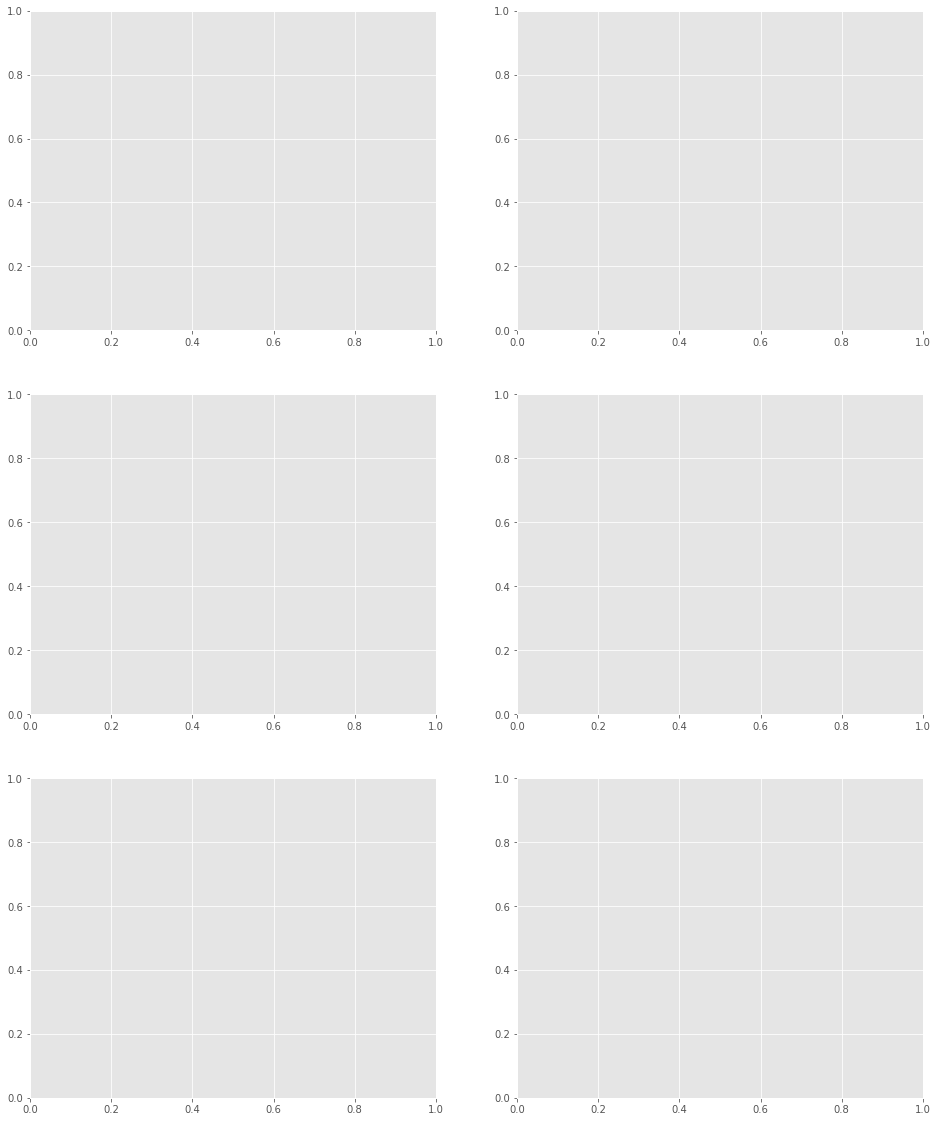

In [ ]:
# make plots colored by each of the top three possible interacting features (might differ for the seasonal and h1n1)
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(16,20))

shap.plots.scatter(shap_values_expl[:,'G1'], color='sex', ax=ax[0][0], show=False)
ax[0][0].set_title("G1- Sex")
ax[0][0].tick_params(labelrotation= 45)
  
shap.plots.scatter('G2', shap_values, X_por_test, color='sex', ax=ax[0][1], show=False)
ax[0][1].set_title("G2- Sex")
ax[0][1].tick_params(labelrotation= 45)

shap.plots.scatter('G1', shap_values, X_por_test, color='Dalc', ax=ax[1][0], show=False)
ax[0][0].set_title("G1- workday alcohol consumption ")
ax[0][0].tick_params(labelrotation= 45)
  
shap.plots.scatter('G2', shap_values, X_por_test, color='Dalc', ax=ax[1][1], show=False)
ax[0][1].set_title("G2- workday alcohol consumption ")
ax[0][1].tick_params(labelrotation= 45)

shap.plots.scatter('G1', shap_values, X_por_test, color='address', ax=ax[2][0], show=False)
ax[0][0].set_title("G1-Address")
ax[0][0].tick_params(labelrotation= 45)
  
shap.plots.scatter('G2', shap_values, X_por_test, color='address', ax=ax[2][1], show=False)
ax[0][1].set_title("G2- Address")
ax[0][1].tick_params(labelrotation= 45)

In [ ]:
shap.dependence_plot('G1', shap_values_expl, X_por_test, feature_names=X_por_test.columns, color='sex')

In [ ]:
shap.dependence_plot(shap_values[:,'G2'], feature_names=X_por_test.columns)

IndexError: ignored